In [450]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json
import seaborn as sns
import time

## Data Preparation & Preprocessing

In [451]:
# Plot Price curve (ground truth data)
def plot_price_curve(data):
    plt.figure(figsize=(10, 5))
    plt.plot(data)
    plt.legend()
    plt.title('Prices Curve')
    # plt.ylim(-1, 1)
    plt.show()

In [452]:
class DataPreparation():
    def __init__(self, dataset_filename, num_steps=None, input_size=None, configs_filename='configs', seed=42):
        self.num_steps = num_steps
        self.input_size = input_size
        self.set_seed(seed)
        self.load_configs(configs_filename)
        self.load_data(dataset_filename)
        
    def set_seed(self, seed):
        np.random.seed(seed)  # Set seed for numpy
        random.seed(seed)  # Set seed for random
        
        if torch.cuda.is_available():
            torch.manual_seed(seed)  # Set seed for PyTorch CPU
        
        torch.cuda.manual_seed(seed)  # Set seed for PyTorch GPU
        torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
        torch.backends.cudnn.benchmark = False  # Disable the auto-tuner for GPUs
    
    def load_configs(self, configs_filename):
        # Load hyperparameters
        with open(f'configs/{configs_filename}.json', 'r') as file:
            self.hyperparams = json.load(file)
            
    def load_data(self, dataset_filename):
        self.data = pd.read_csv('data/' + dataset_filename + '.csv')
        # self.data = self.data.resample(period).mean()  # Resample data based on the period
        
        # Extract attributes
        if self.num_steps is None:
            self.num_steps = self.hyperparams['num_steps']  # Extract number of steps
        
        if self.input_size is None:
            self.input_size = self.hyperparams['input_size']  # Extract input size
        
        self.val_split = self.hyperparams['val_split']  # Extract validation split
        self.test_split = self.hyperparams['test_split']  # Extract test split
        self.batch_size = self.hyperparams['batch_size'] # Extract batch size
        self.num_workers = self.hyperparams['num_workers'] # Extract number of workers (for GPU)
        self.volume_threshold = self.hyperparams['volume_threshold'] # Extract volume threshold (for main contract)
        self.open_interest_threshold = self.hyperparams['open_interest_threshold'] # Extract open interest threshold (for main contract)
        self.time_interval = self.hyperparams['time_interval'] # Extract time interval of data (in seconds)
        self.normalize = self.hyperparams['normalize']
        
        # Extract main contract
        self.data = extract_high_frequency_trading(self.data, volume_threshold=self.volume_threshold, open_interest_threshold=self.open_interest_threshold, time_interval=self.time_interval)
        
        # Normalize data
        self.data = self.normalize_data(self.data)

        # Assert no NaN values
        assert(self.data.isna().sum().sum() == 0)

        # Create sequences (with sliding windows)
        X_train, y_train, X_val, y_val, X_test, y_test = self.create_sequences(self.data, self.input_size, self.num_steps, self.val_split, self.test_split)
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        
        assert(not torch.isnan(X_train_tensor).any())
        assert(not torch.isnan(y_train_tensor).any())
        assert(not torch.isnan(X_val_tensor).any())
        assert(not torch.isnan(y_val_tensor).any())
        assert(not torch.isnan(X_test_tensor).any())
        assert(not torch.isnan(y_test_tensor).any())
        
        # Create DataLoader instances
        self.train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
        self.val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
        self.test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)

    def normalize_data(self, data):
        # Apply MinMaxScaler to normalize data
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
        return pd.DataFrame(normalized_data, index=data.index, columns=data.columns)
    
    def create_sequences(self, data, input_size, num_steps, val_split=0.1, test_split=0.1):
        # Convert data to numpy array
        data = np.array(data)
    
        # Roll data
        data = [np.array(data[i * input_size: (i + 1) * input_size]) 
           for i in range(len(data) // input_size)]
    
        # Convert data to numpy array
        data = np.array(data)
    
        # Check if data has any NaNs
        if np.isnan(data).any():
            raise ValueError("Data contains NaN values. Please clean the data before proceeding.")
    
        # Replace zeros in the last price with a small value to avoid division by zero
        last_price_index = 0
        data[:, :, last_price_index] = np.where(data[:, :, last_price_index] == 0, 1e-6, data[:, :, last_price_index])  # Small constant to avoid division by zero
    
        # Normalize the last_price (predict relative change rates)
        if self.normalize:
            normalized_last_price = [data[0, :, last_price_index] / data[0, 0, last_price_index] - 1.0]  # Initial normalization
            
            for i in range(1, data.shape[0]):
                normalized_last_price.append(data[i, :, last_price_index] / data[i-1, -1, last_price_index] - 1.0)
            
            normalized_last_price = np.array(normalized_last_price)

            # Remove outliers
            normalized_last_price = np.clip(normalized_last_price, -1, 1)
            
            data[:, :, last_price_index] = normalized_last_price
    
        plot_price_curve(data[:, :, last_price_index])
    
        # Check for remaining NaNs after normalization
        if np.isnan(data[:, :, last_price_index]).any():
            raise ValueError("Data contains NaN values after normalization. Please check the normalization process.")
    
        # Split into groups of `num_steps`
        X = np.array([data[i: i + num_steps] for i in range(len(data) - num_steps)])
        assert(X.shape == (len(X), num_steps, input_size, data.shape[-1]))
        y = np.array([data[i + num_steps, :, last_price_index] for i in range(len(data) - num_steps)])
        assert(y.shape == (len(X), input_size))
    
        self.num_features = data.shape[-1]
    
        # Ensure X and y have the same number of samples after splitting
        assert len(X) == len(y), "Number of samples in X and y must be equal"
    
        # Split into train, validation, and test sets
        total_len = len(X)
        test_start = int(total_len * (1 - test_split))
        val_start = int(total_len * (1 - test_split - val_split))
    
        X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
        y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]
    
        return X_train, y_train, X_val, y_val, X_test, y_test

def extract_continuous_segment(data, volume_threshold, open_interest_threshold, time_interval):
    """
    Extracts the largest continuous segment from high-frequency data based on given thresholds and time interval.
    
    Args:
    data (pd.DataFrame): High-frequency data containing 'Timestamp', 'Volume', and 'OpenInterest' columns.
    volume_threshold (int): Minimum volume threshold.
    open_interest_threshold (int): Minimum open interest threshold.
    time_interval (float): Maximum allowable time difference between consecutive data points (in seconds).

    Returns:
    pd.DataFrame: Continuous segment of the main contract data.
    """
    # Step 1: Remove rows with NaN values
    cleaned_data = data.dropna()

    # Step 2: Apply volume and open interest thresholds
    filtered_data = cleaned_data[(cleaned_data['volume'] >= volume_threshold) & 
                                 (cleaned_data['open_interest'] >= open_interest_threshold)]
    
    # Step 3: Identify continuous segments
    filtered_data = filtered_data.sort_values(by='datetime')

    # Calculate time differences between consecutive rows
    filtered_data['datetime_diff'] = filtered_data['datetime'].diff().dt.total_seconds()

    # Identify segments where the time difference is larger than the time_interval threshold
    filtered_data['segment'] = (filtered_data['datetime_diff'] > time_interval).cumsum()

    # Find the length of each segment
    segment_lengths = filtered_data['segment'].value_counts()

    # Extract the largest segment
    largest_segment = segment_lengths.idxmax()
    continuous_data = filtered_data[filtered_data['segment'] == largest_segment]

    # Drop the temporary columns
    continuous_data = continuous_data.drop(columns=['datetime_diff', 'segment'])

    return continuous_data


def extract_high_frequency_trading(data, volume_threshold=1000, open_interest_threshold=500, time_interval=1):
    # Convert datetime column to pandas datetime type
    data['datetime'] = pd.to_datetime(data['datetime'])
    
    # Identify high-frequency trading periods
    # Assuming a significant increase in volume and consistent bid/ask prices indicates high-frequency trading
    # Adjust the thresholds as necessary for your dataset
    high_freq_trading = data[
        (data['volume'] > volume_threshold) & 
        (data['open_interest'] > open_interest_threshold) & 
        (data['last_price'].notna()) & 
        (data['highest'].notna()) & 
        (data['volume'].notna()) & 
        (data['amount'].notna()) & 
        (data['bid_price1'].notna()) & 
        (data['ask_price1'].notna())
    ]

    # Additional filter to ensure high-frequency (optional)
    # Extract largest continuous segment of high-frequency trading data
    high_freq_trading = extract_continuous_segment(high_freq_trading, volume_threshold, open_interest_threshold, time_interval)
    high_freq_trading = high_freq_trading.set_index('datetime')
    
    # Ensure No NaN values remaining
    assert(high_freq_trading.isna().sum().sum() == 0)
    
    # Return the filtered dataset
    return high_freq_trading

In [ ]:
dataset_name = 'INE.sc2010'
data_preparation = DataPreparation(dataset_name) 

## Model Definition: LSTM Cell

In [ ]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_i = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_i = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_f = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_f = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_c = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_c = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_o = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_o = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_i = nn.LayerNorm(hidden_dim)
        self.ln_f = nn.LayerNorm(hidden_dim)
        self.ln_c = nn.LayerNorm(hidden_dim)
        self.ln_o = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h, c):
        # Compute gates
        i_t = torch.sigmoid(self.ln_i(torch.matmul(x, self.W_i) + torch.matmul(h, self.U_i) + self.b_i))
        f_t = torch.sigmoid(self.ln_f(torch.matmul(x, self.W_f) + torch.matmul(h, self.U_f) + self.b_f))
        g_t = torch.tanh(self.ln_c(torch.matmul(x, self.W_c) + torch.matmul(h, self.U_c) + self.b_c))
        o_t = torch.sigmoid(self.ln_o(torch.matmul(x, self.W_o) + torch.matmul(h, self.U_o) + self.b_o))

        # Compute cell and hidden state
        c_t = f_t * c + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        assert(not torch.isnan(h_t).any())
        assert(not torch.isnan(c_t).any())
        
        return h_t, c_t

## Model Definition: GRU Cell

In [ ]:
class CustomGRUCell(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_z = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_z = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_r = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_r = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_h = nn.Parameter(torch.randn(input_size, hidden_dim).float())
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_h = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_z = nn.LayerNorm(hidden_dim)
        self.ln_r = nn.LayerNorm(hidden_dim)
        self.ln_h = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h):
        z_t = torch.sigmoid(self.ln_z(torch.mm(x, self.W_z) + torch.mm(h, self.U_z) + self.b_z))
        r_t = torch.sigmoid(self.ln_r(torch.mm(x, self.W_r) + torch.mm(h, self.U_r) + self.b_r))
        h_hat_t = torch.tanh(self.ln_h(torch.mm(x, self.W_h) + torch.mm(r_t * h, self.U_h) + self.b_h))

        h_t = (1 - z_t) * h + z_t * h_hat_t
        
        assert(not torch.isnan(h_t).any())
    
        return h_t

## Model Definition: RNN

In [ ]:
class CustomRNNModel(nn.Module):
    def __init__(self, input_size, num_features, hidden_dim, output_dim, num_layers, dropout_rate, dense_units, cell_type='lstm'):
        super(CustomRNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type
        self.input_dim = input_size * num_features

        if cell_type == 'lstm':
            self.layers = nn.ModuleList([CustomLSTMCell(self.input_dim, hidden_dim)])
            self.layers.extend([CustomLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        elif cell_type == 'gru':
            self.layers = nn.ModuleList([CustomGRUCell(self.input_dim, hidden_dim)])
            self.layers.extend([CustomGRUCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        else:
            raise ValueError("Unsupported cell type")

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, dense_units)
        self.fc2 = nn.Linear(dense_units, output_dim)

    def forward(self, x):
        batch_size, num_steps, input_size, num_features = x.size()
        x = x.view(batch_size, num_steps, -1)  # Flatten the input dimensions to (batch_size, num_steps, input_size * num_features)

        h_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]
        if self.cell_type == 'lstm':
            c_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]

        for t in range(num_steps):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                if self.cell_type == 'lstm':
                    h_t[layer], c_t[layer] = self.layers[layer](x_t, h_t[layer], c_t[layer])
                else:
                    h_t[layer] = self.layers[layer](x_t, h_t[layer])
                x_t = h_t[layer]

        x = self.dropout(x_t)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## RNN Model Training + Evaluation

In [ ]:
# Loss definitions
def quantile_loss(outputs, targets, quantile=0.5):
    errors = targets - outputs
    loss = torch.max((quantile - 1) * errors, quantile * errors)
    return torch.mean(loss)


class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, outputs, targets):
        return torch.mean(torch.clamp(1 - targets * outputs, min=0))


def directional_loss(outputs, targets):
    return torch.mean(torch.abs(torch.sign(outputs) - torch.sign(targets)))


def choose_loss_function(loss, quantile=None):
    if loss == 'huber':
        criterion = nn.SmoothL1Loss()
    elif loss == 'mse':
        criterion = nn.MSELoss()
    elif loss == 'quantile' and quantile is not None:
        criterion = lambda outputs, targets: quantile_loss(outputs, targets, quantile=quantile)
    elif loss == 'hinge':
        criterion = HingeLoss()
    elif loss == 'directional':
        criterion = directional_loss
    else:
        raise ValueError("Unsupported loss function")

    return criterion

In [ ]:
class ModelTrainer:
    def __init__(self, data_preparation, cell_type):
        self.data_preparation = data_preparation
        self.cell_type = cell_type

    def extract_hyperparams(self):
        dp = self.data_preparation
        cell_type = self.cell_type
        num_units = dp.hyperparams[cell_type][cell_type + '_units']
        num_layers = dp.hyperparams[cell_type][cell_type + '_layers']
        dropout_rate = dp.hyperparams[cell_type]['dropout_rate']
        dense_units = dp.hyperparams[cell_type]['dense_units']
        init_learning_rate = dp.hyperparams[cell_type]['init_learning_rate']
        learning_rate_decay = dp.hyperparams[cell_type]['learning_rate_decay']
        init_epochs = dp.hyperparams[cell_type]['init_epochs']
        max_epochs = dp.hyperparams[cell_type]['max_epochs']
        early_stop_patience = dp.hyperparams[cell_type].get('early_stop_patience', None)
        train_needed = dp.hyperparams[cell_type]['pretrain']
        
        return num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, early_stop_patience, train_needed

    def train_model(self, model, train_loader, val_loader, criterion, init_epochs, num_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience=None):
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        early_stop_counter = 0
    
        optimizer = optim.Adam(model.parameters(), lr=init_learning_rate)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0)
    
        for epoch in range(num_epochs):
            model.train()
            current_lr = init_learning_rate * (learning_rate_decay ** max(float(epoch + 1 - init_epochs), 0.0))
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
                
            train_loss = 0.0
            for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
    
                train_loss += loss.item()
    
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
    
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    val_loss += criterion(outputs, y_batch).item()
    
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
    
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
            scheduler.step()
    
            if early_stop_patience is not None:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stop_counter = 0
                    torch.save(model.state_dict(), f'models/SP500_{self.cell_type}_model.pth')
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= early_stop_patience:
                        print("Early stopping triggered")
                        break
    
        return train_losses, val_losses

    def train(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, early_stop_patience, train_needed = self.extract_hyperparams()
        num_features = self.data_preparation.num_features
        input_size = self.data_preparation.input_size

        model = CustomRNNModel(input_size=input_size, num_features=num_features, hidden_dim=num_units, output_dim=input_size, num_layers=num_layers, dropout_rate=dropout_rate, dense_units=dense_units, cell_type=self.cell_type)
        model.to(device)
        
        if train_needed: 
            criterion = choose_loss_function('mse')
    
            start_time = time.time()
            train_losses, val_losses = self.train_model(model, self.data_preparation.train_loader, self.data_preparation.val_loader, criterion, init_epochs, max_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience)
            duration = time.time() - start_time
            torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')
        else:
            # Load the model
            model = self.load_model(model, cell_type, device)
            print("Model loaded successfully")

        # Plot train and validation loss curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend()
        plt.title('Loss Curves')
        plt.show()

        return model, duration

In [ ]:
class ModelPredictor:
    def __init__(self, model, data_preparation, cell_type):
        self.model = model
        self.data_preparation = data_preparation
        self.cell_type = cell_type

    def make_predictions(self, model, data_loader, device):
        model.eval()
        predictions = []
        actuals = []
        test_loss = 0
        criterion = choose_loss_function('mse')
        
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                predictions.append(outputs.cpu().numpy())
                actuals.append(y_batch.cpu().numpy())
                test_loss += criterion(outputs, y_batch).item()

        test_loss /= len(data_loader)
        predictions = np.concatenate(predictions)
        actuals = np.concatenate(actuals)
        return np.array(predictions).flatten(), np.array(actuals).flatten(), test_loss

    def calculate_accuracy(self, predictions, actuals):
        correct = np.sum(np.sign(predictions) == np.sign(actuals))
        print("correct:", correct)
        total = len(actuals.flatten())
        print("total:", total)
        accuracy = correct / total
        return accuracy

     # Plot the predictions against the actual values
    def plot_results(self, data_preparation, actuals, predictions):
        plt.figure(figsize=(10, 5))
        x = np.arange(len(actuals))
        plt.bar(x - 0.2, actuals, label='Actual Prices')
        plt.bar(x + 0.2, predictions, label='Predicted Prices')
        plt.xlabel('Value')
        plt.ylabel('Normalized Price')
        plt.ylim(-0.1, 0.1)
        plt.title(f'Predicted vs Actual Prices for input_size={data_preparation.input_size}, num_steps={data_preparation.num_steps}')
        plt.legend()
        plt.show()

    def predict(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        
        predictions, actuals, test_loss = self.make_predictions(self.model, self.data_preparation.test_loader, device)

        print("predictions:", predictions[0:5])
        print("actuals:", actuals[0:5])
        
        classification_accuracy = self.calculate_accuracy(predictions, actuals)
        self.plot_results(self.data_preparation, predictions, actuals)
        
        return test_loss, classification_accuracy

In [ ]:
cell_type = 'lstm'

In [ ]:
# Training
trainer = ModelTrainer(data_preparation, cell_type)
trained_model, training_duration = trainer.train()
print(f"Training duration: {training_duration} seconds")

In [ ]:
# Prediction
predictor = ModelPredictor(trained_model, data_preparation, cell_type)
test_loss, classification_accuracy = predictor.predict()
print(f"Test loss: {test_loss}")
print(f"Classification accuracy: {classification_accuracy}")

In [ ]:
cell_type = 'gru'

In [ ]:
# Training
trainer = ModelTrainer(data_preparation, cell_type)
trained_model, training_duration = trainer.train()
print(f"Training duration: {training_duration} seconds")

In [ ]:
# Prediction
predictor = ModelPredictor(trained_model, data_preparation, cell_type)
test_loss, classification_accuracy = predictor.predict()
print(f"Test loss: {test_loss}")
print(f"Classification accuracy: {classification_accuracy}")

## Hyperparameter Search over `input_size` and `num_steps`

In [430]:
def grid_search(cell_type, input_size_values, num_steps_values):
    # Define dataframe
    df = pd.DataFrame(columns=['Input Size', 'Number of Steps', 'Test Loss', 'Classification Accuracy', 'Duration'])
    
    # Define test losses & classification accuracies
    input_size_combination_values = []
    num_steps_combination_values = []

    # Define hyperparam combinations
    test_losses = []
    classification_accuracies = []
    durations = []
    
    # Loop over the hyperparam values
    for input_size in input_size_values:
        for num_steps in num_steps_values:
            # Add to hyperparam combination
            input_size_combination_values.append(input_size)
            num_steps_combination_values.append(num_steps)
            
            # Modify the input_size and num_steps attributes
            data_preparation = DataPreparation(dataset_name, num_steps=num_steps, input_size=input_size)
            
            # Training
            trainer = ModelTrainer(data_preparation, cell_type)
            trained_model, training_duration = trainer.train()

            # Prediction
            predictor = ModelPredictor(trained_model, data_preparation, cell_type)
            test_loss, classification_accuracy = predictor.predict()
            
            test_losses.append(test_loss)
            classification_accuracies.append(classification_accuracy)   
            durations.append(training_duration)
    
    df['Input Size'] = input_size_combination_values
    df['Number of Steps'] = num_steps_combination_values
    df['Test Loss'] = test_losses
    df['Classification Accuracy'] = classification_accuracies
    df['Duration'] = durations
    
    df.to_csv(f'results/{cell_type}_evaluation_results.csv')

In [431]:
def get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=False):
    # Perform grid search if needed (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
    if SEARCH_NEEDED:
        grid_search(cell_type, input_size_values, num_steps_values)
    
    # Get best model
    df = pd.read_csv(f'results/{cell_type}_evaluation_results.csv')
    idx = np.argmin(df['Test Loss'])
    df_best_model = df.iloc[idx, :]
    return df_best_model

In [432]:
input_size_values = [2, 3, 5, 10, 20]
num_steps_values = [3, 10, 20, 30, 40, 50]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


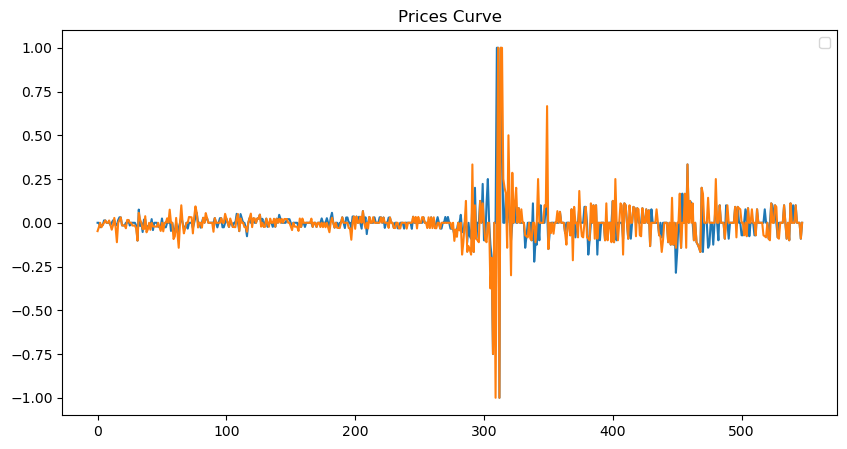

Epoch 1/50, Train Loss: 0.0227, Val Loss: 0.0137


Epoch 2/50, Train Loss: 0.0198, Val Loss: 0.0122


Epoch 3/50, Train Loss: 0.0183, Val Loss: 0.0115


Epoch 4/50, Train Loss: 0.0172, Val Loss: 0.0112


Epoch 5/50, Train Loss: 0.0174, Val Loss: 0.0111


Epoch 6/50, Train Loss: 0.0166, Val Loss: 0.0112


Epoch 7/50, Train Loss: 0.0170, Val Loss: 0.0112


Epoch 8/50, Train Loss: 0.0158, Val Loss: 0.0112


Epoch 9/50, Train Loss: 0.0164, Val Loss: 0.0112


Epoch 10/50, Train Loss: 0.0160, Val Loss: 0.0112


Epoch 11/50, Train Loss: 0.0160, Val Loss: 0.0112


Epoch 12/50, Train Loss: 0.0158, Val Loss: 0.0112


Epoch 13/50, Train Loss: 0.0159, Val Loss: 0.0113


Epoch 14/50, Train Loss: 0.0163, Val Loss: 0.0113


Epoch 15/50, Train Loss: 0.0166, Val Loss: 0.0112
Early stopping triggered


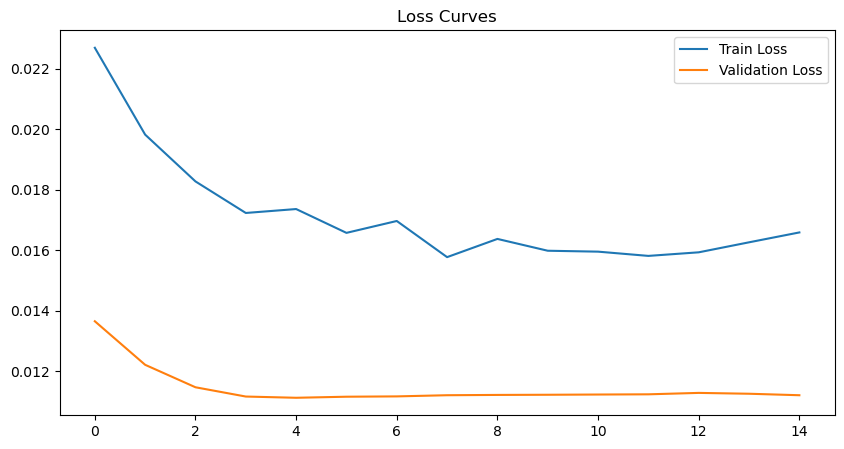

predictions: [ 0.00474631  0.01319513  0.00053148  0.01495627 -0.00721365]
actuals: [0.         0.         0.         0.         0.09090909]
correct: 24
total: 110


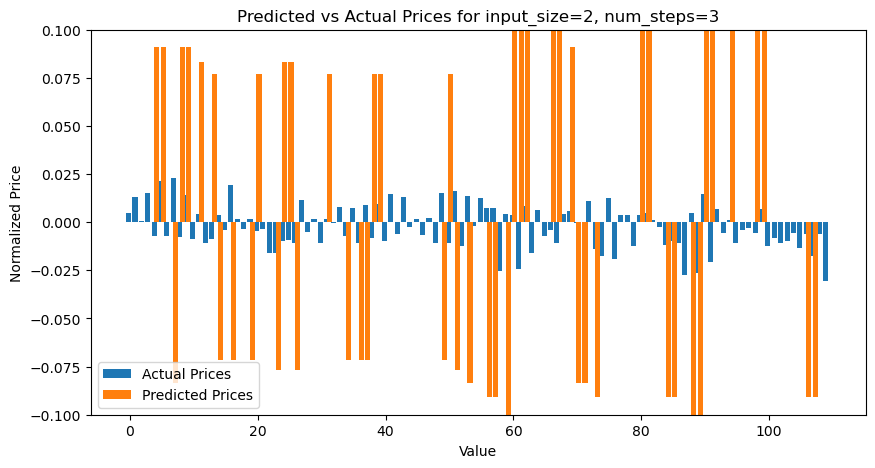

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


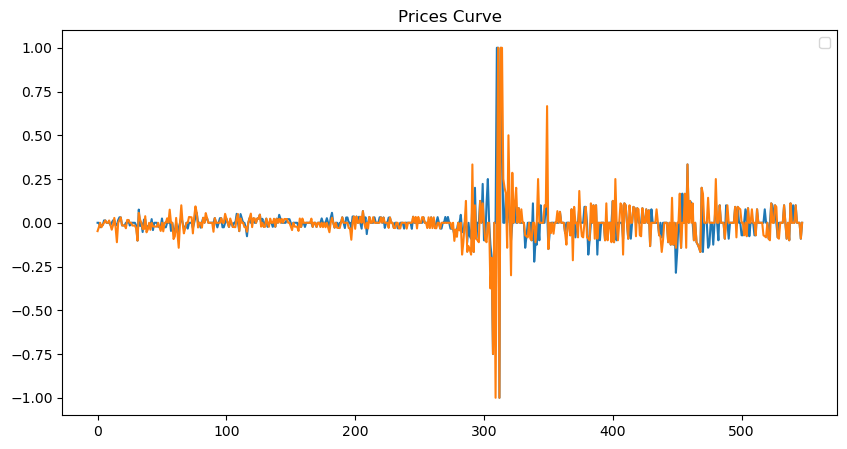

Epoch 1/50, Train Loss: 0.0258, Val Loss: 0.0160


Epoch 2/50, Train Loss: 0.0210, Val Loss: 0.0129


Epoch 3/50, Train Loss: 0.0184, Val Loss: 0.0115


Epoch 4/50, Train Loss: 0.0183, Val Loss: 0.0109


Epoch 5/50, Train Loss: 0.0179, Val Loss: 0.0108


Epoch 6/50, Train Loss: 0.0176, Val Loss: 0.0108


Epoch 7/50, Train Loss: 0.0170, Val Loss: 0.0108


Epoch 8/50, Train Loss: 0.0167, Val Loss: 0.0108


Epoch 9/50, Train Loss: 0.0174, Val Loss: 0.0110


Epoch 10/50, Train Loss: 0.0165, Val Loss: 0.0112


Epoch 11/50, Train Loss: 0.0164, Val Loss: 0.0115


Epoch 12/50, Train Loss: 0.0163, Val Loss: 0.0117


Epoch 13/50, Train Loss: 0.0168, Val Loss: 0.0118


Epoch 14/50, Train Loss: 0.0153, Val Loss: 0.0120


Epoch 15/50, Train Loss: 0.0156, Val Loss: 0.0122
Early stopping triggered


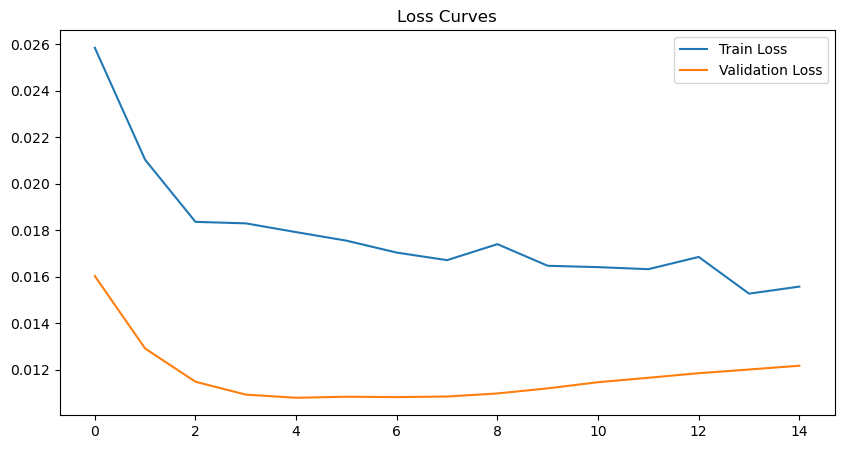

predictions: [-0.01622161 -0.0081695  -0.01732185 -0.01683889 -0.0158072 ]
actuals: [0.         0.         0.09090909 0.09090909 0.        ]
correct: 25
total: 108


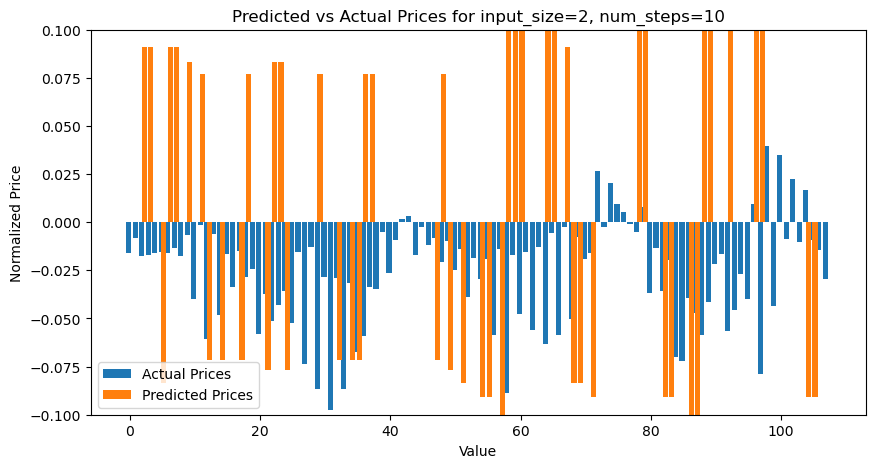

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


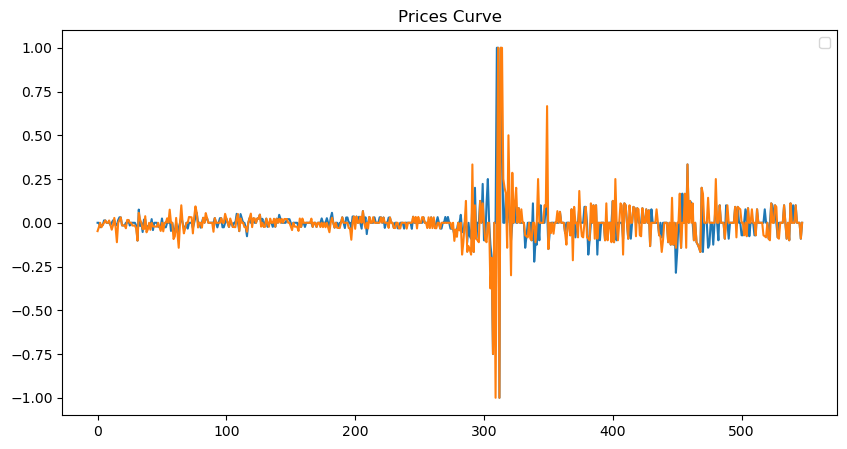

Epoch 1/50, Train Loss: 0.0365, Val Loss: 0.0140


Epoch 2/50, Train Loss: 0.0250, Val Loss: 0.0134


Epoch 3/50, Train Loss: 0.0193, Val Loss: 0.0125


Epoch 4/50, Train Loss: 0.0175, Val Loss: 0.0117


Epoch 5/50, Train Loss: 0.0193, Val Loss: 0.0116


Epoch 6/50, Train Loss: 0.0183, Val Loss: 0.0117


Epoch 7/50, Train Loss: 0.0168, Val Loss: 0.0116


Epoch 8/50, Train Loss: 0.0187, Val Loss: 0.0115


Epoch 9/50, Train Loss: 0.0164, Val Loss: 0.0117


Epoch 10/50, Train Loss: 0.0172, Val Loss: 0.0110


Epoch 11/50, Train Loss: 0.0165, Val Loss: 0.0111


Epoch 12/50, Train Loss: 0.0157, Val Loss: 0.0110


Epoch 13/50, Train Loss: 0.0166, Val Loss: 0.0110


Epoch 14/50, Train Loss: 0.0163, Val Loss: 0.0109


Epoch 15/50, Train Loss: 0.0168, Val Loss: 0.0109


Epoch 16/50, Train Loss: 0.0168, Val Loss: 0.0111


Epoch 17/50, Train Loss: 0.0167, Val Loss: 0.0112


Epoch 18/50, Train Loss: 0.0168, Val Loss: 0.0113


Epoch 19/50, Train Loss: 0.0178, Val Loss: 0.0113


Epoch 20/50, Train Loss: 0.0161, Val Loss: 0.0113


Epoch 21/50, Train Loss: 0.0164, Val Loss: 0.0113


Epoch 22/50, Train Loss: 0.0152, Val Loss: 0.0115


Epoch 23/50, Train Loss: 0.0153, Val Loss: 0.0118


Epoch 24/50, Train Loss: 0.0154, Val Loss: 0.0118


Epoch 25/50, Train Loss: 0.0145, Val Loss: 0.0117
Early stopping triggered


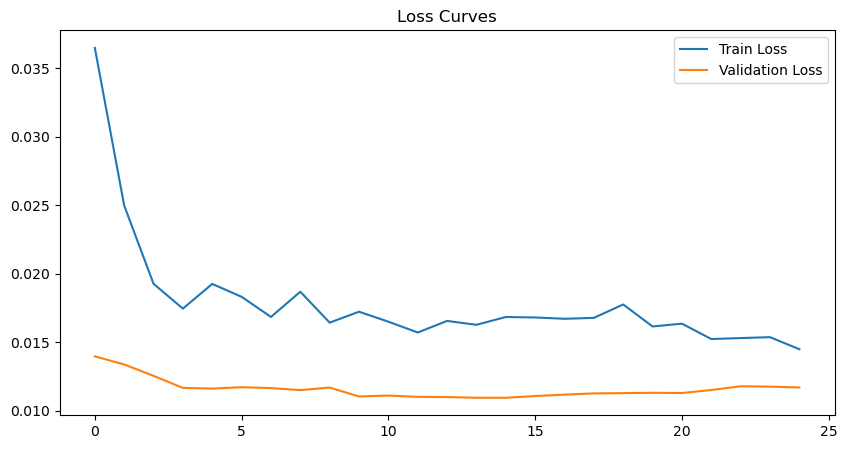

predictions: [-0.03712502  0.00123901 -0.02670901  0.00348756 -0.02315108]
actuals: [ 0.09090909  0.09090909  0.         -0.08333334  0.09090909]
correct: 27
total: 106


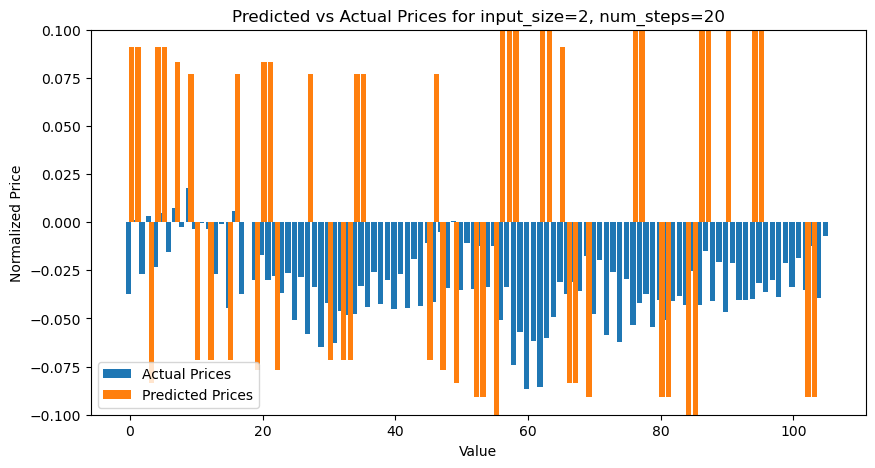

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


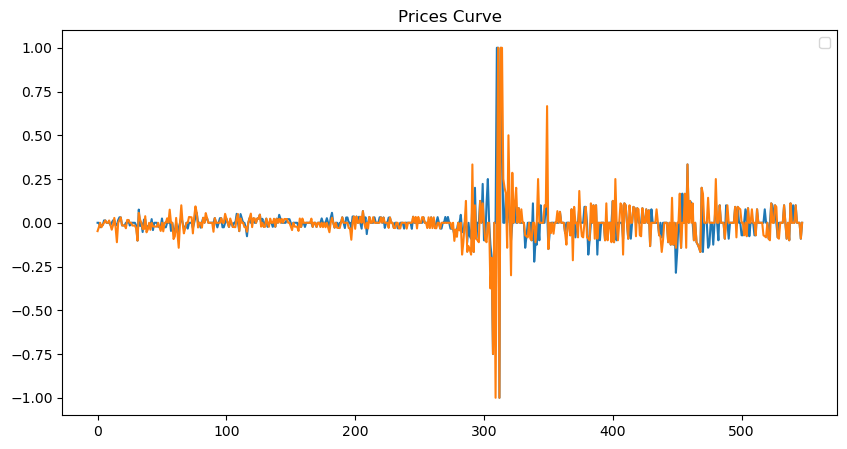

Epoch 1/50, Train Loss: 0.0376, Val Loss: 0.0328


Epoch 2/50, Train Loss: 0.0343, Val Loss: 0.0286


Epoch 3/50, Train Loss: 0.0321, Val Loss: 0.0251


Epoch 4/50, Train Loss: 0.0258, Val Loss: 0.0227


Epoch 5/50, Train Loss: 0.0241, Val Loss: 0.0207


Epoch 6/50, Train Loss: 0.0216, Val Loss: 0.0192


Epoch 7/50, Train Loss: 0.0225, Val Loss: 0.0180


Epoch 8/50, Train Loss: 0.0209, Val Loss: 0.0169


Epoch 9/50, Train Loss: 0.0242, Val Loss: 0.0160


Epoch 10/50, Train Loss: 0.0189, Val Loss: 0.0157


Epoch 11/50, Train Loss: 0.0174, Val Loss: 0.0155


Epoch 12/50, Train Loss: 0.0175, Val Loss: 0.0154


Epoch 13/50, Train Loss: 0.0169, Val Loss: 0.0150


Epoch 14/50, Train Loss: 0.0190, Val Loss: 0.0143


Epoch 15/50, Train Loss: 0.0165, Val Loss: 0.0141


Epoch 16/50, Train Loss: 0.0167, Val Loss: 0.0137


Epoch 17/50, Train Loss: 0.0164, Val Loss: 0.0135


Epoch 18/50, Train Loss: 0.0186, Val Loss: 0.0130


Epoch 19/50, Train Loss: 0.0168, Val Loss: 0.0127


Epoch 20/50, Train Loss: 0.0182, Val Loss: 0.0126


Epoch 21/50, Train Loss: 0.0164, Val Loss: 0.0129


Epoch 22/50, Train Loss: 0.0160, Val Loss: 0.0126


Epoch 23/50, Train Loss: 0.0158, Val Loss: 0.0121


Epoch 24/50, Train Loss: 0.0157, Val Loss: 0.0119


Epoch 25/50, Train Loss: 0.0166, Val Loss: 0.0120


Epoch 26/50, Train Loss: 0.0150, Val Loss: 0.0121


Epoch 27/50, Train Loss: 0.0155, Val Loss: 0.0120


Epoch 28/50, Train Loss: 0.0156, Val Loss: 0.0117


Epoch 29/50, Train Loss: 0.0157, Val Loss: 0.0116


Epoch 30/50, Train Loss: 0.0150, Val Loss: 0.0116


Epoch 31/50, Train Loss: 0.0149, Val Loss: 0.0115


Epoch 32/50, Train Loss: 0.0199, Val Loss: 0.0116


Epoch 33/50, Train Loss: 0.0156, Val Loss: 0.0118


Epoch 34/50, Train Loss: 0.0153, Val Loss: 0.0114


Epoch 35/50, Train Loss: 0.0172, Val Loss: 0.0112


Epoch 36/50, Train Loss: 0.0149, Val Loss: 0.0112


Epoch 37/50, Train Loss: 0.0162, Val Loss: 0.0111


Epoch 38/50, Train Loss: 0.0164, Val Loss: 0.0112


Epoch 39/50, Train Loss: 0.0146, Val Loss: 0.0113


Epoch 40/50, Train Loss: 0.0153, Val Loss: 0.0113


Epoch 41/50, Train Loss: 0.0170, Val Loss: 0.0114


Epoch 42/50, Train Loss: 0.0154, Val Loss: 0.0115


Epoch 43/50, Train Loss: 0.0148, Val Loss: 0.0116


Epoch 44/50, Train Loss: 0.0173, Val Loss: 0.0112


Epoch 45/50, Train Loss: 0.0148, Val Loss: 0.0111


Epoch 46/50, Train Loss: 0.0142, Val Loss: 0.0112


Epoch 47/50, Train Loss: 0.0145, Val Loss: 0.0114


Epoch 48/50, Train Loss: 0.0151, Val Loss: 0.0112


Epoch 49/50, Train Loss: 0.0148, Val Loss: 0.0111


Epoch 50/50, Train Loss: 0.0179, Val Loss: 0.0112


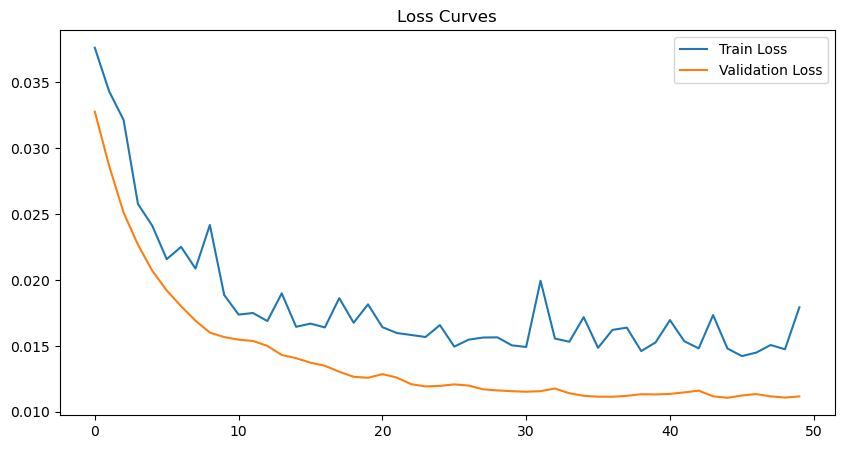

predictions: [-0.0091815   0.00720364  0.00387363  0.01344776  0.00695753]
actuals: [ 0.         -0.08333334  0.09090909  0.09090909  0.        ]
correct: 25
total: 104


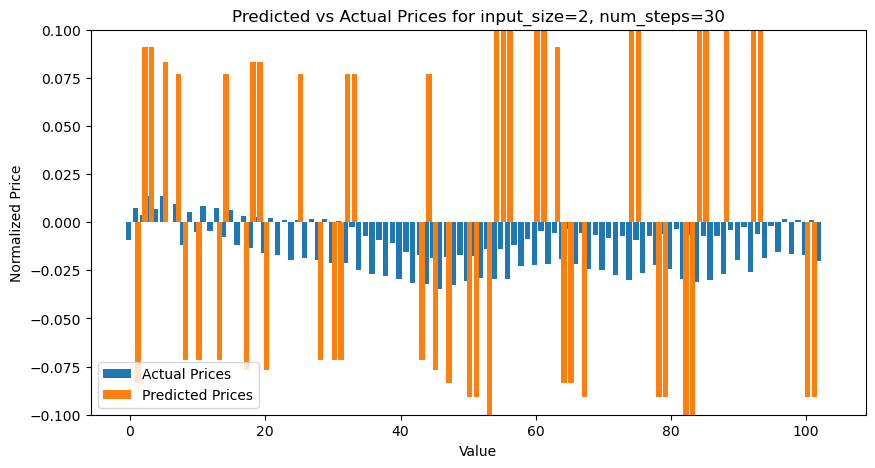

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


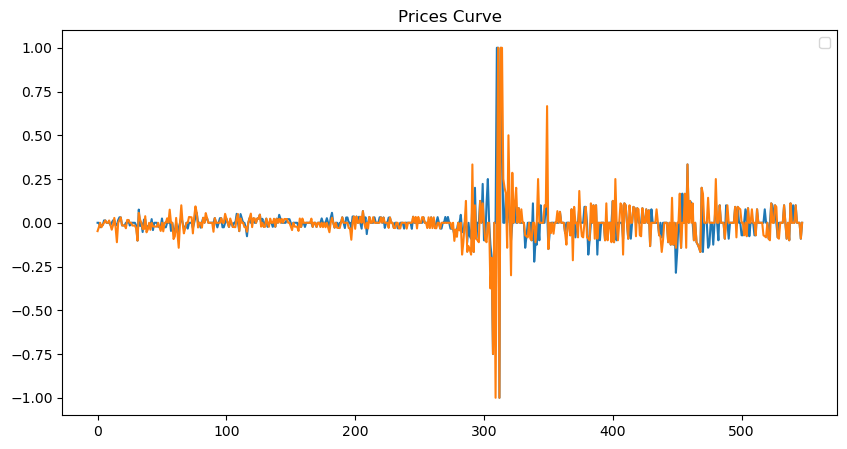

Epoch 1/50, Train Loss: 0.0282, Val Loss: 0.0182


Epoch 2/50, Train Loss: 0.0207, Val Loss: 0.0150


Epoch 3/50, Train Loss: 0.0201, Val Loss: 0.0140


Epoch 4/50, Train Loss: 0.0186, Val Loss: 0.0138


Epoch 5/50, Train Loss: 0.0175, Val Loss: 0.0140


Epoch 6/50, Train Loss: 0.0176, Val Loss: 0.0126


Epoch 7/50, Train Loss: 0.0253, Val Loss: 0.0118


Epoch 8/50, Train Loss: 0.0177, Val Loss: 0.0117


Epoch 9/50, Train Loss: 0.0171, Val Loss: 0.0115


Epoch 10/50, Train Loss: 0.0180, Val Loss: 0.0112


Epoch 11/50, Train Loss: 0.0213, Val Loss: 0.0108


Epoch 12/50, Train Loss: 0.0292, Val Loss: 0.0108


Epoch 13/50, Train Loss: 0.0171, Val Loss: 0.0110


Epoch 14/50, Train Loss: 0.0170, Val Loss: 0.0111


Epoch 15/50, Train Loss: 0.0216, Val Loss: 0.0111


Epoch 16/50, Train Loss: 0.0196, Val Loss: 0.0111


Epoch 17/50, Train Loss: 0.0209, Val Loss: 0.0111


Epoch 18/50, Train Loss: 0.0171, Val Loss: 0.0110


Epoch 19/50, Train Loss: 0.0184, Val Loss: 0.0111


Epoch 20/50, Train Loss: 0.0172, Val Loss: 0.0112


Epoch 21/50, Train Loss: 0.0162, Val Loss: 0.0112


Epoch 22/50, Train Loss: 0.0164, Val Loss: 0.0112
Early stopping triggered


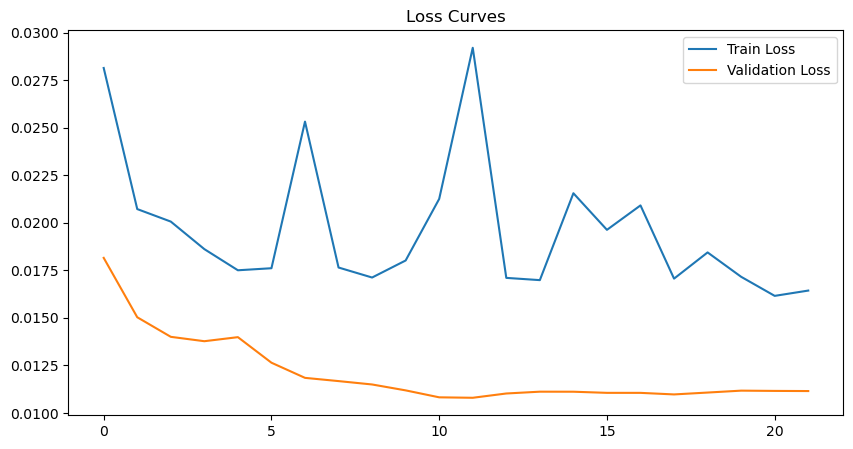

predictions: [0.01595577 0.00477419 0.02375372 0.00573227 0.03842915]
actuals: [0.09090909 0.09090909 0.         0.08333334 0.        ]
correct: 21
total: 102


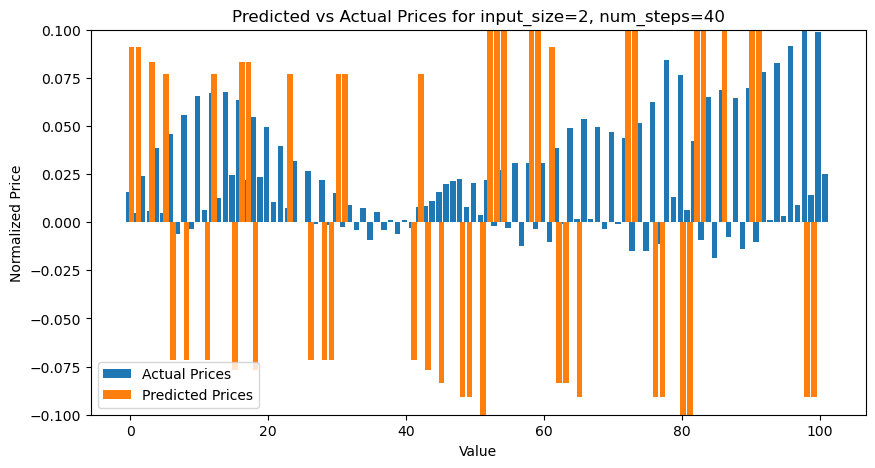

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


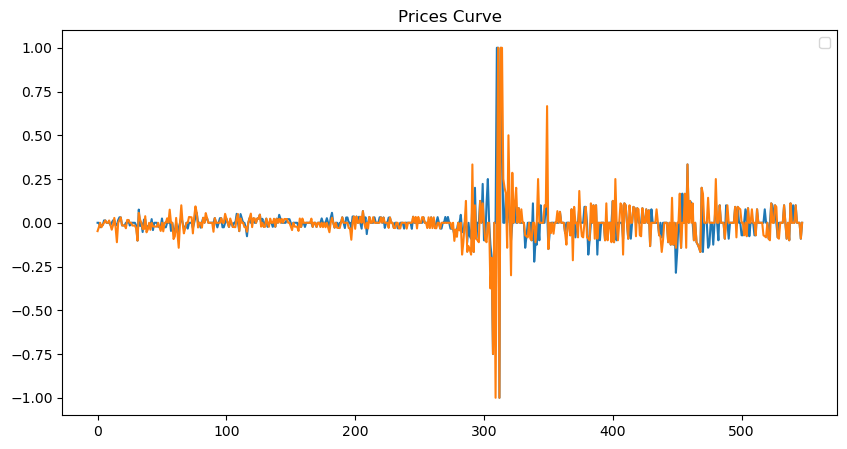

Epoch 1/50, Train Loss: 0.0314, Val Loss: 0.0221


Epoch 2/50, Train Loss: 0.0307, Val Loss: 0.0200


Epoch 3/50, Train Loss: 0.0216, Val Loss: 0.0180


Epoch 4/50, Train Loss: 0.0192, Val Loss: 0.0169


Epoch 5/50, Train Loss: 0.0262, Val Loss: 0.0148


Epoch 6/50, Train Loss: 0.0172, Val Loss: 0.0135


Epoch 7/50, Train Loss: 0.0180, Val Loss: 0.0136


Epoch 8/50, Train Loss: 0.0167, Val Loss: 0.0137


Epoch 9/50, Train Loss: 0.0167, Val Loss: 0.0138


Epoch 10/50, Train Loss: 0.0169, Val Loss: 0.0138


Epoch 11/50, Train Loss: 0.0163, Val Loss: 0.0143


Epoch 12/50, Train Loss: 0.0161, Val Loss: 0.0144


Epoch 13/50, Train Loss: 0.0161, Val Loss: 0.0145


Epoch 14/50, Train Loss: 0.0177, Val Loss: 0.0147


Epoch 15/50, Train Loss: 0.0236, Val Loss: 0.0145


Epoch 16/50, Train Loss: 0.0155, Val Loss: 0.0149
Early stopping triggered


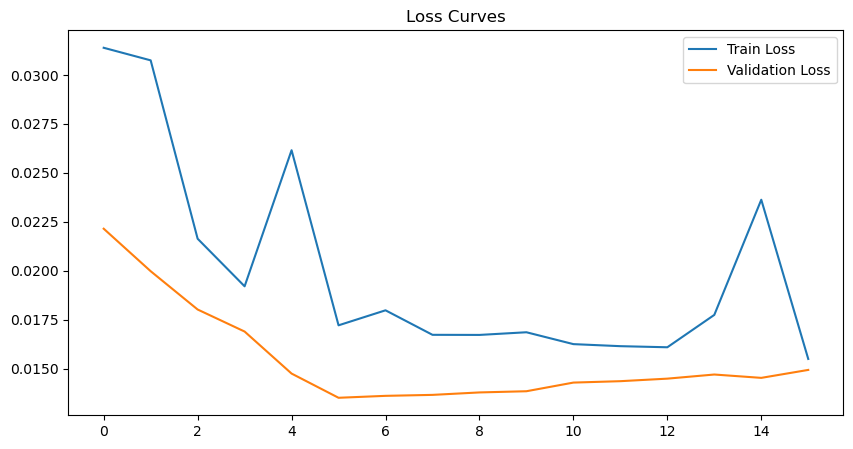

predictions: [ 0.0383043  -0.01190733  0.0480419  -0.02149704  0.05491701]
actuals: [ 0.          0.08333334  0.          0.07692308 -0.07142857]
correct: 23
total: 100


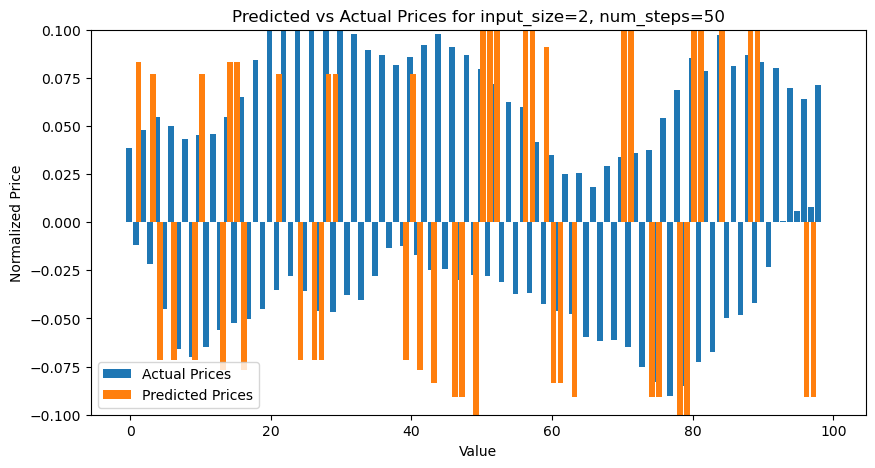

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


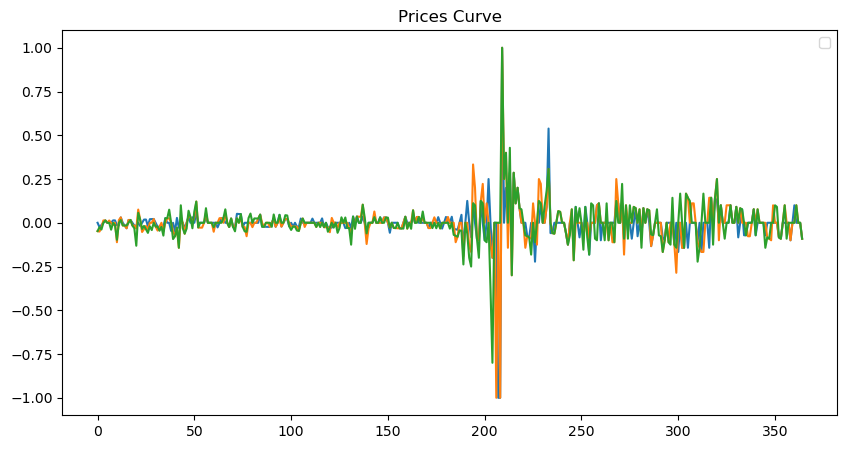

Epoch 1/50, Train Loss: 0.0247, Val Loss: 0.0183


Epoch 2/50, Train Loss: 0.0186, Val Loss: 0.0170


Epoch 3/50, Train Loss: 0.0202, Val Loss: 0.0159


Epoch 4/50, Train Loss: 0.0162, Val Loss: 0.0148


Epoch 5/50, Train Loss: 0.0179, Val Loss: 0.0137


Epoch 6/50, Train Loss: 0.0157, Val Loss: 0.0127


Epoch 7/50, Train Loss: 0.0145, Val Loss: 0.0122


Epoch 8/50, Train Loss: 0.0156, Val Loss: 0.0121


Epoch 9/50, Train Loss: 0.0149, Val Loss: 0.0121


Epoch 10/50, Train Loss: 0.0145, Val Loss: 0.0122


Epoch 11/50, Train Loss: 0.0141, Val Loss: 0.0124


Epoch 12/50, Train Loss: 0.0144, Val Loss: 0.0124


Epoch 13/50, Train Loss: 0.0135, Val Loss: 0.0124


Epoch 14/50, Train Loss: 0.0148, Val Loss: 0.0125


Epoch 15/50, Train Loss: 0.0130, Val Loss: 0.0125


Epoch 16/50, Train Loss: 0.0140, Val Loss: 0.0124


Epoch 17/50, Train Loss: 0.0136, Val Loss: 0.0122


Epoch 18/50, Train Loss: 0.0157, Val Loss: 0.0120


Epoch 19/50, Train Loss: 0.0136, Val Loss: 0.0121


Epoch 20/50, Train Loss: 0.0138, Val Loss: 0.0121


Epoch 21/50, Train Loss: 0.0149, Val Loss: 0.0122


Epoch 22/50, Train Loss: 0.0134, Val Loss: 0.0121


Epoch 23/50, Train Loss: 0.0128, Val Loss: 0.0122


Epoch 24/50, Train Loss: 0.0136, Val Loss: 0.0122


Epoch 25/50, Train Loss: 0.0170, Val Loss: 0.0123


Epoch 26/50, Train Loss: 0.0144, Val Loss: 0.0123


Epoch 27/50, Train Loss: 0.0138, Val Loss: 0.0122


Epoch 28/50, Train Loss: 0.0131, Val Loss: 0.0123
Early stopping triggered


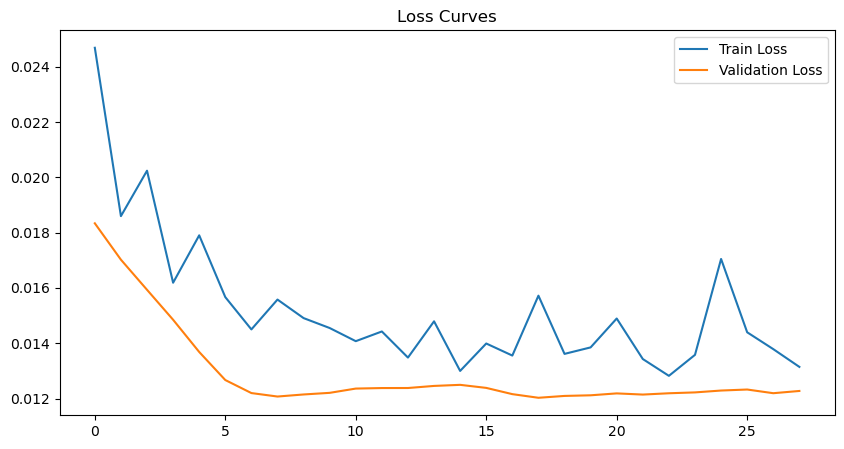

predictions: [ 0.0013793   0.03825486  0.06505684 -0.0011094   0.03682266]
actuals: [0. 0. 0. 0. 0.]
correct: 27
total: 111


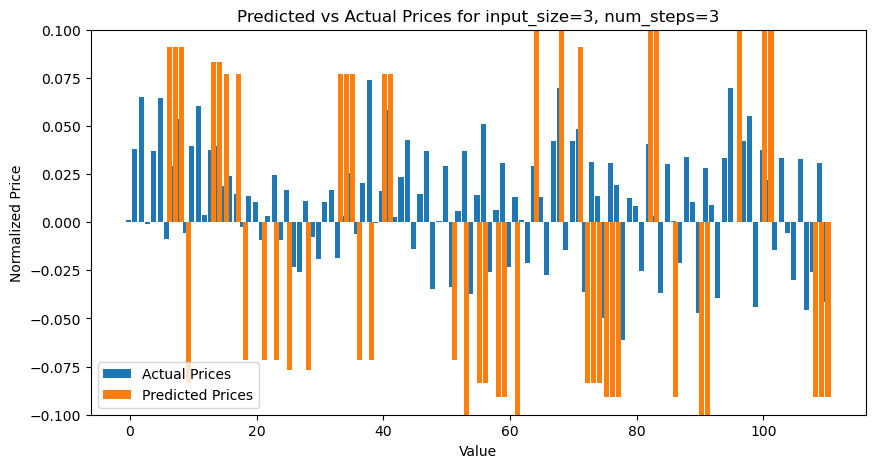

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


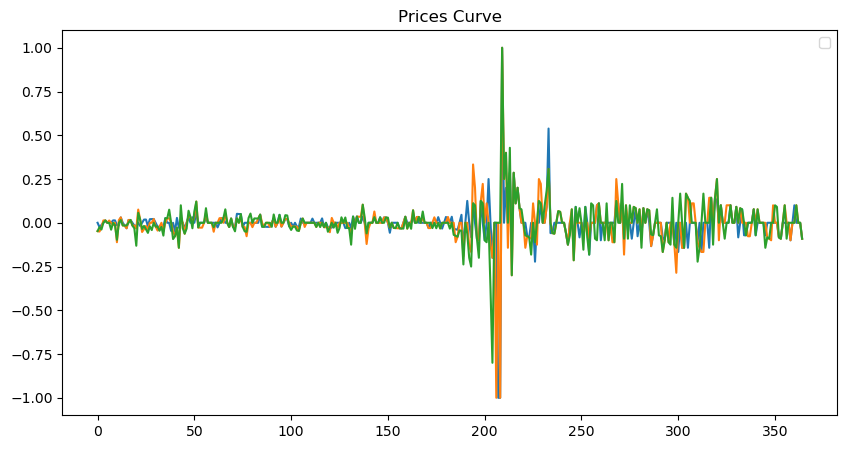

Epoch 1/50, Train Loss: 0.0268, Val Loss: 0.0196


Epoch 2/50, Train Loss: 0.0217, Val Loss: 0.0175


Epoch 3/50, Train Loss: 0.0211, Val Loss: 0.0165


Epoch 4/50, Train Loss: 0.0215, Val Loss: 0.0157


Epoch 5/50, Train Loss: 0.0184, Val Loss: 0.0152


Epoch 6/50, Train Loss: 0.0162, Val Loss: 0.0148


Epoch 7/50, Train Loss: 0.0153, Val Loss: 0.0145


Epoch 8/50, Train Loss: 0.0151, Val Loss: 0.0140


Epoch 9/50, Train Loss: 0.0147, Val Loss: 0.0134


Epoch 10/50, Train Loss: 0.0153, Val Loss: 0.0130


Epoch 11/50, Train Loss: 0.0168, Val Loss: 0.0126


Epoch 12/50, Train Loss: 0.0147, Val Loss: 0.0125


Epoch 13/50, Train Loss: 0.0148, Val Loss: 0.0124


Epoch 14/50, Train Loss: 0.0149, Val Loss: 0.0124


Epoch 15/50, Train Loss: 0.0140, Val Loss: 0.0124


Epoch 16/50, Train Loss: 0.0168, Val Loss: 0.0125


Epoch 17/50, Train Loss: 0.0144, Val Loss: 0.0126


Epoch 18/50, Train Loss: 0.0143, Val Loss: 0.0126


Epoch 19/50, Train Loss: 0.0138, Val Loss: 0.0126


Epoch 20/50, Train Loss: 0.0143, Val Loss: 0.0126


Epoch 21/50, Train Loss: 0.0144, Val Loss: 0.0126


Epoch 22/50, Train Loss: 0.0164, Val Loss: 0.0128


Epoch 23/50, Train Loss: 0.0150, Val Loss: 0.0131


Epoch 24/50, Train Loss: 0.0141, Val Loss: 0.0132
Early stopping triggered


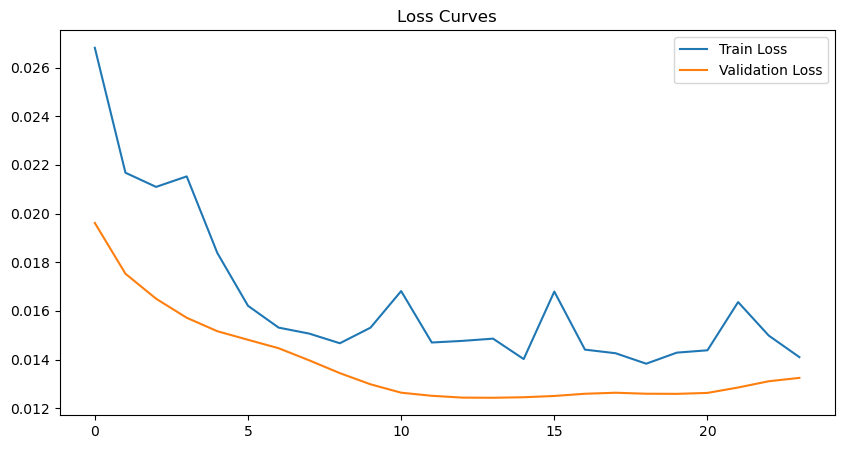

predictions: [-0.02477582 -0.01239271  0.04174577 -0.03116491 -0.01267423]
actuals: [0.         0.         0.         0.09090909 0.09090909]
correct: 25
total: 108


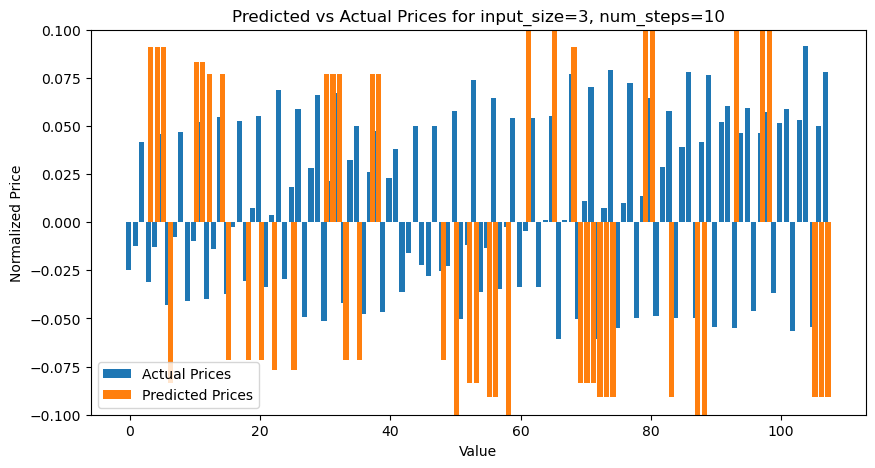

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


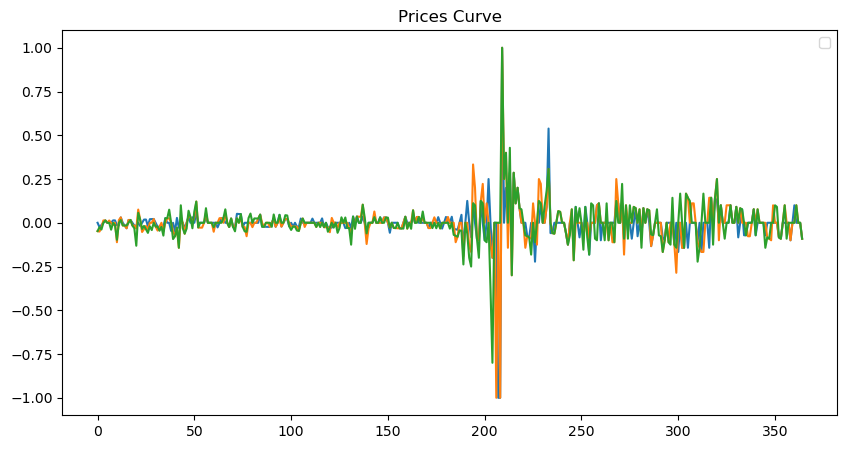

Epoch 1/50, Train Loss: 0.0289, Val Loss: 0.0612


Epoch 2/50, Train Loss: 0.0264, Val Loss: 0.0549


Epoch 3/50, Train Loss: 0.0193, Val Loss: 0.0454


Epoch 4/50, Train Loss: 0.0180, Val Loss: 0.0336


Epoch 5/50, Train Loss: 0.0167, Val Loss: 0.0268


Epoch 6/50, Train Loss: 0.0172, Val Loss: 0.0254


Epoch 7/50, Train Loss: 0.0163, Val Loss: 0.0256


Epoch 8/50, Train Loss: 0.0185, Val Loss: 0.0274


Epoch 9/50, Train Loss: 0.0176, Val Loss: 0.0287


Epoch 10/50, Train Loss: 0.0171, Val Loss: 0.0270


Epoch 11/50, Train Loss: 0.0166, Val Loss: 0.0266


Epoch 12/50, Train Loss: 0.0213, Val Loss: 0.0262


Epoch 13/50, Train Loss: 0.0147, Val Loss: 0.0269


Epoch 14/50, Train Loss: 0.0143, Val Loss: 0.0251


Epoch 15/50, Train Loss: 0.0142, Val Loss: 0.0260


Epoch 16/50, Train Loss: 0.0143, Val Loss: 0.0262


Epoch 17/50, Train Loss: 0.0178, Val Loss: 0.0249


Epoch 18/50, Train Loss: 0.0139, Val Loss: 0.0241


Epoch 19/50, Train Loss: 0.0168, Val Loss: 0.0247


Epoch 20/50, Train Loss: 0.0143, Val Loss: 0.0266


Epoch 21/50, Train Loss: 0.0136, Val Loss: 0.0278


Epoch 22/50, Train Loss: 0.0134, Val Loss: 0.0271


Epoch 23/50, Train Loss: 0.0137, Val Loss: 0.0263


Epoch 24/50, Train Loss: 0.0140, Val Loss: 0.0279


Epoch 25/50, Train Loss: 0.0137, Val Loss: 0.0277


Epoch 26/50, Train Loss: 0.0149, Val Loss: 0.0269


Epoch 27/50, Train Loss: 0.0217, Val Loss: 0.0273


Epoch 28/50, Train Loss: 0.0135, Val Loss: 0.0284
Early stopping triggered


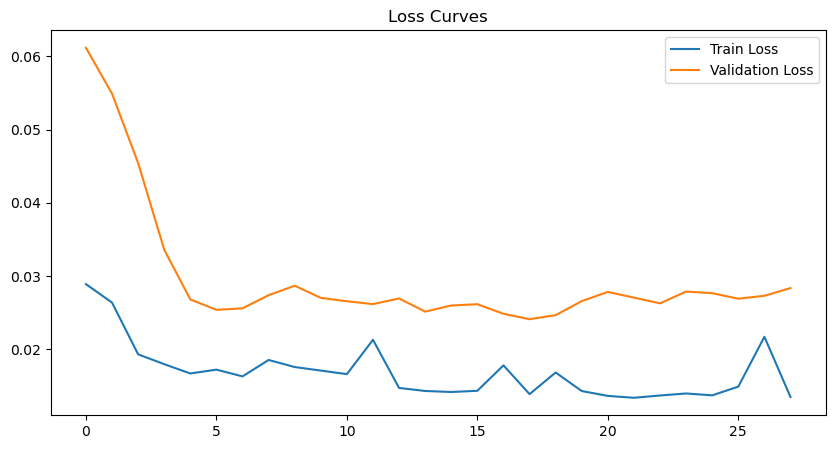

predictions: [0.31707793 0.05865423 0.14946024 0.28618908 0.04339882]
actuals: [ 0.09090909  0.09090909  0.09090909 -0.08333334  0.        ]
correct: 19
total: 105


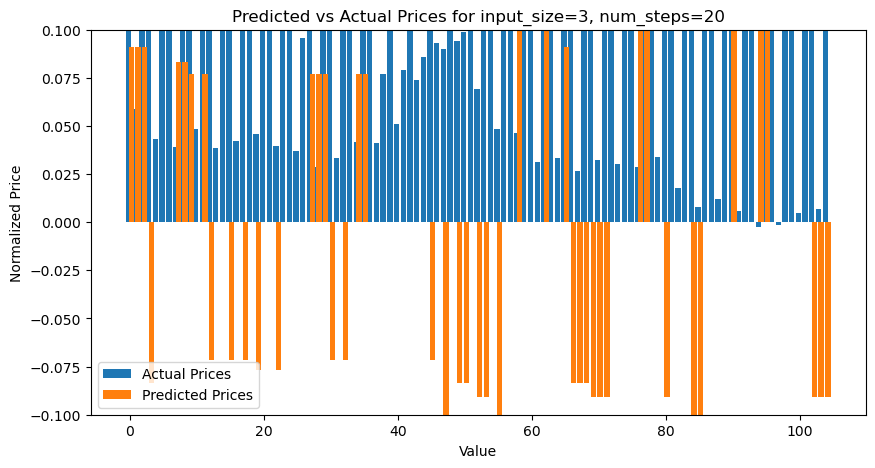

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


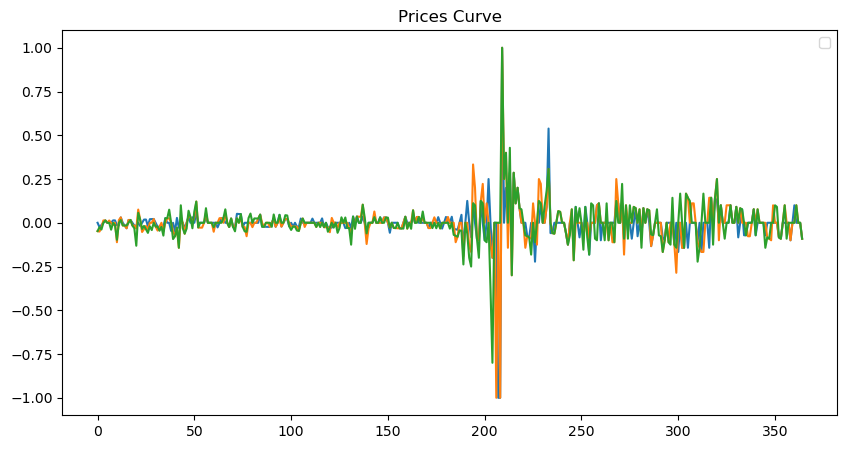

Epoch 1/50, Train Loss: 0.0292, Val Loss: 0.0296


Epoch 2/50, Train Loss: 0.0241, Val Loss: 0.0259


Epoch 3/50, Train Loss: 0.0246, Val Loss: 0.0236


Epoch 4/50, Train Loss: 0.0249, Val Loss: 0.0226


Epoch 5/50, Train Loss: 0.0190, Val Loss: 0.0220


Epoch 6/50, Train Loss: 0.0179, Val Loss: 0.0222


Epoch 7/50, Train Loss: 0.0182, Val Loss: 0.0229


Epoch 8/50, Train Loss: 0.0169, Val Loss: 0.0232


Epoch 9/50, Train Loss: 0.0208, Val Loss: 0.0225


Epoch 10/50, Train Loss: 0.0160, Val Loss: 0.0220


Epoch 11/50, Train Loss: 0.0146, Val Loss: 0.0221


Epoch 12/50, Train Loss: 0.0154, Val Loss: 0.0217


Epoch 13/50, Train Loss: 0.0154, Val Loss: 0.0207


Epoch 14/50, Train Loss: 0.0160, Val Loss: 0.0199


Epoch 15/50, Train Loss: 0.0172, Val Loss: 0.0202


Epoch 16/50, Train Loss: 0.0192, Val Loss: 0.0190


Epoch 17/50, Train Loss: 0.0137, Val Loss: 0.0183


Epoch 18/50, Train Loss: 0.0146, Val Loss: 0.0177


Epoch 19/50, Train Loss: 0.0239, Val Loss: 0.0175


Epoch 20/50, Train Loss: 0.0137, Val Loss: 0.0176


Epoch 21/50, Train Loss: 0.0140, Val Loss: 0.0185


Epoch 22/50, Train Loss: 0.0141, Val Loss: 0.0187


Epoch 23/50, Train Loss: 0.0183, Val Loss: 0.0182


Epoch 24/50, Train Loss: 0.0153, Val Loss: 0.0184


Epoch 25/50, Train Loss: 0.0138, Val Loss: 0.0190


Epoch 26/50, Train Loss: 0.0140, Val Loss: 0.0189


Epoch 27/50, Train Loss: 0.0136, Val Loss: 0.0189


Epoch 28/50, Train Loss: 0.0143, Val Loss: 0.0187


Epoch 29/50, Train Loss: 0.0139, Val Loss: 0.0179
Early stopping triggered


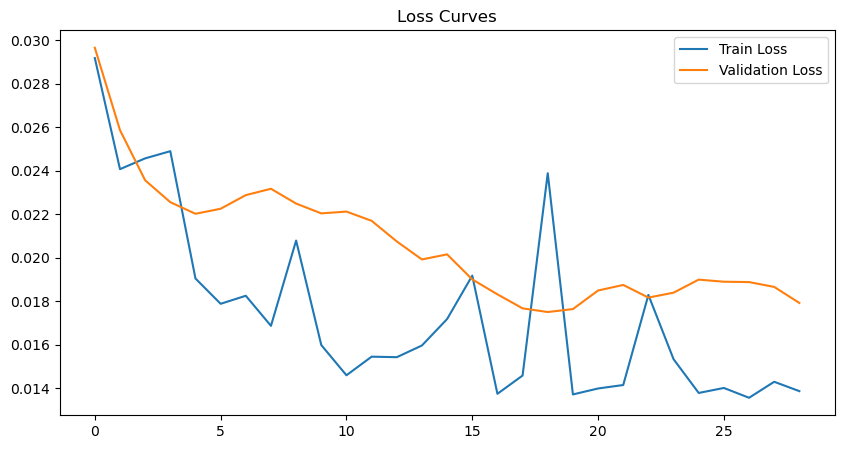

predictions: [-0.07165559  0.1428188  -0.04840628 -0.06990167  0.14302984]
actuals: [-0.08333334  0.          0.          0.          0.08333334]
correct: 24
total: 102


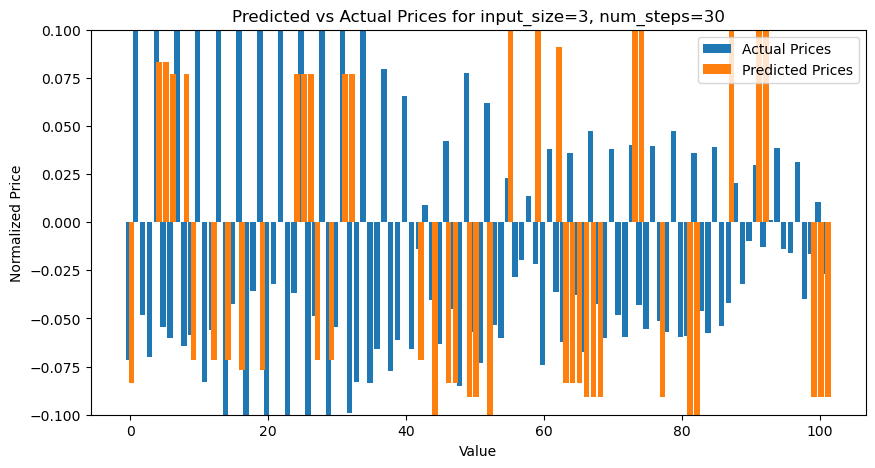

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


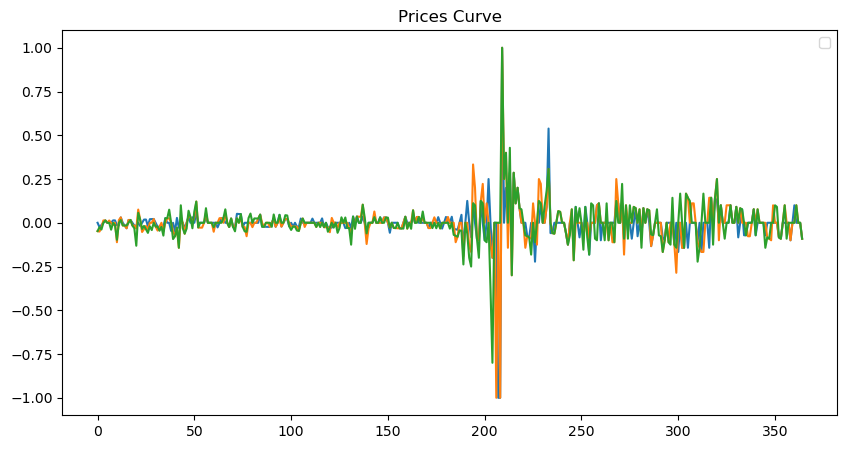

Epoch 1/50, Train Loss: 0.0653, Val Loss: 0.0130


Epoch 2/50, Train Loss: 0.0172, Val Loss: 0.0124


Epoch 3/50, Train Loss: 0.0186, Val Loss: 0.0121


Epoch 4/50, Train Loss: 0.0173, Val Loss: 0.0118


Epoch 5/50, Train Loss: 0.0149, Val Loss: 0.0115


Epoch 6/50, Train Loss: 0.0144, Val Loss: 0.0112


Epoch 7/50, Train Loss: 0.0148, Val Loss: 0.0110


Epoch 8/50, Train Loss: 0.0152, Val Loss: 0.0111


Epoch 9/50, Train Loss: 0.0170, Val Loss: 0.0114


Epoch 10/50, Train Loss: 0.0146, Val Loss: 0.0116


Epoch 11/50, Train Loss: 0.0157, Val Loss: 0.0117


Epoch 12/50, Train Loss: 0.0146, Val Loss: 0.0116


Epoch 13/50, Train Loss: 0.0156, Val Loss: 0.0115


Epoch 14/50, Train Loss: 0.0148, Val Loss: 0.0113


Epoch 15/50, Train Loss: 0.0149, Val Loss: 0.0112


Epoch 16/50, Train Loss: 0.0144, Val Loss: 0.0109


Epoch 17/50, Train Loss: 0.0141, Val Loss: 0.0109


Epoch 18/50, Train Loss: 0.0144, Val Loss: 0.0109


Epoch 19/50, Train Loss: 0.0163, Val Loss: 0.0110


Epoch 20/50, Train Loss: 0.0142, Val Loss: 0.0110


Epoch 21/50, Train Loss: 0.0160, Val Loss: 0.0110


Epoch 22/50, Train Loss: 0.0142, Val Loss: 0.0109


Epoch 23/50, Train Loss: 0.0172, Val Loss: 0.0108


Epoch 24/50, Train Loss: 0.0151, Val Loss: 0.0108


Epoch 25/50, Train Loss: 0.0150, Val Loss: 0.0108


Epoch 26/50, Train Loss: 0.0146, Val Loss: 0.0109


Epoch 27/50, Train Loss: 0.0155, Val Loss: 0.0109


Epoch 28/50, Train Loss: 0.0586, Val Loss: 0.0110


Epoch 29/50, Train Loss: 0.0144, Val Loss: 0.0111


Epoch 30/50, Train Loss: 0.0141, Val Loss: 0.0112


Epoch 31/50, Train Loss: 0.0144, Val Loss: 0.0113


Epoch 32/50, Train Loss: 0.0156, Val Loss: 0.0112


Epoch 33/50, Train Loss: 0.0192, Val Loss: 0.0110


Epoch 34/50, Train Loss: 0.0151, Val Loss: 0.0108


Epoch 35/50, Train Loss: 0.0142, Val Loss: 0.0107


Epoch 36/50, Train Loss: 0.0219, Val Loss: 0.0107


Epoch 37/50, Train Loss: 0.0182, Val Loss: 0.0108


Epoch 38/50, Train Loss: 0.0151, Val Loss: 0.0109


Epoch 39/50, Train Loss: 0.0144, Val Loss: 0.0110


Epoch 40/50, Train Loss: 0.0141, Val Loss: 0.0111


Epoch 41/50, Train Loss: 0.0156, Val Loss: 0.0110


Epoch 42/50, Train Loss: 0.0137, Val Loss: 0.0111


Epoch 43/50, Train Loss: 0.0144, Val Loss: 0.0113


Epoch 44/50, Train Loss: 0.0138, Val Loss: 0.0113


Epoch 45/50, Train Loss: 0.0256, Val Loss: 0.0113


Epoch 46/50, Train Loss: 0.0154, Val Loss: 0.0112
Early stopping triggered


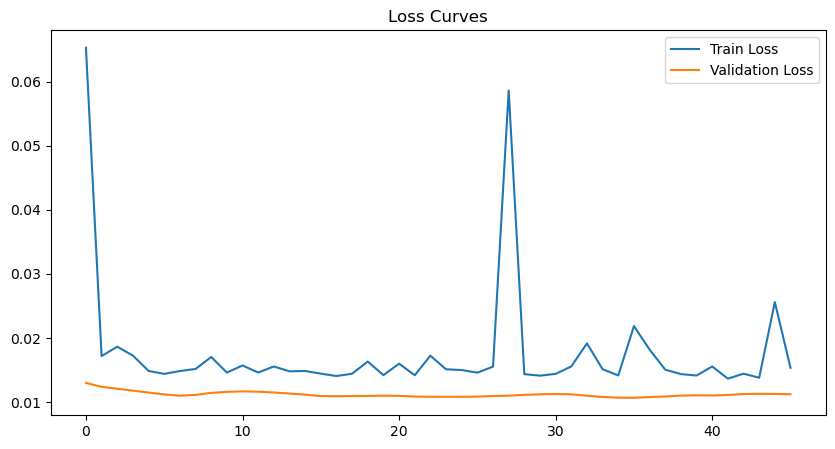

predictions: [ 0.01748274 -0.02711252 -0.00845592  0.02051684 -0.03186783]
actuals: [0.         0.08333334 0.08333334 0.07692308 0.        ]
correct: 23
total: 99


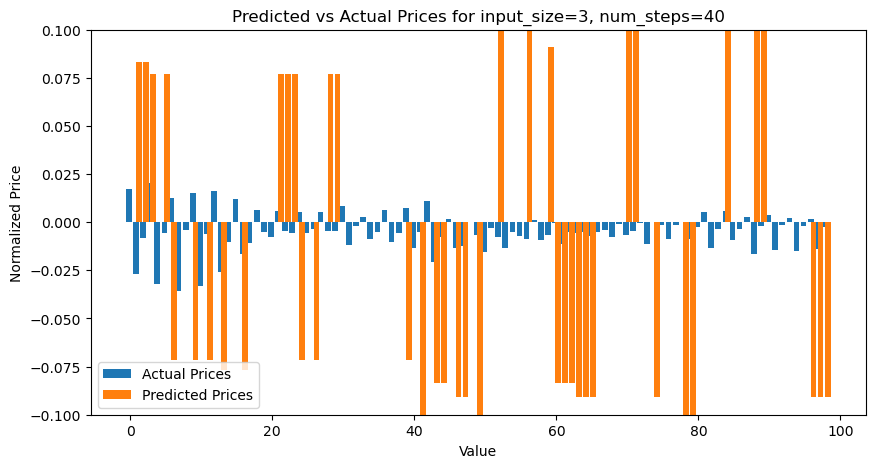

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


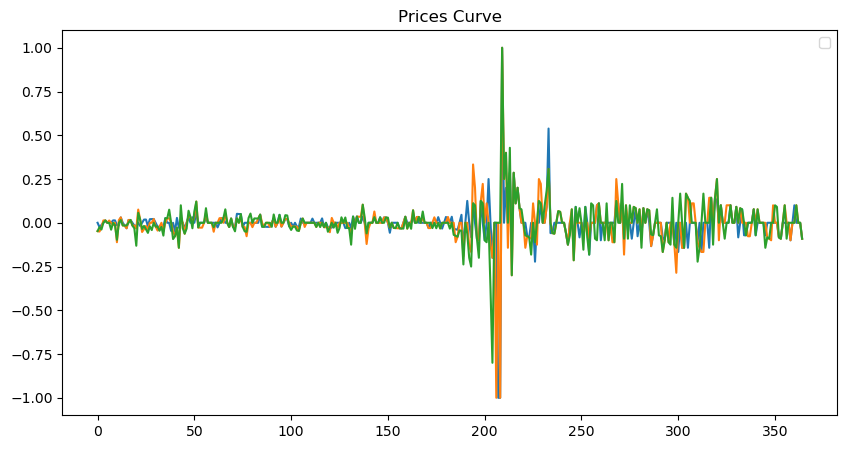

Epoch 1/50, Train Loss: 0.0312, Val Loss: 0.0200


Epoch 2/50, Train Loss: 0.0251, Val Loss: 0.0178


Epoch 3/50, Train Loss: 0.0227, Val Loss: 0.0162


Epoch 4/50, Train Loss: 0.0212, Val Loss: 0.0148


Epoch 5/50, Train Loss: 0.0209, Val Loss: 0.0137


Epoch 6/50, Train Loss: 0.0193, Val Loss: 0.0127


Epoch 7/50, Train Loss: 0.0187, Val Loss: 0.0120


Epoch 8/50, Train Loss: 0.0192, Val Loss: 0.0115


Epoch 9/50, Train Loss: 0.0187, Val Loss: 0.0113


Epoch 10/50, Train Loss: 0.0182, Val Loss: 0.0113


Epoch 11/50, Train Loss: 0.0183, Val Loss: 0.0112


Epoch 12/50, Train Loss: 0.0178, Val Loss: 0.0112


Epoch 13/50, Train Loss: 0.0184, Val Loss: 0.0111


Epoch 14/50, Train Loss: 0.0173, Val Loss: 0.0111


Epoch 15/50, Train Loss: 0.0179, Val Loss: 0.0110


Epoch 16/50, Train Loss: 0.0176, Val Loss: 0.0110


Epoch 17/50, Train Loss: 0.0177, Val Loss: 0.0110


Epoch 18/50, Train Loss: 0.0175, Val Loss: 0.0111


Epoch 19/50, Train Loss: 0.0174, Val Loss: 0.0111


Epoch 20/50, Train Loss: 0.0173, Val Loss: 0.0110


Epoch 21/50, Train Loss: 0.0170, Val Loss: 0.0110


Epoch 22/50, Train Loss: 0.0174, Val Loss: 0.0109


Epoch 23/50, Train Loss: 0.0177, Val Loss: 0.0109


Epoch 24/50, Train Loss: 0.0171, Val Loss: 0.0110


Epoch 25/50, Train Loss: 0.0179, Val Loss: 0.0110


Epoch 26/50, Train Loss: 0.0174, Val Loss: 0.0112


Epoch 27/50, Train Loss: 0.0175, Val Loss: 0.0113


Epoch 28/50, Train Loss: 0.0173, Val Loss: 0.0113


Epoch 29/50, Train Loss: 0.0169, Val Loss: 0.0113


Epoch 30/50, Train Loss: 0.0168, Val Loss: 0.0113


Epoch 31/50, Train Loss: 0.0168, Val Loss: 0.0111


Epoch 32/50, Train Loss: 0.0172, Val Loss: 0.0109


Epoch 33/50, Train Loss: 0.0172, Val Loss: 0.0108


Epoch 34/50, Train Loss: 0.0168, Val Loss: 0.0109


Epoch 35/50, Train Loss: 0.0167, Val Loss: 0.0109


Epoch 36/50, Train Loss: 0.0172, Val Loss: 0.0108


Epoch 37/50, Train Loss: 0.0165, Val Loss: 0.0107


Epoch 38/50, Train Loss: 0.0175, Val Loss: 0.0106


Epoch 39/50, Train Loss: 0.0166, Val Loss: 0.0107


Epoch 40/50, Train Loss: 0.0164, Val Loss: 0.0106


Epoch 41/50, Train Loss: 0.0168, Val Loss: 0.0107


Epoch 42/50, Train Loss: 0.0163, Val Loss: 0.0107


Epoch 43/50, Train Loss: 0.0161, Val Loss: 0.0107


Epoch 44/50, Train Loss: 0.0162, Val Loss: 0.0106


Epoch 45/50, Train Loss: 0.0161, Val Loss: 0.0105


Epoch 46/50, Train Loss: 0.0165, Val Loss: 0.0105


Epoch 47/50, Train Loss: 0.0166, Val Loss: 0.0105


Epoch 48/50, Train Loss: 0.0162, Val Loss: 0.0104


Epoch 49/50, Train Loss: 0.0161, Val Loss: 0.0102


Epoch 50/50, Train Loss: 0.0165, Val Loss: 0.0101


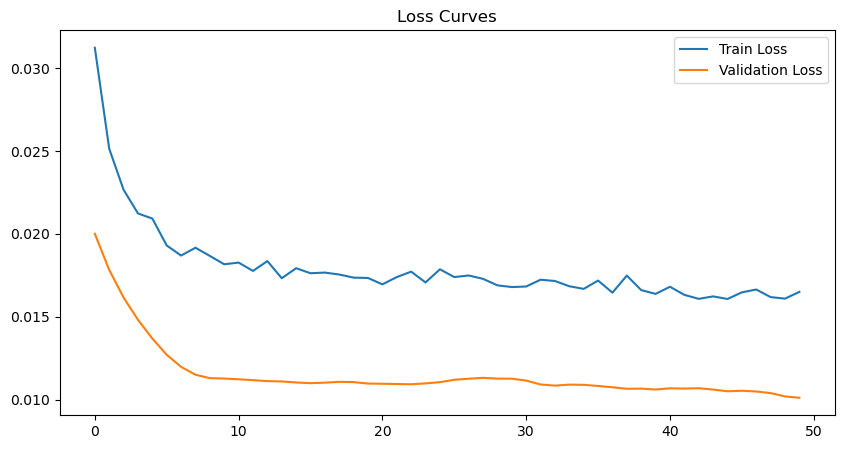

predictions: [-0.0449108  -0.01380375 -0.02596597 -0.03812864 -0.0095761 ]
actuals: [ 0.07692308  0.          0.07692308 -0.07142857  0.        ]
correct: 25
total: 96


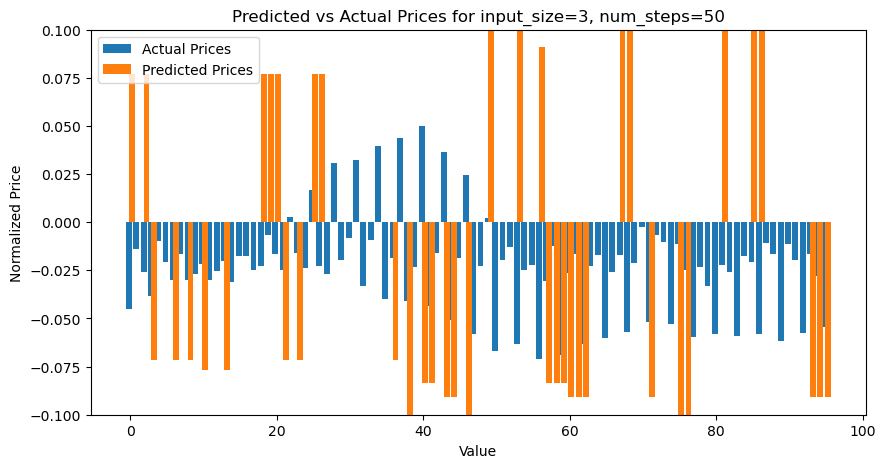

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


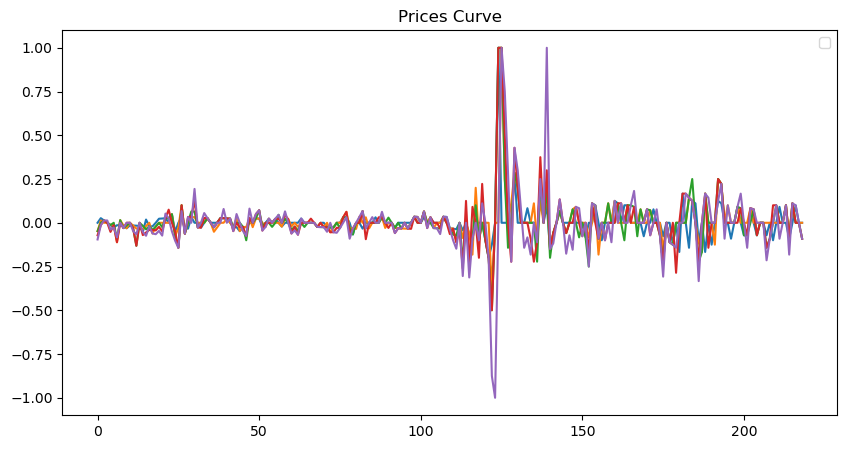

Epoch 1/50, Train Loss: 0.0283, Val Loss: 0.0231


Epoch 2/50, Train Loss: 0.0230, Val Loss: 0.0222


Epoch 3/50, Train Loss: 0.0253, Val Loss: 0.0215


Epoch 4/50, Train Loss: 0.0222, Val Loss: 0.0209


Epoch 5/50, Train Loss: 0.0218, Val Loss: 0.0204


Epoch 6/50, Train Loss: 0.0199, Val Loss: 0.0200


Epoch 7/50, Train Loss: 0.0197, Val Loss: 0.0197


Epoch 8/50, Train Loss: 0.0202, Val Loss: 0.0194


Epoch 9/50, Train Loss: 0.0199, Val Loss: 0.0191


Epoch 10/50, Train Loss: 0.0215, Val Loss: 0.0188


Epoch 11/50, Train Loss: 0.0221, Val Loss: 0.0186


Epoch 12/50, Train Loss: 0.0186, Val Loss: 0.0184


Epoch 13/50, Train Loss: 0.0180, Val Loss: 0.0183


Epoch 14/50, Train Loss: 0.0187, Val Loss: 0.0181


Epoch 15/50, Train Loss: 0.0187, Val Loss: 0.0180


Epoch 16/50, Train Loss: 0.0174, Val Loss: 0.0180


Epoch 17/50, Train Loss: 0.0174, Val Loss: 0.0179


Epoch 18/50, Train Loss: 0.0172, Val Loss: 0.0178


Epoch 19/50, Train Loss: 0.0191, Val Loss: 0.0177


Epoch 20/50, Train Loss: 0.0167, Val Loss: 0.0177


Epoch 21/50, Train Loss: 0.0184, Val Loss: 0.0176


Epoch 22/50, Train Loss: 0.0203, Val Loss: 0.0175


Epoch 23/50, Train Loss: 0.0164, Val Loss: 0.0175


Epoch 24/50, Train Loss: 0.0177, Val Loss: 0.0174


Epoch 25/50, Train Loss: 0.0183, Val Loss: 0.0174


Epoch 26/50, Train Loss: 0.0162, Val Loss: 0.0174


Epoch 27/50, Train Loss: 0.0164, Val Loss: 0.0173


Epoch 28/50, Train Loss: 0.0163, Val Loss: 0.0173


Epoch 29/50, Train Loss: 0.0192, Val Loss: 0.0173


Epoch 30/50, Train Loss: 0.0167, Val Loss: 0.0173


Epoch 31/50, Train Loss: 0.0178, Val Loss: 0.0172


Epoch 32/50, Train Loss: 0.0162, Val Loss: 0.0172


Epoch 33/50, Train Loss: 0.0160, Val Loss: 0.0172


Epoch 34/50, Train Loss: 0.0155, Val Loss: 0.0172


Epoch 35/50, Train Loss: 0.0155, Val Loss: 0.0171


Epoch 36/50, Train Loss: 0.0183, Val Loss: 0.0171


Epoch 37/50, Train Loss: 0.0189, Val Loss: 0.0170


Epoch 38/50, Train Loss: 0.0179, Val Loss: 0.0170


Epoch 39/50, Train Loss: 0.0153, Val Loss: 0.0170


Epoch 40/50, Train Loss: 0.0158, Val Loss: 0.0169


Epoch 41/50, Train Loss: 0.0147, Val Loss: 0.0169


Epoch 42/50, Train Loss: 0.0152, Val Loss: 0.0169


Epoch 43/50, Train Loss: 0.0173, Val Loss: 0.0169


Epoch 44/50, Train Loss: 0.0153, Val Loss: 0.0168


Epoch 45/50, Train Loss: 0.0154, Val Loss: 0.0168


Epoch 46/50, Train Loss: 0.0177, Val Loss: 0.0168


Epoch 47/50, Train Loss: 0.0153, Val Loss: 0.0169


Epoch 48/50, Train Loss: 0.0148, Val Loss: 0.0169


Epoch 49/50, Train Loss: 0.0145, Val Loss: 0.0169


Epoch 50/50, Train Loss: 0.0154, Val Loss: 0.0168


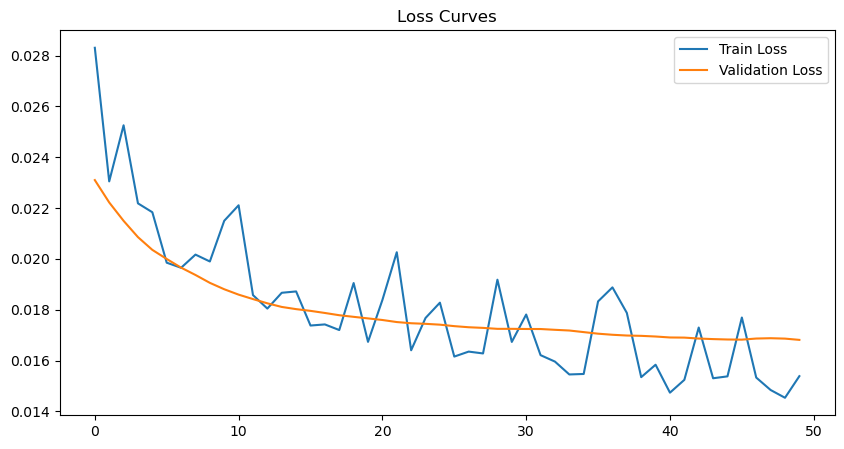

predictions: [0.04334264 0.00292747 0.02191341 0.02335336 0.04279272]
actuals: [0. 0. 0. 0. 0.]
correct: 22
total: 110


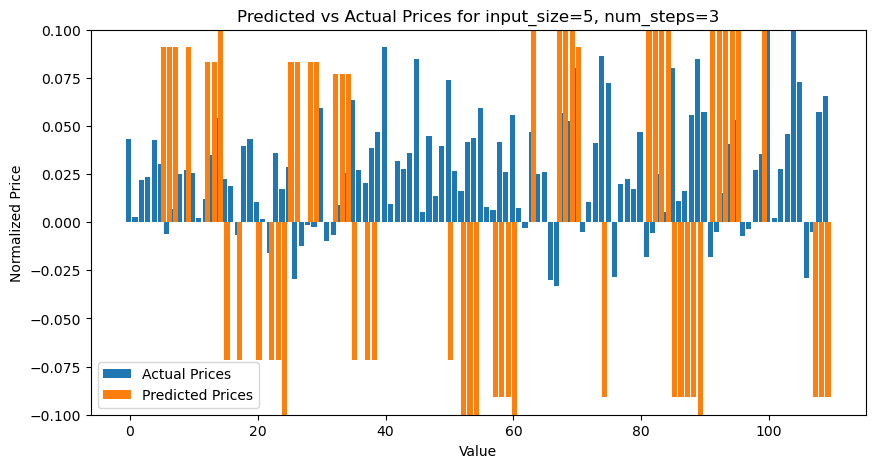

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


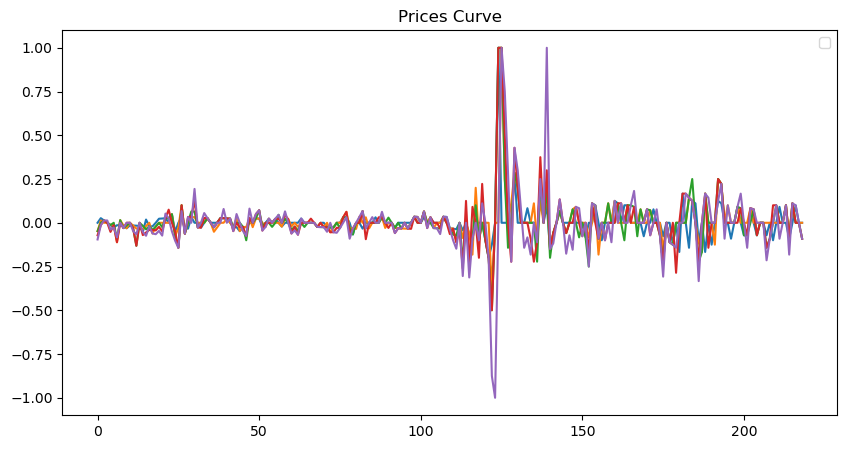

Epoch 1/50, Train Loss: 0.0293, Val Loss: 0.0221


Epoch 2/50, Train Loss: 0.0284, Val Loss: 0.0209


Epoch 3/50, Train Loss: 0.0247, Val Loss: 0.0199


Epoch 4/50, Train Loss: 0.0246, Val Loss: 0.0193


Epoch 5/50, Train Loss: 0.0248, Val Loss: 0.0188


Epoch 6/50, Train Loss: 0.0226, Val Loss: 0.0183


Epoch 7/50, Train Loss: 0.0259, Val Loss: 0.0180


Epoch 8/50, Train Loss: 0.0236, Val Loss: 0.0177


Epoch 9/50, Train Loss: 0.0234, Val Loss: 0.0174


Epoch 10/50, Train Loss: 0.0237, Val Loss: 0.0172


Epoch 11/50, Train Loss: 0.0211, Val Loss: 0.0171


Epoch 12/50, Train Loss: 0.0243, Val Loss: 0.0169


Epoch 13/50, Train Loss: 0.0207, Val Loss: 0.0168


Epoch 14/50, Train Loss: 0.0237, Val Loss: 0.0165


Epoch 15/50, Train Loss: 0.0202, Val Loss: 0.0165


Epoch 16/50, Train Loss: 0.0222, Val Loss: 0.0164


Epoch 17/50, Train Loss: 0.0185, Val Loss: 0.0162


Epoch 18/50, Train Loss: 0.0215, Val Loss: 0.0161


Epoch 19/50, Train Loss: 0.0180, Val Loss: 0.0161


Epoch 20/50, Train Loss: 0.0198, Val Loss: 0.0161


Epoch 21/50, Train Loss: 0.0208, Val Loss: 0.0160


Epoch 22/50, Train Loss: 0.0204, Val Loss: 0.0158


Epoch 23/50, Train Loss: 0.0227, Val Loss: 0.0157


Epoch 24/50, Train Loss: 0.0193, Val Loss: 0.0157


Epoch 25/50, Train Loss: 0.0187, Val Loss: 0.0158


Epoch 26/50, Train Loss: 0.0187, Val Loss: 0.0158


Epoch 27/50, Train Loss: 0.0181, Val Loss: 0.0156


Epoch 28/50, Train Loss: 0.0177, Val Loss: 0.0156


Epoch 29/50, Train Loss: 0.0167, Val Loss: 0.0157


Epoch 30/50, Train Loss: 0.0209, Val Loss: 0.0157


Epoch 31/50, Train Loss: 0.0174, Val Loss: 0.0157


Epoch 32/50, Train Loss: 0.0178, Val Loss: 0.0158


Epoch 33/50, Train Loss: 0.0172, Val Loss: 0.0158


Epoch 34/50, Train Loss: 0.0175, Val Loss: 0.0159


Epoch 35/50, Train Loss: 0.0161, Val Loss: 0.0163


Epoch 36/50, Train Loss: 0.0191, Val Loss: 0.0164


Epoch 37/50, Train Loss: 0.0163, Val Loss: 0.0165


Epoch 38/50, Train Loss: 0.0190, Val Loss: 0.0165
Early stopping triggered


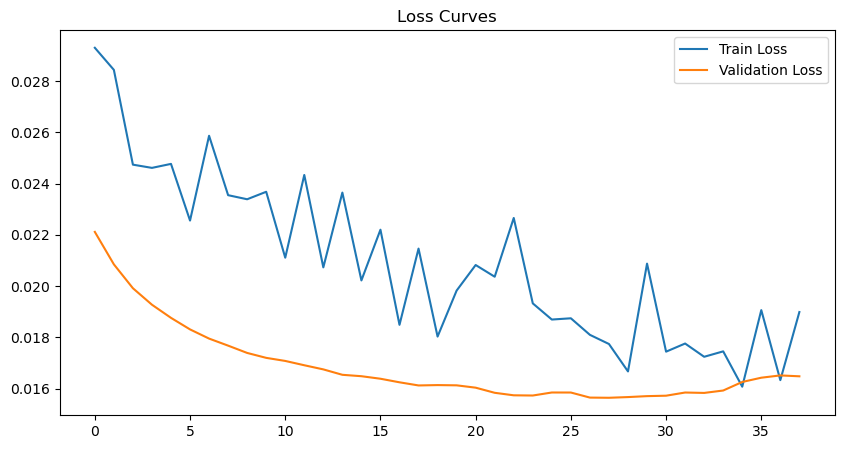

predictions: [-0.02216264 -0.05008046  0.07121918  0.11285128  0.05056022]
actuals: [0.09090909 0.09090909 0.09090909 0.         0.09090909]
correct: 27
total: 105


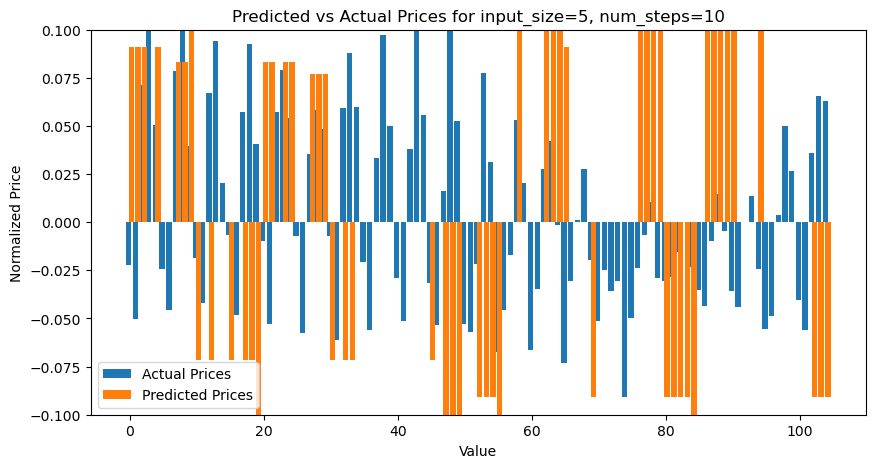

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


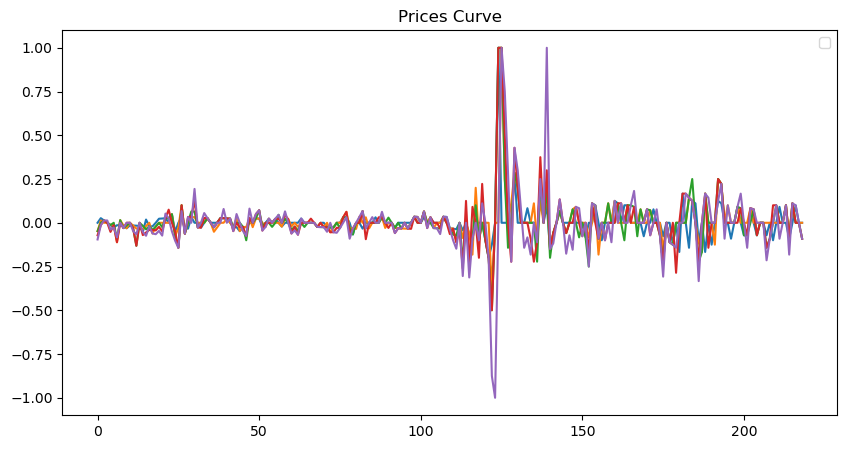

Epoch 1/50, Train Loss: 0.0363, Val Loss: 0.0292


Epoch 2/50, Train Loss: 0.0312, Val Loss: 0.0270


Epoch 3/50, Train Loss: 0.0358, Val Loss: 0.0252


Epoch 4/50, Train Loss: 0.0283, Val Loss: 0.0237


Epoch 5/50, Train Loss: 0.0293, Val Loss: 0.0221


Epoch 6/50, Train Loss: 0.0241, Val Loss: 0.0208


Epoch 7/50, Train Loss: 0.0263, Val Loss: 0.0198


Epoch 8/50, Train Loss: 0.0206, Val Loss: 0.0190


Epoch 9/50, Train Loss: 0.0199, Val Loss: 0.0184


Epoch 10/50, Train Loss: 0.0246, Val Loss: 0.0180


Epoch 11/50, Train Loss: 0.0203, Val Loss: 0.0177


Epoch 12/50, Train Loss: 0.0191, Val Loss: 0.0175


Epoch 13/50, Train Loss: 0.0199, Val Loss: 0.0173


Epoch 14/50, Train Loss: 0.0243, Val Loss: 0.0172


Epoch 15/50, Train Loss: 0.0206, Val Loss: 0.0171


Epoch 16/50, Train Loss: 0.0259, Val Loss: 0.0169


Epoch 17/50, Train Loss: 0.0182, Val Loss: 0.0168


Epoch 18/50, Train Loss: 0.0234, Val Loss: 0.0167


Epoch 19/50, Train Loss: 0.0185, Val Loss: 0.0166


Epoch 20/50, Train Loss: 0.0184, Val Loss: 0.0165


Epoch 21/50, Train Loss: 0.0215, Val Loss: 0.0165


Epoch 22/50, Train Loss: 0.0209, Val Loss: 0.0164


Epoch 23/50, Train Loss: 0.0186, Val Loss: 0.0163


Epoch 24/50, Train Loss: 0.0179, Val Loss: 0.0162


Epoch 25/50, Train Loss: 0.0232, Val Loss: 0.0162


Epoch 26/50, Train Loss: 0.0200, Val Loss: 0.0162


Epoch 27/50, Train Loss: 0.0259, Val Loss: 0.0162


Epoch 28/50, Train Loss: 0.0188, Val Loss: 0.0162


Epoch 29/50, Train Loss: 0.0209, Val Loss: 0.0162


Epoch 30/50, Train Loss: 0.0194, Val Loss: 0.0162


Epoch 31/50, Train Loss: 0.0231, Val Loss: 0.0163


Epoch 32/50, Train Loss: 0.0172, Val Loss: 0.0164


Epoch 33/50, Train Loss: 0.0196, Val Loss: 0.0165


Epoch 34/50, Train Loss: 0.0174, Val Loss: 0.0165


Epoch 35/50, Train Loss: 0.0170, Val Loss: 0.0165


Epoch 36/50, Train Loss: 0.0175, Val Loss: 0.0165


Epoch 37/50, Train Loss: 0.0197, Val Loss: 0.0165


Epoch 38/50, Train Loss: 0.0193, Val Loss: 0.0166


Epoch 39/50, Train Loss: 0.0210, Val Loss: 0.0168


Epoch 40/50, Train Loss: 0.0178, Val Loss: 0.0168
Early stopping triggered


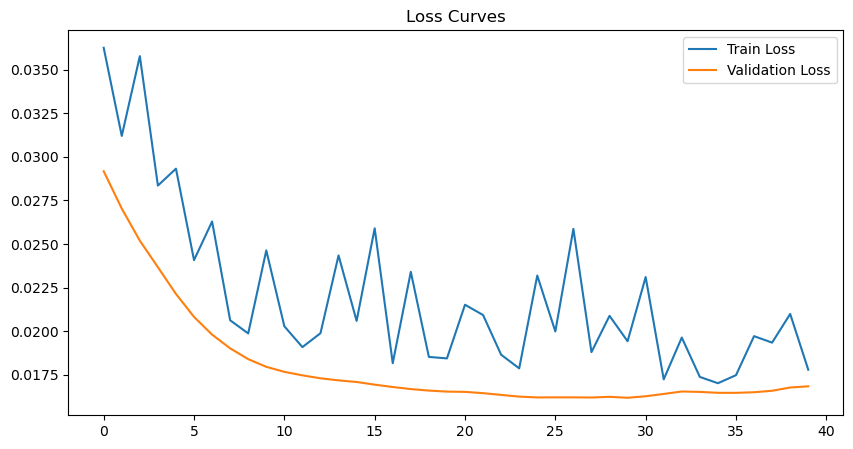

predictions: [-0.03637706  0.03071406 -0.00104438 -0.0285738   0.00423171]
actuals: [0.         0.         0.08333334 0.08333334 0.16666667]
correct: 28
total: 100


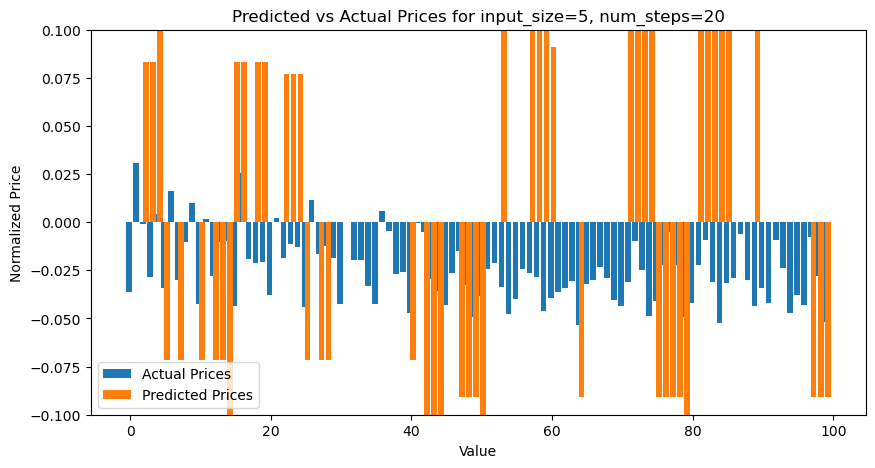

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


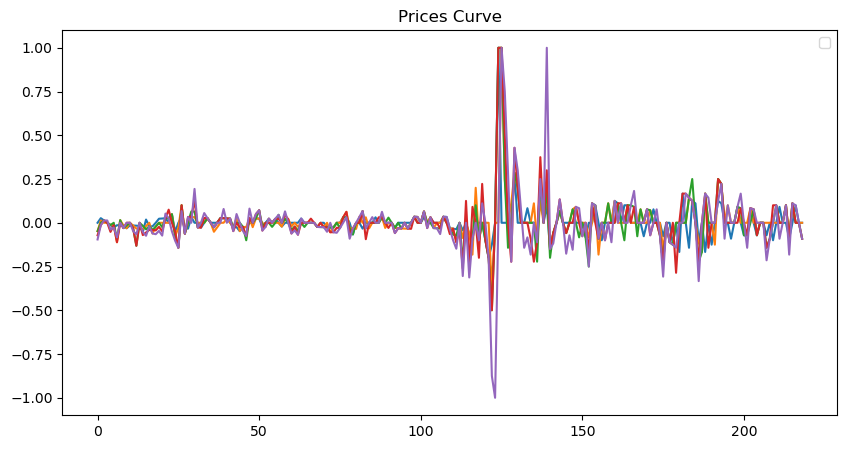

Epoch 1/50, Train Loss: 0.0400, Val Loss: 0.0312


Epoch 2/50, Train Loss: 0.0335, Val Loss: 0.0298


Epoch 3/50, Train Loss: 0.0377, Val Loss: 0.0276


Epoch 4/50, Train Loss: 0.0359, Val Loss: 0.0255


Epoch 5/50, Train Loss: 0.0256, Val Loss: 0.0240


Epoch 6/50, Train Loss: 0.0250, Val Loss: 0.0226


Epoch 7/50, Train Loss: 0.0245, Val Loss: 0.0211


Epoch 8/50, Train Loss: 0.0270, Val Loss: 0.0198


Epoch 9/50, Train Loss: 0.0244, Val Loss: 0.0188


Epoch 10/50, Train Loss: 0.0273, Val Loss: 0.0181


Epoch 11/50, Train Loss: 0.0218, Val Loss: 0.0174


Epoch 12/50, Train Loss: 0.0281, Val Loss: 0.0170


Epoch 13/50, Train Loss: 0.0277, Val Loss: 0.0166


Epoch 14/50, Train Loss: 0.0218, Val Loss: 0.0163


Epoch 15/50, Train Loss: 0.0282, Val Loss: 0.0161


Epoch 16/50, Train Loss: 0.0285, Val Loss: 0.0159


Epoch 17/50, Train Loss: 0.0217, Val Loss: 0.0157


Epoch 18/50, Train Loss: 0.0197, Val Loss: 0.0156


Epoch 19/50, Train Loss: 0.0306, Val Loss: 0.0155


Epoch 20/50, Train Loss: 0.0191, Val Loss: 0.0155


Epoch 21/50, Train Loss: 0.0288, Val Loss: 0.0154


Epoch 22/50, Train Loss: 0.0251, Val Loss: 0.0153


Epoch 23/50, Train Loss: 0.0276, Val Loss: 0.0152


Epoch 24/50, Train Loss: 0.0229, Val Loss: 0.0150


Epoch 25/50, Train Loss: 0.0243, Val Loss: 0.0150


Epoch 26/50, Train Loss: 0.0197, Val Loss: 0.0151


Epoch 27/50, Train Loss: 0.0320, Val Loss: 0.0151


Epoch 28/50, Train Loss: 0.0197, Val Loss: 0.0151


Epoch 29/50, Train Loss: 0.0178, Val Loss: 0.0150


Epoch 30/50, Train Loss: 0.0250, Val Loss: 0.0151


Epoch 31/50, Train Loss: 0.0191, Val Loss: 0.0152


Epoch 32/50, Train Loss: 0.0324, Val Loss: 0.0154


Epoch 33/50, Train Loss: 0.0224, Val Loss: 0.0156


Epoch 34/50, Train Loss: 0.0196, Val Loss: 0.0157
Early stopping triggered


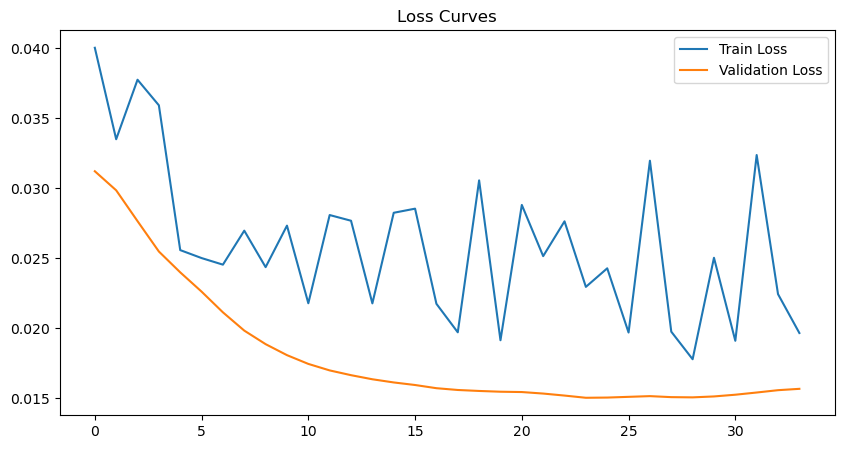

predictions: [ 0.06127945  0.03407554 -0.02492315  0.06050941 -0.00570896]
actuals: [-0.07142857  0.         -0.07142857  0.          0.        ]
correct: 25
total: 95


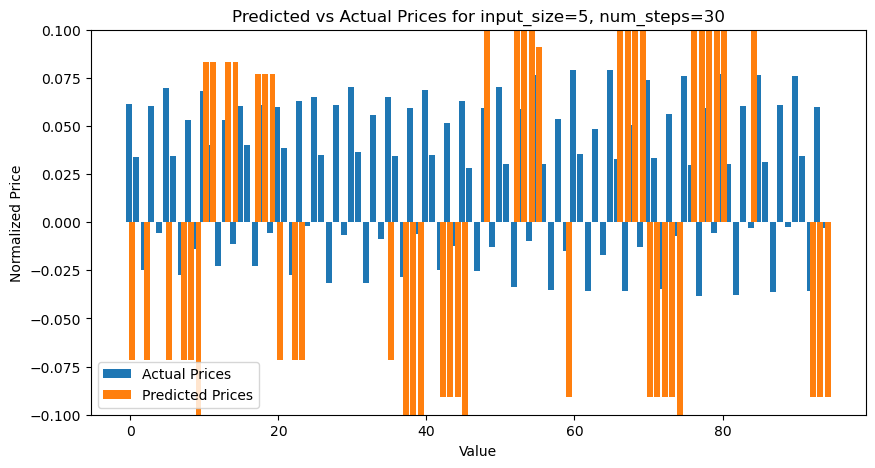

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


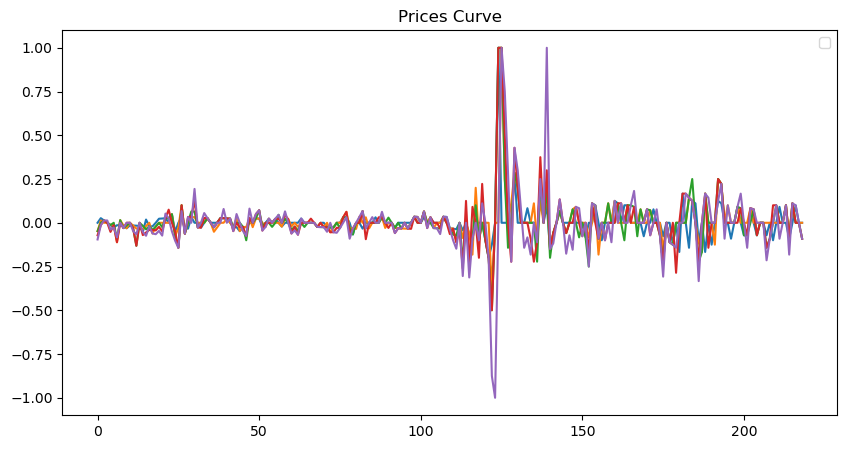

Epoch 1/50, Train Loss: 0.0290, Val Loss: 0.0234


Epoch 2/50, Train Loss: 0.0251, Val Loss: 0.0227


Epoch 3/50, Train Loss: 0.0227, Val Loss: 0.0219


Epoch 4/50, Train Loss: 0.0222, Val Loss: 0.0207


Epoch 5/50, Train Loss: 0.0212, Val Loss: 0.0194


Epoch 6/50, Train Loss: 0.0389, Val Loss: 0.0185


Epoch 7/50, Train Loss: 0.0222, Val Loss: 0.0176


Epoch 8/50, Train Loss: 0.0203, Val Loss: 0.0170


Epoch 9/50, Train Loss: 0.0259, Val Loss: 0.0167


Epoch 10/50, Train Loss: 0.0224, Val Loss: 0.0165


Epoch 11/50, Train Loss: 0.0233, Val Loss: 0.0163


Epoch 12/50, Train Loss: 0.0318, Val Loss: 0.0162


Epoch 13/50, Train Loss: 0.0187, Val Loss: 0.0163


Epoch 14/50, Train Loss: 0.0308, Val Loss: 0.0165


Epoch 15/50, Train Loss: 0.0182, Val Loss: 0.0166


Epoch 16/50, Train Loss: 0.0297, Val Loss: 0.0166


Epoch 17/50, Train Loss: 0.0186, Val Loss: 0.0164


Epoch 18/50, Train Loss: 0.0193, Val Loss: 0.0164


Epoch 19/50, Train Loss: 0.0201, Val Loss: 0.0164


Epoch 20/50, Train Loss: 0.0280, Val Loss: 0.0166


Epoch 21/50, Train Loss: 0.0172, Val Loss: 0.0165


Epoch 22/50, Train Loss: 0.0184, Val Loss: 0.0164
Early stopping triggered


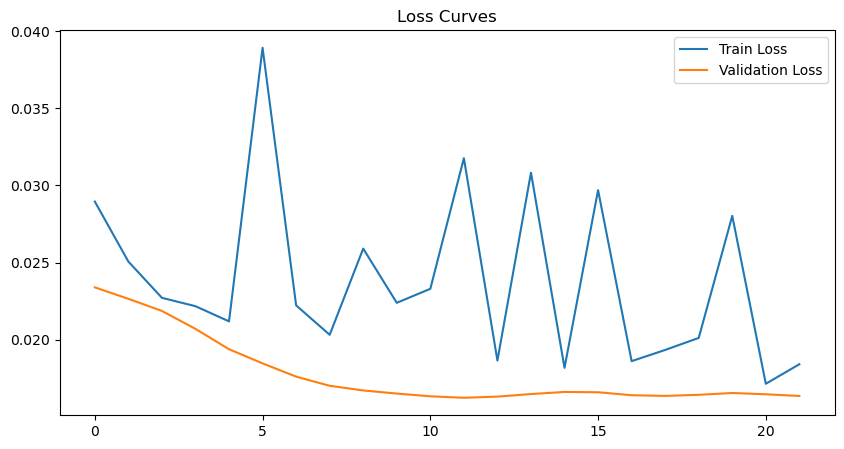

predictions: [ 0.01810966 -0.01005308 -0.02817324  0.02344531 -0.05848255]
actuals: [-0.07142857  0.         -0.07142857 -0.07142857 -0.14285715]
correct: 23
total: 90


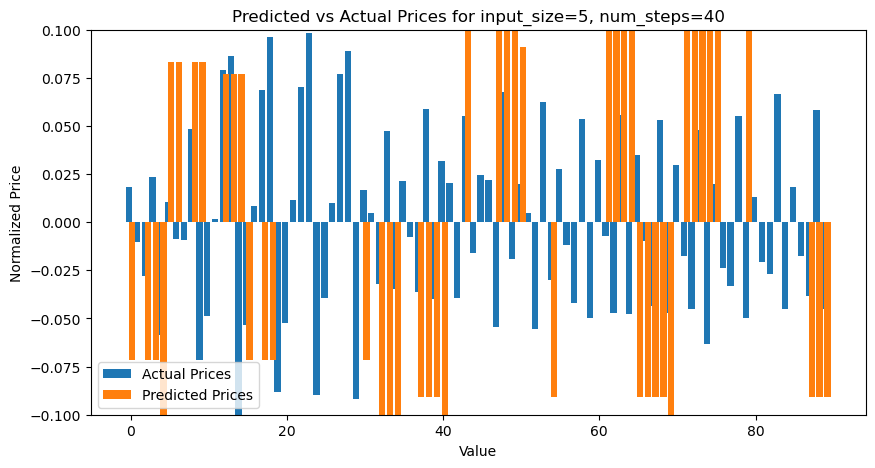

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


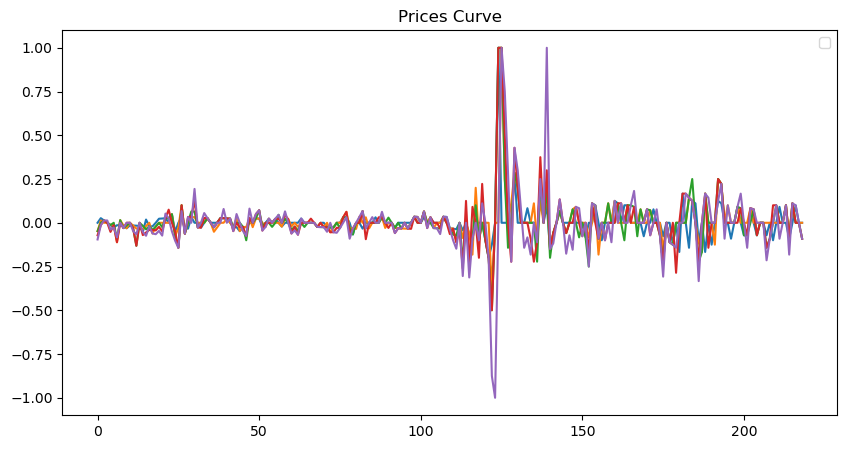

Epoch 1/50, Train Loss: 0.0308, Val Loss: 0.0231


Epoch 2/50, Train Loss: 0.0538, Val Loss: 0.0224


Epoch 3/50, Train Loss: 0.0257, Val Loss: 0.0217


Epoch 4/50, Train Loss: 0.0245, Val Loss: 0.0210


Epoch 5/50, Train Loss: 0.0244, Val Loss: 0.0204


Epoch 6/50, Train Loss: 0.0238, Val Loss: 0.0198


Epoch 7/50, Train Loss: 0.0240, Val Loss: 0.0193


Epoch 8/50, Train Loss: 0.0241, Val Loss: 0.0188


Epoch 9/50, Train Loss: 0.0245, Val Loss: 0.0184


Epoch 10/50, Train Loss: 0.0222, Val Loss: 0.0182


Epoch 11/50, Train Loss: 0.0290, Val Loss: 0.0179


Epoch 12/50, Train Loss: 0.0229, Val Loss: 0.0178


Epoch 13/50, Train Loss: 0.0293, Val Loss: 0.0174


Epoch 14/50, Train Loss: 0.0195, Val Loss: 0.0168


Epoch 15/50, Train Loss: 0.0199, Val Loss: 0.0162


Epoch 16/50, Train Loss: 0.0200, Val Loss: 0.0156


Epoch 17/50, Train Loss: 0.0190, Val Loss: 0.0152


Epoch 18/50, Train Loss: 0.0221, Val Loss: 0.0150


Epoch 19/50, Train Loss: 0.0212, Val Loss: 0.0149


Epoch 20/50, Train Loss: 0.0282, Val Loss: 0.0149


Epoch 21/50, Train Loss: 0.0260, Val Loss: 0.0150


Epoch 22/50, Train Loss: 0.0264, Val Loss: 0.0150


Epoch 23/50, Train Loss: 0.0220, Val Loss: 0.0150


Epoch 24/50, Train Loss: 0.0189, Val Loss: 0.0150


Epoch 25/50, Train Loss: 0.0180, Val Loss: 0.0150


Epoch 26/50, Train Loss: 0.0189, Val Loss: 0.0149


Epoch 27/50, Train Loss: 0.0224, Val Loss: 0.0148


Epoch 28/50, Train Loss: 0.0267, Val Loss: 0.0146


Epoch 29/50, Train Loss: 0.0180, Val Loss: 0.0145


Epoch 30/50, Train Loss: 0.0181, Val Loss: 0.0145


Epoch 31/50, Train Loss: 0.0360, Val Loss: 0.0144


Epoch 32/50, Train Loss: 0.0181, Val Loss: 0.0144


Epoch 33/50, Train Loss: 0.0193, Val Loss: 0.0143


Epoch 34/50, Train Loss: 0.0192, Val Loss: 0.0144


Epoch 35/50, Train Loss: 0.0414, Val Loss: 0.0144


Epoch 36/50, Train Loss: 0.0225, Val Loss: 0.0144


Epoch 37/50, Train Loss: 0.0506, Val Loss: 0.0143


Epoch 38/50, Train Loss: 0.0400, Val Loss: 0.0142


Epoch 39/50, Train Loss: 0.0186, Val Loss: 0.0143


Epoch 40/50, Train Loss: 0.0251, Val Loss: 0.0144


Epoch 41/50, Train Loss: 0.0186, Val Loss: 0.0144


Epoch 42/50, Train Loss: 0.0389, Val Loss: 0.0144


Epoch 43/50, Train Loss: 0.0220, Val Loss: 0.0143


Epoch 44/50, Train Loss: 0.0182, Val Loss: 0.0141


Epoch 45/50, Train Loss: 0.0177, Val Loss: 0.0141


Epoch 46/50, Train Loss: 0.0190, Val Loss: 0.0140


Epoch 47/50, Train Loss: 0.0478, Val Loss: 0.0141


Epoch 48/50, Train Loss: 0.0195, Val Loss: 0.0141


Epoch 49/50, Train Loss: 0.0175, Val Loss: 0.0142


Epoch 50/50, Train Loss: 0.0234, Val Loss: 0.0141


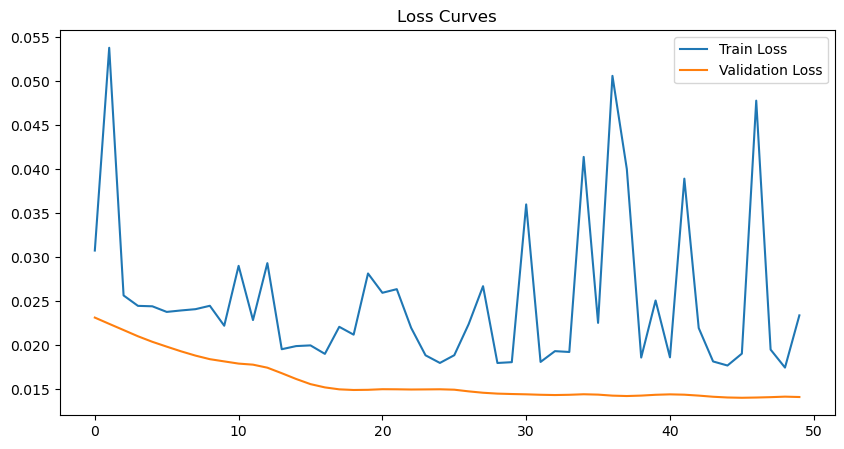

predictions: [ 0.0142431  -0.00831805  0.01048143  0.01586311 -0.01005757]
actuals: [0.08333334 0.08333334 0.         0.08333334 0.08333334]
correct: 19
total: 85


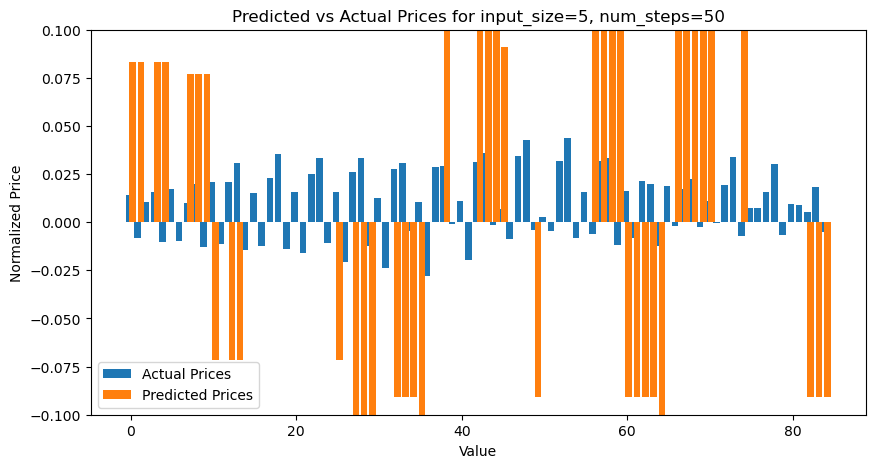

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


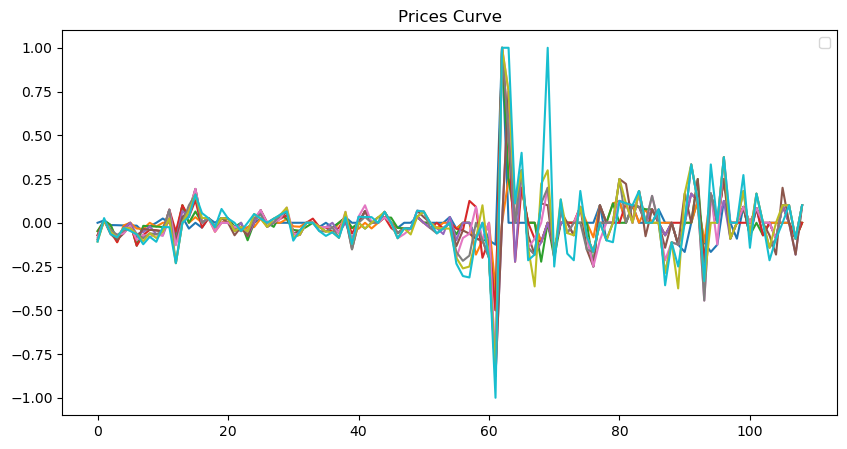

Epoch 1/50, Train Loss: 0.0370, Val Loss: 0.0465


Epoch 2/50, Train Loss: 0.0464, Val Loss: 0.0450


Epoch 3/50, Train Loss: 0.0499, Val Loss: 0.0437


Epoch 4/50, Train Loss: 0.0537, Val Loss: 0.0426


Epoch 5/50, Train Loss: 0.0315, Val Loss: 0.0417


Epoch 6/50, Train Loss: 0.0423, Val Loss: 0.0408


Epoch 7/50, Train Loss: 0.0298, Val Loss: 0.0401


Epoch 8/50, Train Loss: 0.0289, Val Loss: 0.0397


Epoch 9/50, Train Loss: 0.0580, Val Loss: 0.0393


Epoch 10/50, Train Loss: 0.0275, Val Loss: 0.0389


Epoch 11/50, Train Loss: 0.0279, Val Loss: 0.0385


Epoch 12/50, Train Loss: 0.0318, Val Loss: 0.0382


Epoch 13/50, Train Loss: 0.0279, Val Loss: 0.0379


Epoch 14/50, Train Loss: 0.0375, Val Loss: 0.0376


Epoch 15/50, Train Loss: 0.0439, Val Loss: 0.0373


Epoch 16/50, Train Loss: 0.0354, Val Loss: 0.0371


Epoch 17/50, Train Loss: 0.0306, Val Loss: 0.0369


Epoch 18/50, Train Loss: 0.0349, Val Loss: 0.0367


Epoch 19/50, Train Loss: 0.0352, Val Loss: 0.0366


Epoch 20/50, Train Loss: 0.0255, Val Loss: 0.0364


Epoch 21/50, Train Loss: 0.0331, Val Loss: 0.0363


Epoch 22/50, Train Loss: 0.0242, Val Loss: 0.0362


Epoch 23/50, Train Loss: 0.0429, Val Loss: 0.0360


Epoch 24/50, Train Loss: 0.0324, Val Loss: 0.0359


Epoch 25/50, Train Loss: 0.0367, Val Loss: 0.0358


Epoch 26/50, Train Loss: 0.0360, Val Loss: 0.0357


Epoch 27/50, Train Loss: 0.0260, Val Loss: 0.0356


Epoch 28/50, Train Loss: 0.0230, Val Loss: 0.0356


Epoch 29/50, Train Loss: 0.0345, Val Loss: 0.0355


Epoch 30/50, Train Loss: 0.0407, Val Loss: 0.0355


Epoch 31/50, Train Loss: 0.0223, Val Loss: 0.0354


Epoch 32/50, Train Loss: 0.0444, Val Loss: 0.0354


Epoch 33/50, Train Loss: 0.0342, Val Loss: 0.0354


Epoch 34/50, Train Loss: 0.0220, Val Loss: 0.0353


Epoch 35/50, Train Loss: 0.0383, Val Loss: 0.0353


Epoch 36/50, Train Loss: 0.0233, Val Loss: 0.0353


Epoch 37/50, Train Loss: 0.0344, Val Loss: 0.0352


Epoch 38/50, Train Loss: 0.0307, Val Loss: 0.0352


Epoch 39/50, Train Loss: 0.0331, Val Loss: 0.0351


Epoch 40/50, Train Loss: 0.0338, Val Loss: 0.0350


Epoch 41/50, Train Loss: 0.0310, Val Loss: 0.0350


Epoch 42/50, Train Loss: 0.0217, Val Loss: 0.0349


Epoch 43/50, Train Loss: 0.0226, Val Loss: 0.0349


Epoch 44/50, Train Loss: 0.0317, Val Loss: 0.0349


Epoch 45/50, Train Loss: 0.0316, Val Loss: 0.0349


Epoch 46/50, Train Loss: 0.0330, Val Loss: 0.0348


Epoch 47/50, Train Loss: 0.0239, Val Loss: 0.0348


Epoch 48/50, Train Loss: 0.0315, Val Loss: 0.0348


Epoch 49/50, Train Loss: 0.0287, Val Loss: 0.0348


Epoch 50/50, Train Loss: 0.0265, Val Loss: 0.0348


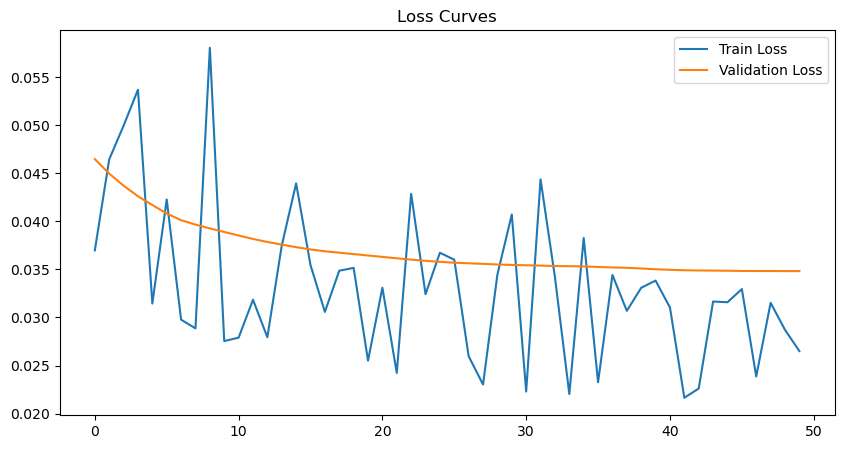

predictions: [-0.06898446 -0.00153536  0.05585806  0.01803822  0.05851593]
actuals: [-0.09090909  0.          0.          0.          0.        ]
correct: 37
total: 110


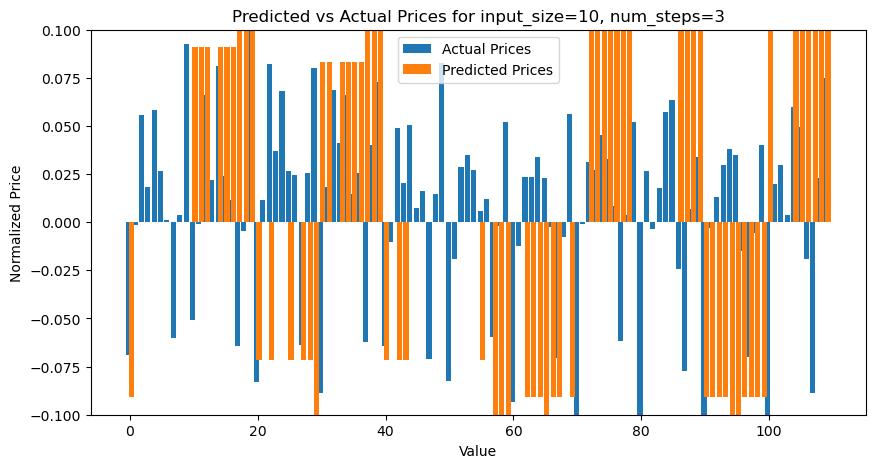

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


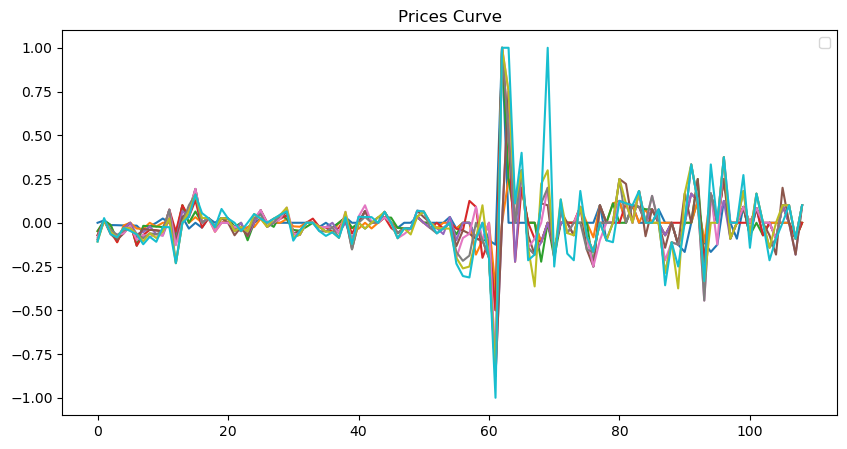

Epoch 1/50, Train Loss: 0.0470, Val Loss: 0.0442


Epoch 2/50, Train Loss: 0.0344, Val Loss: 0.0428


Epoch 3/50, Train Loss: 0.0309, Val Loss: 0.0421


Epoch 4/50, Train Loss: 0.0628, Val Loss: 0.0412


Epoch 5/50, Train Loss: 0.0306, Val Loss: 0.0401


Epoch 6/50, Train Loss: 0.0315, Val Loss: 0.0393


Epoch 7/50, Train Loss: 0.0436, Val Loss: 0.0388


Epoch 8/50, Train Loss: 0.0280, Val Loss: 0.0384


Epoch 9/50, Train Loss: 0.0284, Val Loss: 0.0380


Epoch 10/50, Train Loss: 0.0419, Val Loss: 0.0377


Epoch 11/50, Train Loss: 0.0445, Val Loss: 0.0374


Epoch 12/50, Train Loss: 0.0467, Val Loss: 0.0372


Epoch 13/50, Train Loss: 0.0256, Val Loss: 0.0370


Epoch 14/50, Train Loss: 0.0375, Val Loss: 0.0367


Epoch 15/50, Train Loss: 0.0518, Val Loss: 0.0366


Epoch 16/50, Train Loss: 0.0372, Val Loss: 0.0367


Epoch 17/50, Train Loss: 0.0425, Val Loss: 0.0367


Epoch 18/50, Train Loss: 0.0269, Val Loss: 0.0368


Epoch 19/50, Train Loss: 0.0264, Val Loss: 0.0367


Epoch 20/50, Train Loss: 0.0255, Val Loss: 0.0366


Epoch 21/50, Train Loss: 0.0423, Val Loss: 0.0364


Epoch 22/50, Train Loss: 0.0238, Val Loss: 0.0362


Epoch 23/50, Train Loss: 0.0244, Val Loss: 0.0360


Epoch 24/50, Train Loss: 0.0373, Val Loss: 0.0360


Epoch 25/50, Train Loss: 0.0247, Val Loss: 0.0361


Epoch 26/50, Train Loss: 0.0384, Val Loss: 0.0363


Epoch 27/50, Train Loss: 0.0338, Val Loss: 0.0364


Epoch 28/50, Train Loss: 0.0327, Val Loss: 0.0365


Epoch 29/50, Train Loss: 0.0241, Val Loss: 0.0366


Epoch 30/50, Train Loss: 0.0375, Val Loss: 0.0366


Epoch 31/50, Train Loss: 0.0325, Val Loss: 0.0365


Epoch 32/50, Train Loss: 0.0323, Val Loss: 0.0364


Epoch 33/50, Train Loss: 0.0248, Val Loss: 0.0362


Epoch 34/50, Train Loss: 0.0397, Val Loss: 0.0360
Early stopping triggered


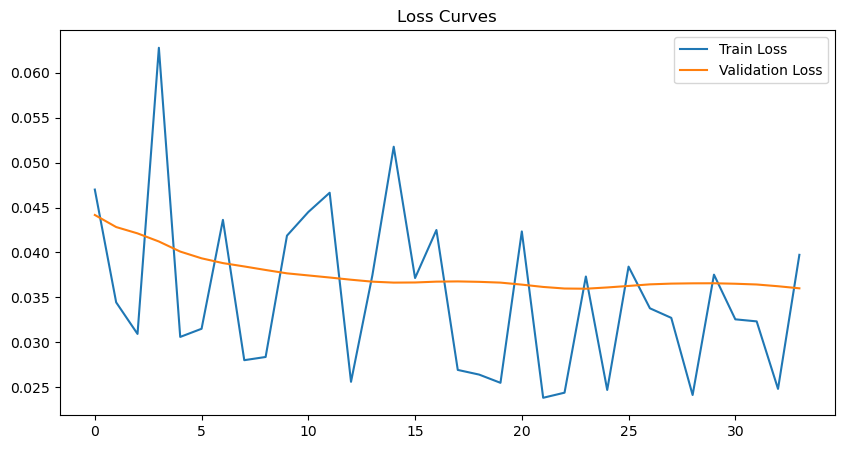

predictions: [ 0.04171539  0.01094317 -0.0432549  -0.01800691  0.0476192 ]
actuals: [0.09090909 0.09090909 0.09090909 0.         0.09090909]
correct: 40
total: 100


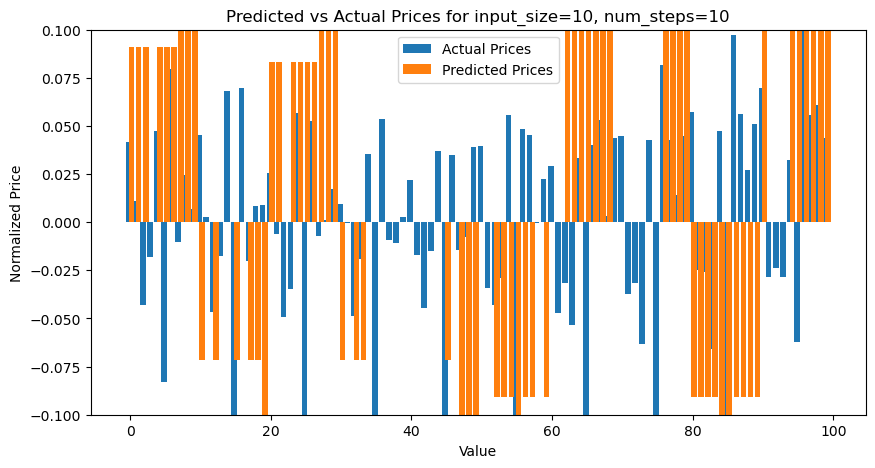

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


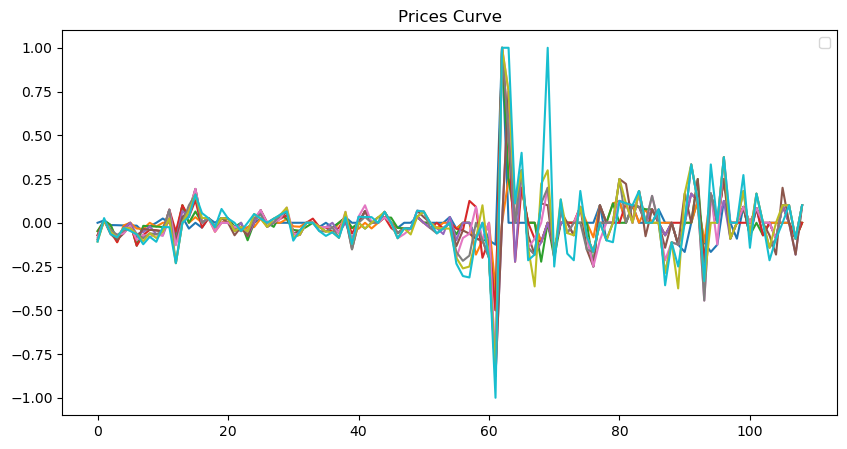

Epoch 1/50, Train Loss: 0.0576, Val Loss: 0.0724


Epoch 2/50, Train Loss: 0.0454, Val Loss: 0.0657


Epoch 3/50, Train Loss: 0.0424, Val Loss: 0.0620


Epoch 4/50, Train Loss: 0.0392, Val Loss: 0.0605


Epoch 5/50, Train Loss: 0.0474, Val Loss: 0.0596


Epoch 6/50, Train Loss: 0.0408, Val Loss: 0.0586


Epoch 7/50, Train Loss: 0.0406, Val Loss: 0.0580


Epoch 8/50, Train Loss: 0.1084, Val Loss: 0.0572


Epoch 9/50, Train Loss: 0.0412, Val Loss: 0.0563


Epoch 10/50, Train Loss: 0.0340, Val Loss: 0.0552


Epoch 11/50, Train Loss: 0.0424, Val Loss: 0.0539


Epoch 12/50, Train Loss: 0.0852, Val Loss: 0.0527


Epoch 13/50, Train Loss: 0.0333, Val Loss: 0.0519


Epoch 14/50, Train Loss: 0.0326, Val Loss: 0.0514


Epoch 15/50, Train Loss: 0.0363, Val Loss: 0.0512


Epoch 16/50, Train Loss: 0.0317, Val Loss: 0.0510


Epoch 17/50, Train Loss: 0.0618, Val Loss: 0.0511


Epoch 18/50, Train Loss: 0.0331, Val Loss: 0.0515


Epoch 19/50, Train Loss: 0.0330, Val Loss: 0.0514


Epoch 20/50, Train Loss: 0.0303, Val Loss: 0.0512


Epoch 21/50, Train Loss: 0.0374, Val Loss: 0.0508


Epoch 22/50, Train Loss: 0.0316, Val Loss: 0.0504


Epoch 23/50, Train Loss: 0.0298, Val Loss: 0.0499


Epoch 24/50, Train Loss: 0.0548, Val Loss: 0.0495


Epoch 25/50, Train Loss: 0.0310, Val Loss: 0.0493


Epoch 26/50, Train Loss: 0.0285, Val Loss: 0.0490


Epoch 27/50, Train Loss: 0.0313, Val Loss: 0.0488


Epoch 28/50, Train Loss: 0.0358, Val Loss: 0.0486


Epoch 29/50, Train Loss: 0.0575, Val Loss: 0.0483


Epoch 30/50, Train Loss: 0.0287, Val Loss: 0.0481


Epoch 31/50, Train Loss: 0.0642, Val Loss: 0.0480


Epoch 32/50, Train Loss: 0.0282, Val Loss: 0.0479


Epoch 33/50, Train Loss: 0.0297, Val Loss: 0.0477


Epoch 34/50, Train Loss: 0.0304, Val Loss: 0.0476


Epoch 35/50, Train Loss: 0.0339, Val Loss: 0.0473


Epoch 36/50, Train Loss: 0.0293, Val Loss: 0.0471


Epoch 37/50, Train Loss: 0.0307, Val Loss: 0.0469


Epoch 38/50, Train Loss: 0.0299, Val Loss: 0.0467


Epoch 39/50, Train Loss: 0.0728, Val Loss: 0.0465


Epoch 40/50, Train Loss: 0.0271, Val Loss: 0.0463


Epoch 41/50, Train Loss: 0.0290, Val Loss: 0.0461


Epoch 42/50, Train Loss: 0.0325, Val Loss: 0.0458


Epoch 43/50, Train Loss: 0.0510, Val Loss: 0.0454


Epoch 44/50, Train Loss: 0.0254, Val Loss: 0.0451


Epoch 45/50, Train Loss: 0.0264, Val Loss: 0.0447


Epoch 46/50, Train Loss: 0.0336, Val Loss: 0.0444


Epoch 47/50, Train Loss: 0.0269, Val Loss: 0.0441


Epoch 48/50, Train Loss: 0.0270, Val Loss: 0.0437


Epoch 49/50, Train Loss: 0.0257, Val Loss: 0.0434


Epoch 50/50, Train Loss: 0.0645, Val Loss: 0.0431


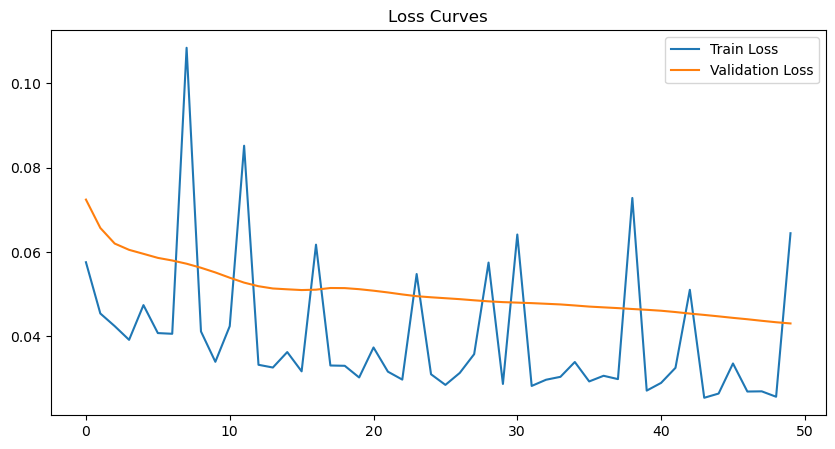

predictions: [-0.06949406 -0.13909172 -0.08344647  0.06758982 -0.05296262]
actuals: [-0.07142857  0.         -0.07142857  0.          0.        ]
correct: 28
total: 90


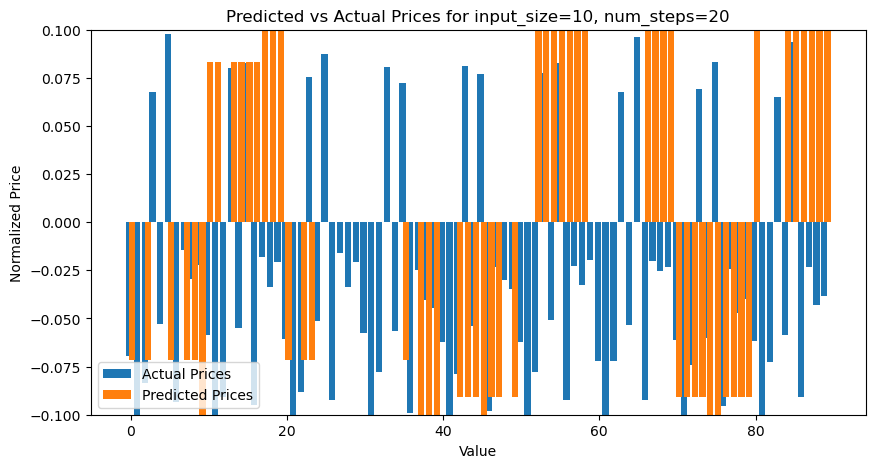

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


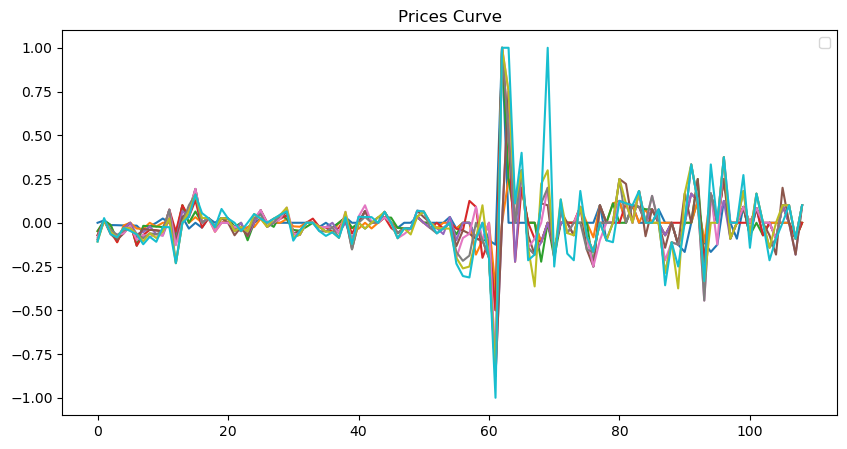

Epoch 1/50, Train Loss: 0.0586, Val Loss: 0.0464


Epoch 2/50, Train Loss: 0.0573, Val Loss: 0.0462


Epoch 3/50, Train Loss: 0.0562, Val Loss: 0.0461


Epoch 4/50, Train Loss: 0.0536, Val Loss: 0.0453


Epoch 5/50, Train Loss: 0.0536, Val Loss: 0.0443


Epoch 6/50, Train Loss: 0.0518, Val Loss: 0.0435


Epoch 7/50, Train Loss: 0.0523, Val Loss: 0.0431


Epoch 8/50, Train Loss: 0.0517, Val Loss: 0.0428


Epoch 9/50, Train Loss: 0.0522, Val Loss: 0.0424


Epoch 10/50, Train Loss: 0.0513, Val Loss: 0.0419


Epoch 11/50, Train Loss: 0.0510, Val Loss: 0.0414


Epoch 12/50, Train Loss: 0.0495, Val Loss: 0.0408


Epoch 13/50, Train Loss: 0.0496, Val Loss: 0.0403


Epoch 14/50, Train Loss: 0.0490, Val Loss: 0.0398


Epoch 15/50, Train Loss: 0.0488, Val Loss: 0.0392


Epoch 16/50, Train Loss: 0.0485, Val Loss: 0.0387


Epoch 17/50, Train Loss: 0.0480, Val Loss: 0.0383


Epoch 18/50, Train Loss: 0.0476, Val Loss: 0.0379


Epoch 19/50, Train Loss: 0.0489, Val Loss: 0.0376


Epoch 20/50, Train Loss: 0.0480, Val Loss: 0.0374


Epoch 21/50, Train Loss: 0.0473, Val Loss: 0.0372


Epoch 22/50, Train Loss: 0.0471, Val Loss: 0.0370


Epoch 23/50, Train Loss: 0.0467, Val Loss: 0.0369


Epoch 24/50, Train Loss: 0.0459, Val Loss: 0.0367


Epoch 25/50, Train Loss: 0.0471, Val Loss: 0.0366


Epoch 26/50, Train Loss: 0.0463, Val Loss: 0.0365


Epoch 27/50, Train Loss: 0.0475, Val Loss: 0.0364


Epoch 28/50, Train Loss: 0.0460, Val Loss: 0.0363


Epoch 29/50, Train Loss: 0.0466, Val Loss: 0.0362


Epoch 30/50, Train Loss: 0.0460, Val Loss: 0.0362


Epoch 31/50, Train Loss: 0.0445, Val Loss: 0.0361


Epoch 32/50, Train Loss: 0.0449, Val Loss: 0.0361


Epoch 33/50, Train Loss: 0.0453, Val Loss: 0.0360


Epoch 34/50, Train Loss: 0.0455, Val Loss: 0.0360


Epoch 35/50, Train Loss: 0.0441, Val Loss: 0.0359


Epoch 36/50, Train Loss: 0.0439, Val Loss: 0.0359


Epoch 37/50, Train Loss: 0.0449, Val Loss: 0.0359


Epoch 38/50, Train Loss: 0.0436, Val Loss: 0.0358


Epoch 39/50, Train Loss: 0.0444, Val Loss: 0.0358


Epoch 40/50, Train Loss: 0.0439, Val Loss: 0.0357


Epoch 41/50, Train Loss: 0.0429, Val Loss: 0.0357


Epoch 42/50, Train Loss: 0.0437, Val Loss: 0.0357


Epoch 43/50, Train Loss: 0.0432, Val Loss: 0.0356


Epoch 44/50, Train Loss: 0.0436, Val Loss: 0.0356


Epoch 45/50, Train Loss: 0.0434, Val Loss: 0.0356


Epoch 46/50, Train Loss: 0.0434, Val Loss: 0.0356


Epoch 47/50, Train Loss: 0.0434, Val Loss: 0.0355


Epoch 48/50, Train Loss: 0.0434, Val Loss: 0.0355


Epoch 49/50, Train Loss: 0.0428, Val Loss: 0.0355


Epoch 50/50, Train Loss: 0.0425, Val Loss: 0.0354


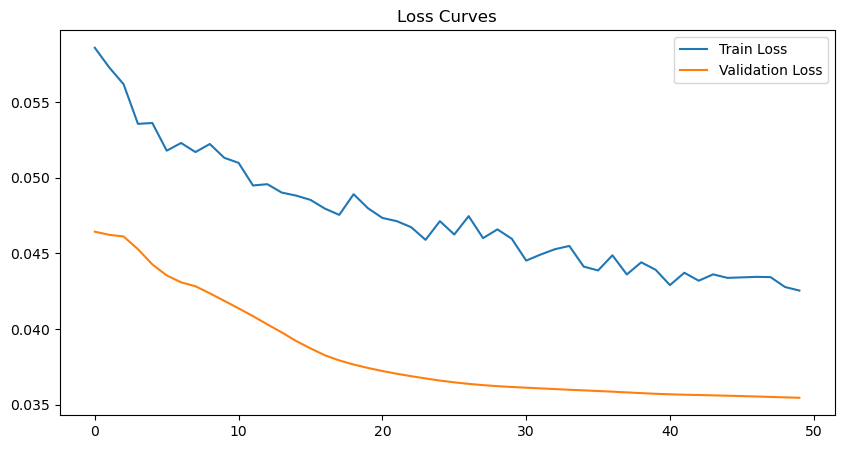

predictions: [-0.09968814  0.03365042 -0.08577555 -0.00789948  0.06645325]
actuals: [0.08333334 0.08333334 0.         0.08333334 0.08333334]
correct: 29
total: 80


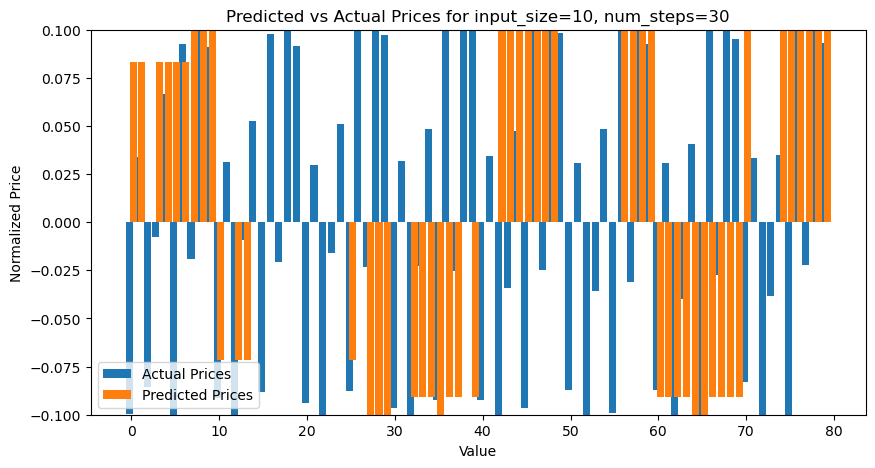

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


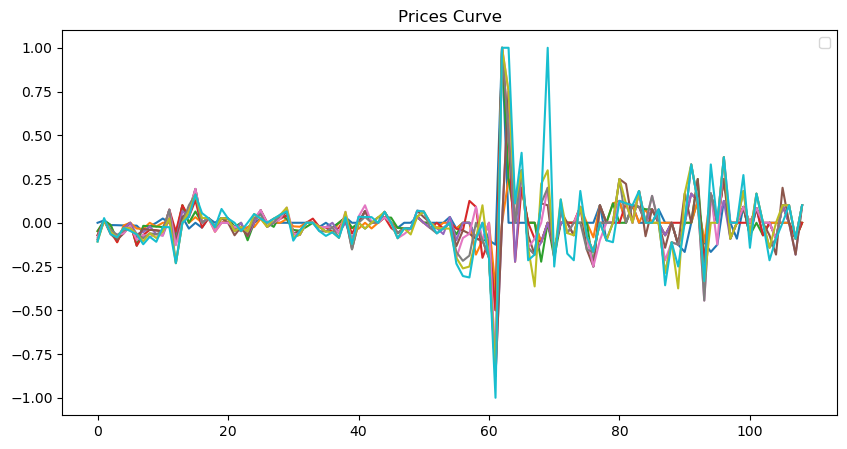

Epoch 1/50, Train Loss: 0.0718, Val Loss: 0.0529


Epoch 2/50, Train Loss: 0.0689, Val Loss: 0.0518


Epoch 3/50, Train Loss: 0.0677, Val Loss: 0.0508


Epoch 4/50, Train Loss: 0.0650, Val Loss: 0.0498


Epoch 5/50, Train Loss: 0.0641, Val Loss: 0.0488


Epoch 6/50, Train Loss: 0.0636, Val Loss: 0.0475


Epoch 7/50, Train Loss: 0.0613, Val Loss: 0.0448


Epoch 8/50, Train Loss: 0.0612, Val Loss: 0.0425


Epoch 9/50, Train Loss: 0.0583, Val Loss: 0.0411


Epoch 10/50, Train Loss: 0.0576, Val Loss: 0.0400


Epoch 11/50, Train Loss: 0.0577, Val Loss: 0.0390


Epoch 12/50, Train Loss: 0.0570, Val Loss: 0.0378


Epoch 13/50, Train Loss: 0.0564, Val Loss: 0.0358


Epoch 14/50, Train Loss: 0.0546, Val Loss: 0.0339


Epoch 15/50, Train Loss: 0.0540, Val Loss: 0.0337


Epoch 16/50, Train Loss: 0.0549, Val Loss: 0.0331


Epoch 17/50, Train Loss: 0.0545, Val Loss: 0.0324


Epoch 18/50, Train Loss: 0.0540, Val Loss: 0.0317


Epoch 19/50, Train Loss: 0.0533, Val Loss: 0.0311


Epoch 20/50, Train Loss: 0.0520, Val Loss: 0.0305


Epoch 21/50, Train Loss: 0.0530, Val Loss: 0.0300


Epoch 22/50, Train Loss: 0.0526, Val Loss: 0.0294


Epoch 23/50, Train Loss: 0.0525, Val Loss: 0.0290


Epoch 24/50, Train Loss: 0.0531, Val Loss: 0.0287


Epoch 25/50, Train Loss: 0.0525, Val Loss: 0.0285


Epoch 26/50, Train Loss: 0.0520, Val Loss: 0.0282


Epoch 27/50, Train Loss: 0.0517, Val Loss: 0.0278


Epoch 28/50, Train Loss: 0.0533, Val Loss: 0.0275


Epoch 29/50, Train Loss: 0.0497, Val Loss: 0.0271


Epoch 30/50, Train Loss: 0.0507, Val Loss: 0.0267


Epoch 31/50, Train Loss: 0.0501, Val Loss: 0.0263


Epoch 32/50, Train Loss: 0.0520, Val Loss: 0.0259


Epoch 33/50, Train Loss: 0.0503, Val Loss: 0.0256


Epoch 34/50, Train Loss: 0.0516, Val Loss: 0.0253


Epoch 35/50, Train Loss: 0.0518, Val Loss: 0.0252


Epoch 36/50, Train Loss: 0.0502, Val Loss: 0.0251


Epoch 37/50, Train Loss: 0.0495, Val Loss: 0.0251


Epoch 38/50, Train Loss: 0.0497, Val Loss: 0.0250


Epoch 39/50, Train Loss: 0.0500, Val Loss: 0.0249


Epoch 40/50, Train Loss: 0.0492, Val Loss: 0.0247


Epoch 41/50, Train Loss: 0.0504, Val Loss: 0.0245


Epoch 42/50, Train Loss: 0.0495, Val Loss: 0.0243


Epoch 43/50, Train Loss: 0.0507, Val Loss: 0.0241


Epoch 44/50, Train Loss: 0.0502, Val Loss: 0.0239


Epoch 45/50, Train Loss: 0.0496, Val Loss: 0.0238


Epoch 46/50, Train Loss: 0.0498, Val Loss: 0.0236


Epoch 47/50, Train Loss: 0.0489, Val Loss: 0.0235


Epoch 48/50, Train Loss: 0.0488, Val Loss: 0.0233


Epoch 49/50, Train Loss: 0.0488, Val Loss: 0.0232


Epoch 50/50, Train Loss: 0.0491, Val Loss: 0.0231


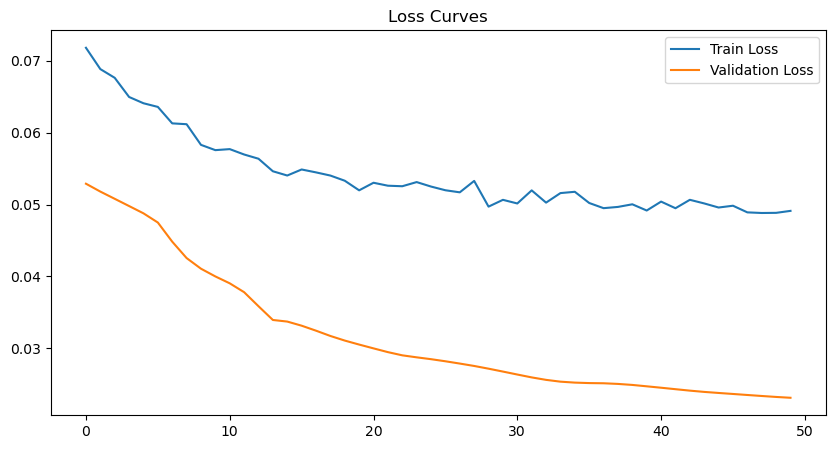

predictions: [ 0.01986255 -0.01252992  0.06255051 -0.08815767  0.01280046]
actuals: [-0.07142857  0.         -0.07142857 -0.07142857  0.        ]
correct: 19
total: 70


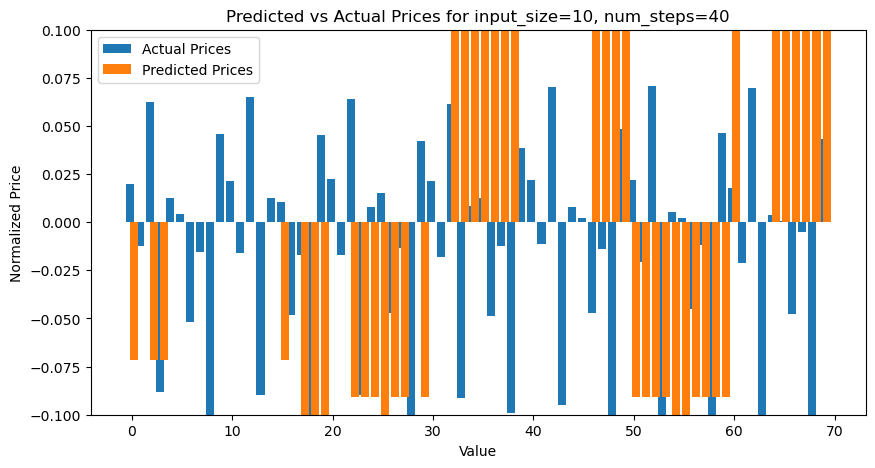

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


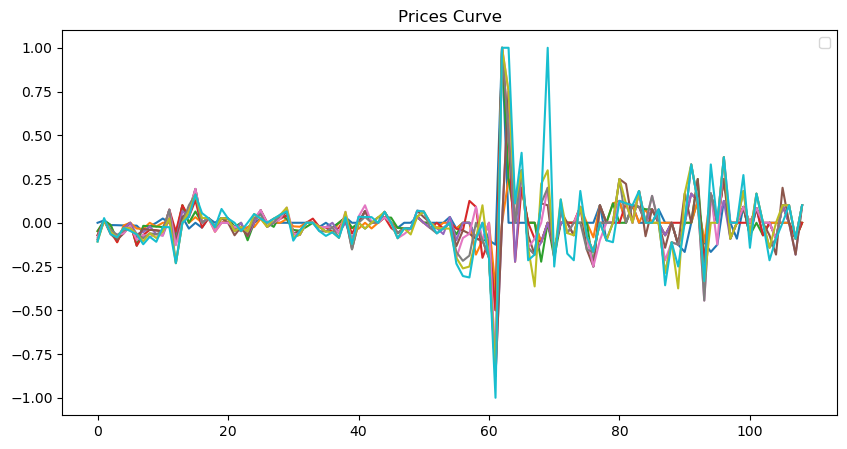

Epoch 1/50, Train Loss: 0.0686, Val Loss: 0.0160


Epoch 2/50, Train Loss: 0.0667, Val Loss: 0.0137


Epoch 3/50, Train Loss: 0.0634, Val Loss: 0.0127


Epoch 4/50, Train Loss: 0.0646, Val Loss: 0.0120


Epoch 5/50, Train Loss: 0.0639, Val Loss: 0.0115


Epoch 6/50, Train Loss: 0.0641, Val Loss: 0.0112


Epoch 7/50, Train Loss: 0.0621, Val Loss: 0.0108


Epoch 8/50, Train Loss: 0.0614, Val Loss: 0.0104


Epoch 9/50, Train Loss: 0.0609, Val Loss: 0.0101


Epoch 10/50, Train Loss: 0.0606, Val Loss: 0.0099


Epoch 11/50, Train Loss: 0.0599, Val Loss: 0.0096


Epoch 12/50, Train Loss: 0.0604, Val Loss: 0.0095


Epoch 13/50, Train Loss: 0.0586, Val Loss: 0.0093


Epoch 14/50, Train Loss: 0.0590, Val Loss: 0.0092


Epoch 15/50, Train Loss: 0.0579, Val Loss: 0.0091


Epoch 16/50, Train Loss: 0.0587, Val Loss: 0.0090


Epoch 17/50, Train Loss: 0.0585, Val Loss: 0.0089


Epoch 18/50, Train Loss: 0.0593, Val Loss: 0.0088


Epoch 19/50, Train Loss: 0.0579, Val Loss: 0.0087


Epoch 20/50, Train Loss: 0.0575, Val Loss: 0.0087


Epoch 21/50, Train Loss: 0.0578, Val Loss: 0.0086


Epoch 22/50, Train Loss: 0.0573, Val Loss: 0.0086


Epoch 23/50, Train Loss: 0.0563, Val Loss: 0.0086


Epoch 24/50, Train Loss: 0.0574, Val Loss: 0.0086


Epoch 25/50, Train Loss: 0.0575, Val Loss: 0.0085


Epoch 26/50, Train Loss: 0.0560, Val Loss: 0.0085


Epoch 27/50, Train Loss: 0.0576, Val Loss: 0.0084


Epoch 28/50, Train Loss: 0.0569, Val Loss: 0.0084


Epoch 29/50, Train Loss: 0.0567, Val Loss: 0.0083


Epoch 30/50, Train Loss: 0.0568, Val Loss: 0.0082


Epoch 31/50, Train Loss: 0.0566, Val Loss: 0.0081


Epoch 32/50, Train Loss: 0.0561, Val Loss: 0.0081


Epoch 33/50, Train Loss: 0.0566, Val Loss: 0.0080


Epoch 34/50, Train Loss: 0.0557, Val Loss: 0.0080


Epoch 35/50, Train Loss: 0.0568, Val Loss: 0.0079


Epoch 36/50, Train Loss: 0.0569, Val Loss: 0.0079


Epoch 37/50, Train Loss: 0.0566, Val Loss: 0.0078


Epoch 38/50, Train Loss: 0.0550, Val Loss: 0.0078


Epoch 39/50, Train Loss: 0.0555, Val Loss: 0.0077


Epoch 40/50, Train Loss: 0.0566, Val Loss: 0.0077


Epoch 41/50, Train Loss: 0.0566, Val Loss: 0.0077


Epoch 42/50, Train Loss: 0.0562, Val Loss: 0.0077


Epoch 43/50, Train Loss: 0.0559, Val Loss: 0.0077


Epoch 44/50, Train Loss: 0.0560, Val Loss: 0.0076


Epoch 45/50, Train Loss: 0.0555, Val Loss: 0.0076


Epoch 46/50, Train Loss: 0.0554, Val Loss: 0.0076


Epoch 47/50, Train Loss: 0.0563, Val Loss: 0.0076


Epoch 48/50, Train Loss: 0.0558, Val Loss: 0.0075


Epoch 49/50, Train Loss: 0.0560, Val Loss: 0.0075


Epoch 50/50, Train Loss: 0.0543, Val Loss: 0.0075


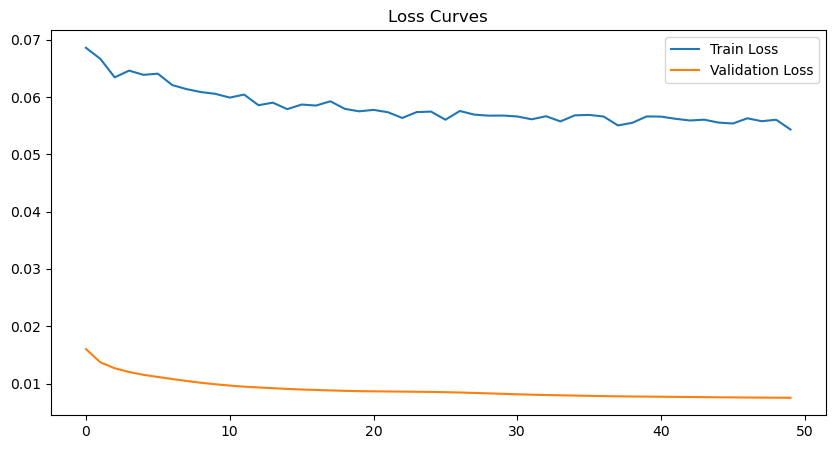

predictions: [-0.04727404  0.01984147 -0.05731282 -0.03921036 -0.06029035]
actuals: [0. 0. 0. 0. 0.]
correct: 21
total: 60


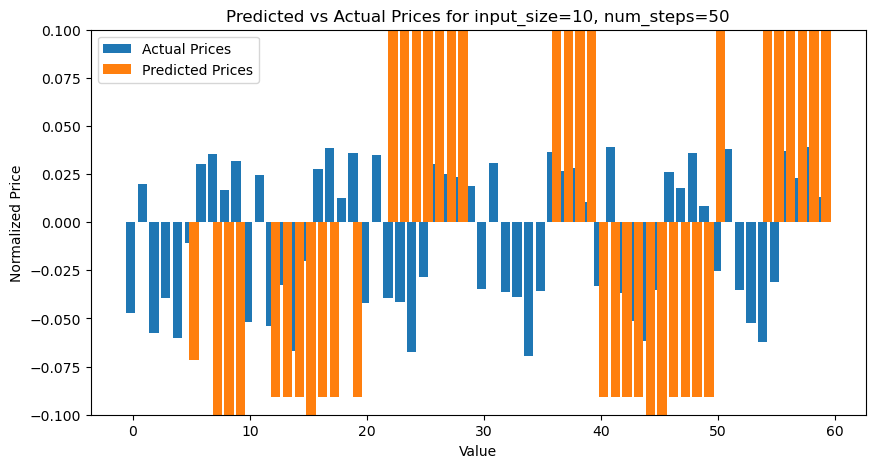

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


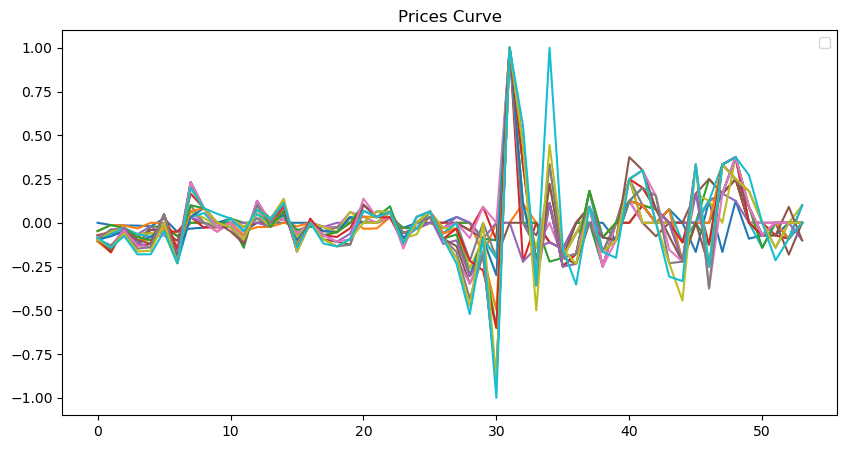

Epoch 1/50, Train Loss: 0.0661, Val Loss: 0.0598


Epoch 2/50, Train Loss: 0.0653, Val Loss: 0.0586


Epoch 3/50, Train Loss: 0.0634, Val Loss: 0.0573


Epoch 4/50, Train Loss: 0.0629, Val Loss: 0.0561


Epoch 5/50, Train Loss: 0.0616, Val Loss: 0.0550


Epoch 6/50, Train Loss: 0.0618, Val Loss: 0.0541


Epoch 7/50, Train Loss: 0.0610, Val Loss: 0.0535


Epoch 8/50, Train Loss: 0.0603, Val Loss: 0.0529


Epoch 9/50, Train Loss: 0.0592, Val Loss: 0.0525


Epoch 10/50, Train Loss: 0.0592, Val Loss: 0.0521


Epoch 11/50, Train Loss: 0.0587, Val Loss: 0.0518


Epoch 12/50, Train Loss: 0.0583, Val Loss: 0.0515


Epoch 13/50, Train Loss: 0.0579, Val Loss: 0.0513


Epoch 14/50, Train Loss: 0.0577, Val Loss: 0.0511


Epoch 15/50, Train Loss: 0.0575, Val Loss: 0.0509


Epoch 16/50, Train Loss: 0.0566, Val Loss: 0.0508


Epoch 17/50, Train Loss: 0.0569, Val Loss: 0.0506


Epoch 18/50, Train Loss: 0.0559, Val Loss: 0.0505


Epoch 19/50, Train Loss: 0.0553, Val Loss: 0.0503


Epoch 20/50, Train Loss: 0.0564, Val Loss: 0.0501


Epoch 21/50, Train Loss: 0.0555, Val Loss: 0.0499


Epoch 22/50, Train Loss: 0.0554, Val Loss: 0.0497


Epoch 23/50, Train Loss: 0.0551, Val Loss: 0.0495


Epoch 24/50, Train Loss: 0.0546, Val Loss: 0.0493


Epoch 25/50, Train Loss: 0.0546, Val Loss: 0.0491


Epoch 26/50, Train Loss: 0.0546, Val Loss: 0.0490


Epoch 27/50, Train Loss: 0.0544, Val Loss: 0.0488


Epoch 28/50, Train Loss: 0.0544, Val Loss: 0.0487


Epoch 29/50, Train Loss: 0.0540, Val Loss: 0.0486


Epoch 30/50, Train Loss: 0.0535, Val Loss: 0.0485


Epoch 31/50, Train Loss: 0.0535, Val Loss: 0.0484


Epoch 32/50, Train Loss: 0.0534, Val Loss: 0.0483


Epoch 33/50, Train Loss: 0.0541, Val Loss: 0.0482


Epoch 34/50, Train Loss: 0.0521, Val Loss: 0.0481


Epoch 35/50, Train Loss: 0.0528, Val Loss: 0.0480


Epoch 36/50, Train Loss: 0.0523, Val Loss: 0.0479


Epoch 37/50, Train Loss: 0.0523, Val Loss: 0.0478


Epoch 38/50, Train Loss: 0.0522, Val Loss: 0.0476


Epoch 39/50, Train Loss: 0.0520, Val Loss: 0.0475


Epoch 40/50, Train Loss: 0.0516, Val Loss: 0.0474


Epoch 41/50, Train Loss: 0.0521, Val Loss: 0.0473


Epoch 42/50, Train Loss: 0.0524, Val Loss: 0.0472


Epoch 43/50, Train Loss: 0.0521, Val Loss: 0.0471


Epoch 44/50, Train Loss: 0.0519, Val Loss: 0.0470


Epoch 45/50, Train Loss: 0.0517, Val Loss: 0.0469


Epoch 46/50, Train Loss: 0.0513, Val Loss: 0.0467


Epoch 47/50, Train Loss: 0.0506, Val Loss: 0.0466


Epoch 48/50, Train Loss: 0.0504, Val Loss: 0.0465


Epoch 49/50, Train Loss: 0.0513, Val Loss: 0.0465


Epoch 50/50, Train Loss: 0.0496, Val Loss: 0.0464


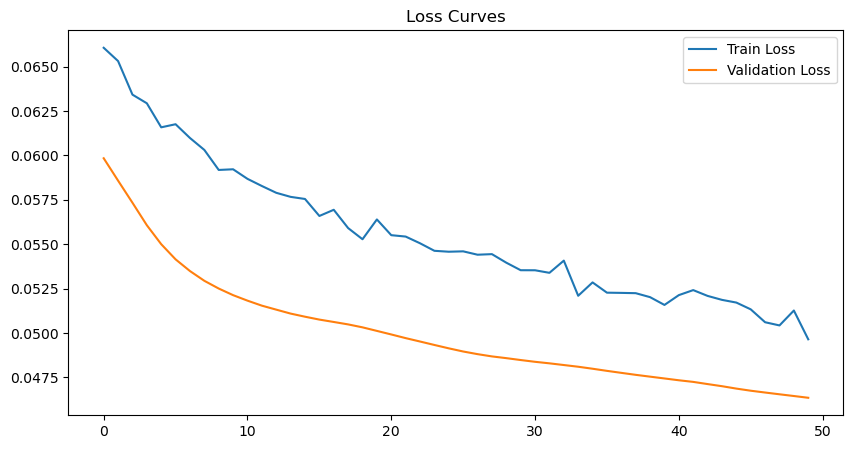

predictions: [-0.04637443 -0.09749451 -0.12801494  0.13979055 -0.06948522]
actuals: [0.125 0.25  0.25  0.25  0.125]
correct: 35
total: 120


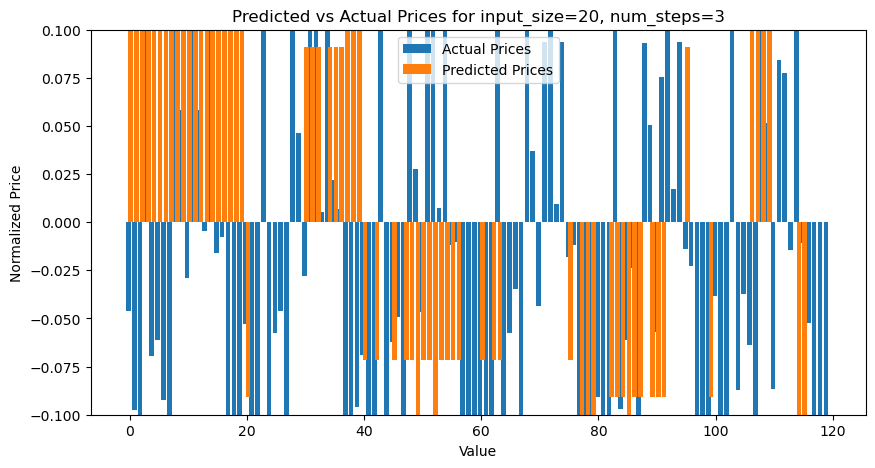

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


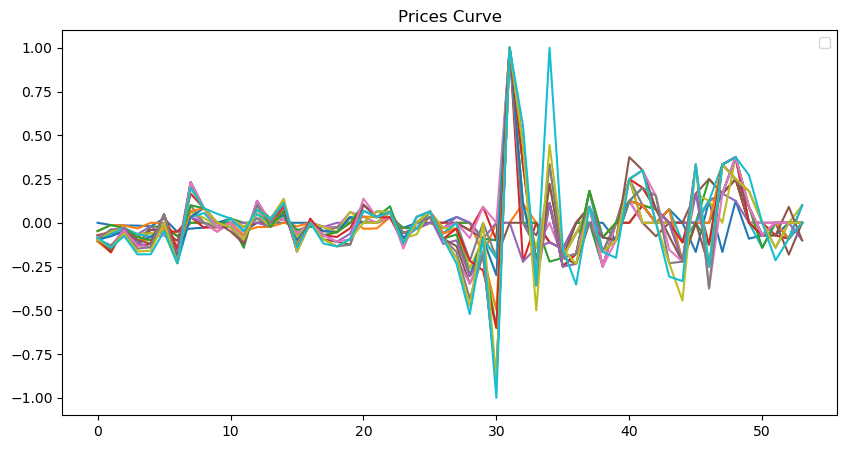

Epoch 1/50, Train Loss: 0.0702, Val Loss: 0.0841


Epoch 2/50, Train Loss: 0.0663, Val Loss: 0.0822


Epoch 3/50, Train Loss: 0.0665, Val Loss: 0.0803


Epoch 4/50, Train Loss: 0.0653, Val Loss: 0.0792


Epoch 5/50, Train Loss: 0.0639, Val Loss: 0.0785


Epoch 6/50, Train Loss: 0.0646, Val Loss: 0.0778


Epoch 7/50, Train Loss: 0.0633, Val Loss: 0.0769


Epoch 8/50, Train Loss: 0.0621, Val Loss: 0.0760


Epoch 9/50, Train Loss: 0.0628, Val Loss: 0.0754


Epoch 10/50, Train Loss: 0.0615, Val Loss: 0.0745


Epoch 11/50, Train Loss: 0.0621, Val Loss: 0.0736


Epoch 12/50, Train Loss: 0.0611, Val Loss: 0.0724


Epoch 13/50, Train Loss: 0.0617, Val Loss: 0.0705


Epoch 14/50, Train Loss: 0.0602, Val Loss: 0.0696


Epoch 15/50, Train Loss: 0.0605, Val Loss: 0.0694


Epoch 16/50, Train Loss: 0.0610, Val Loss: 0.0693


Epoch 17/50, Train Loss: 0.0614, Val Loss: 0.0693


Epoch 18/50, Train Loss: 0.0601, Val Loss: 0.0692


Epoch 19/50, Train Loss: 0.0609, Val Loss: 0.0691


Epoch 20/50, Train Loss: 0.0600, Val Loss: 0.0691


Epoch 21/50, Train Loss: 0.0596, Val Loss: 0.0691


Epoch 22/50, Train Loss: 0.0591, Val Loss: 0.0690


Epoch 23/50, Train Loss: 0.0594, Val Loss: 0.0689


Epoch 24/50, Train Loss: 0.0591, Val Loss: 0.0688


Epoch 25/50, Train Loss: 0.0599, Val Loss: 0.0687


Epoch 26/50, Train Loss: 0.0597, Val Loss: 0.0686


Epoch 27/50, Train Loss: 0.0593, Val Loss: 0.0685


Epoch 28/50, Train Loss: 0.0593, Val Loss: 0.0684


Epoch 29/50, Train Loss: 0.0589, Val Loss: 0.0682


Epoch 30/50, Train Loss: 0.0598, Val Loss: 0.0681


Epoch 31/50, Train Loss: 0.0589, Val Loss: 0.0679


Epoch 32/50, Train Loss: 0.0591, Val Loss: 0.0678


Epoch 33/50, Train Loss: 0.0592, Val Loss: 0.0677


Epoch 34/50, Train Loss: 0.0591, Val Loss: 0.0678


Epoch 35/50, Train Loss: 0.0593, Val Loss: 0.0678


Epoch 36/50, Train Loss: 0.0586, Val Loss: 0.0678


Epoch 37/50, Train Loss: 0.0585, Val Loss: 0.0678


Epoch 38/50, Train Loss: 0.0581, Val Loss: 0.0677


Epoch 39/50, Train Loss: 0.0579, Val Loss: 0.0676


Epoch 40/50, Train Loss: 0.0583, Val Loss: 0.0675


Epoch 41/50, Train Loss: 0.0582, Val Loss: 0.0675


Epoch 42/50, Train Loss: 0.0580, Val Loss: 0.0675


Epoch 43/50, Train Loss: 0.0573, Val Loss: 0.0675


Epoch 44/50, Train Loss: 0.0572, Val Loss: 0.0676


Epoch 45/50, Train Loss: 0.0573, Val Loss: 0.0676


Epoch 46/50, Train Loss: 0.0578, Val Loss: 0.0676


Epoch 47/50, Train Loss: 0.0582, Val Loss: 0.0677


Epoch 48/50, Train Loss: 0.0574, Val Loss: 0.0678


Epoch 49/50, Train Loss: 0.0567, Val Loss: 0.0679


Epoch 50/50, Train Loss: 0.0571, Val Loss: 0.0680


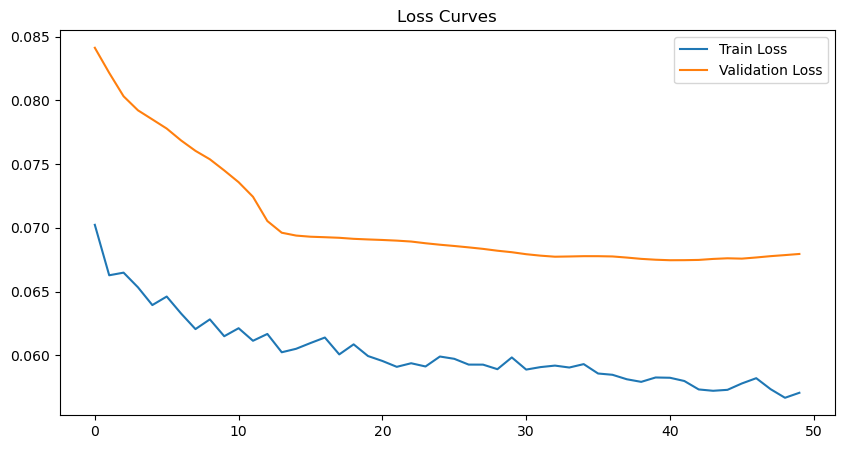

predictions: [ 0.09249163 -0.12046672 -0.05736526 -0.02951049  0.0288066 ]
actuals: [-0.09090909  0.          0.          0.          0.        ]
correct: 23
total: 100


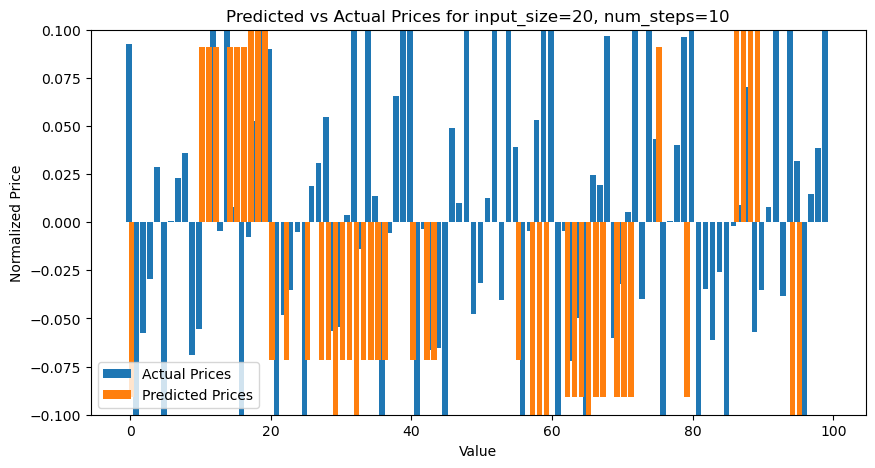

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


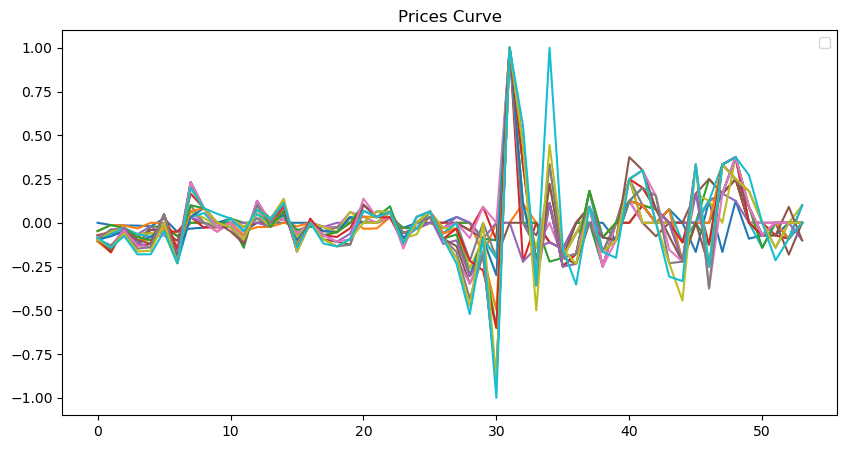

Epoch 1/50, Train Loss: 0.0871, Val Loss: 0.0652


Epoch 2/50, Train Loss: 0.0820, Val Loss: 0.0638


Epoch 3/50, Train Loss: 0.0803, Val Loss: 0.0633


Epoch 4/50, Train Loss: 0.0795, Val Loss: 0.0632


Epoch 5/50, Train Loss: 0.0800, Val Loss: 0.0632


Epoch 6/50, Train Loss: 0.0786, Val Loss: 0.0632


Epoch 7/50, Train Loss: 0.0776, Val Loss: 0.0631


Epoch 8/50, Train Loss: 0.0773, Val Loss: 0.0630


Epoch 9/50, Train Loss: 0.0757, Val Loss: 0.0630


Epoch 10/50, Train Loss: 0.0765, Val Loss: 0.0629


Epoch 11/50, Train Loss: 0.0760, Val Loss: 0.0629


Epoch 12/50, Train Loss: 0.0757, Val Loss: 0.0630


Epoch 13/50, Train Loss: 0.0753, Val Loss: 0.0630


Epoch 14/50, Train Loss: 0.0755, Val Loss: 0.0630


Epoch 15/50, Train Loss: 0.0749, Val Loss: 0.0630


Epoch 16/50, Train Loss: 0.0759, Val Loss: 0.0630


Epoch 17/50, Train Loss: 0.0747, Val Loss: 0.0629


Epoch 18/50, Train Loss: 0.0747, Val Loss: 0.0628


Epoch 19/50, Train Loss: 0.0745, Val Loss: 0.0628


Epoch 20/50, Train Loss: 0.0745, Val Loss: 0.0627


Epoch 21/50, Train Loss: 0.0748, Val Loss: 0.0628


Epoch 22/50, Train Loss: 0.0740, Val Loss: 0.0628


Epoch 23/50, Train Loss: 0.0741, Val Loss: 0.0628


Epoch 24/50, Train Loss: 0.0742, Val Loss: 0.0629


Epoch 25/50, Train Loss: 0.0745, Val Loss: 0.0629


Epoch 26/50, Train Loss: 0.0750, Val Loss: 0.0629


Epoch 27/50, Train Loss: 0.0735, Val Loss: 0.0630


Epoch 28/50, Train Loss: 0.0740, Val Loss: 0.0631


Epoch 29/50, Train Loss: 0.0743, Val Loss: 0.0632


Epoch 30/50, Train Loss: 0.0737, Val Loss: 0.0632
Early stopping triggered


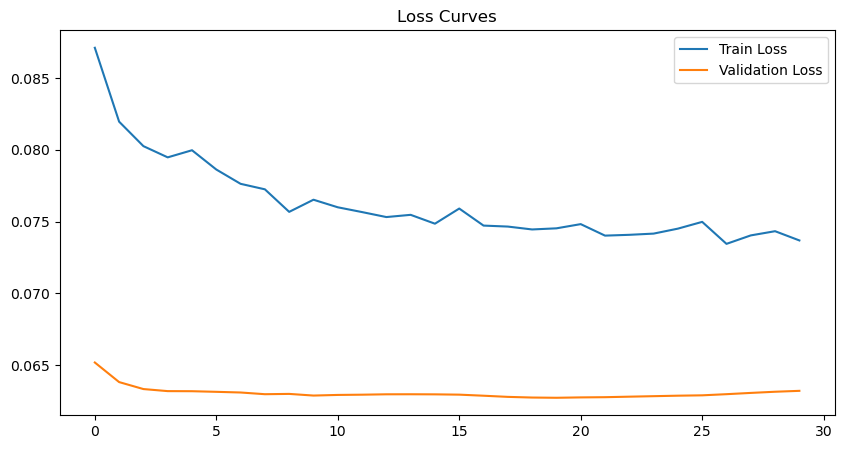

predictions: [-0.0998588  -0.16909862 -0.01744704  0.08155394 -0.04643701]
actuals: [-0.07142857  0.         -0.07142857  0.          0.        ]
correct: 21
total: 80


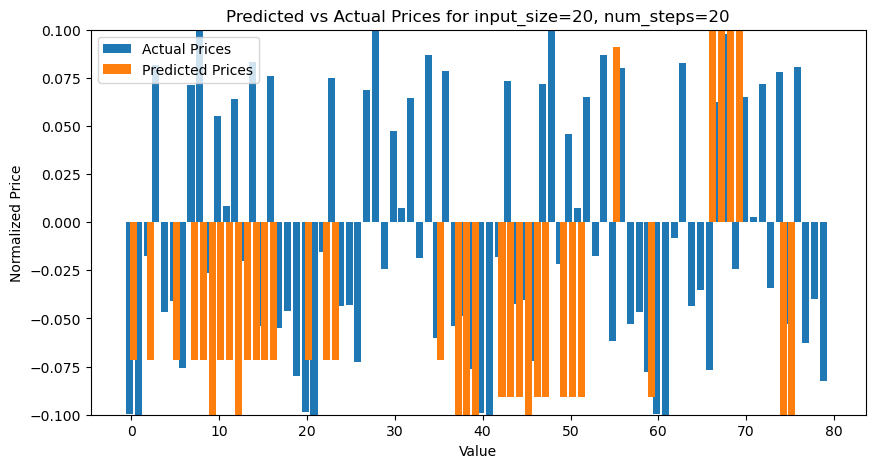

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


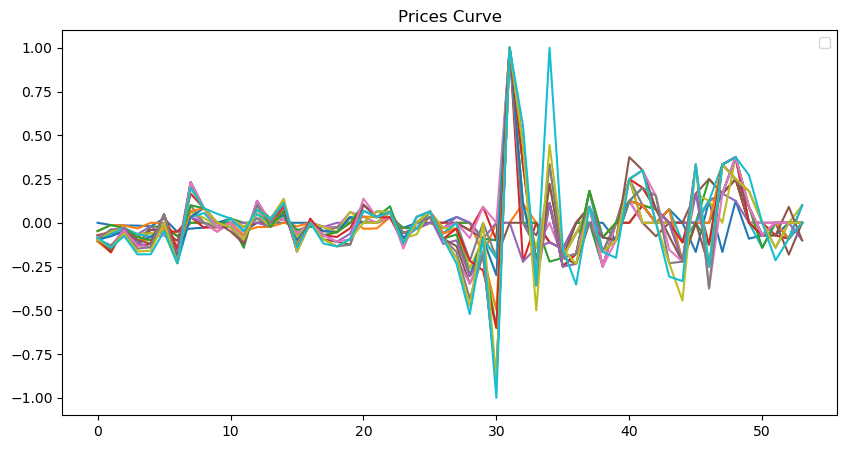

Epoch 1/50, Train Loss: 0.1241, Val Loss: 0.0251


Epoch 2/50, Train Loss: 0.1207, Val Loss: 0.0252


Epoch 3/50, Train Loss: 0.1178, Val Loss: 0.0236


Epoch 4/50, Train Loss: 0.1194, Val Loss: 0.0216


Epoch 5/50, Train Loss: 0.1174, Val Loss: 0.0205


Epoch 6/50, Train Loss: 0.1189, Val Loss: 0.0203


Epoch 7/50, Train Loss: 0.1164, Val Loss: 0.0200


Epoch 8/50, Train Loss: 0.1189, Val Loss: 0.0200


Epoch 9/50, Train Loss: 0.1182, Val Loss: 0.0201


Epoch 10/50, Train Loss: 0.1152, Val Loss: 0.0204


Epoch 11/50, Train Loss: 0.1140, Val Loss: 0.0204


Epoch 12/50, Train Loss: 0.1140, Val Loss: 0.0204


Epoch 13/50, Train Loss: 0.1143, Val Loss: 0.0201


Epoch 14/50, Train Loss: 0.1148, Val Loss: 0.0197


Epoch 15/50, Train Loss: 0.1144, Val Loss: 0.0192


Epoch 16/50, Train Loss: 0.1136, Val Loss: 0.0186


Epoch 17/50, Train Loss: 0.1136, Val Loss: 0.0182


Epoch 18/50, Train Loss: 0.1146, Val Loss: 0.0178


Epoch 19/50, Train Loss: 0.1135, Val Loss: 0.0176


Epoch 20/50, Train Loss: 0.1114, Val Loss: 0.0174


Epoch 21/50, Train Loss: 0.1122, Val Loss: 0.0172


Epoch 22/50, Train Loss: 0.1110, Val Loss: 0.0172


Epoch 23/50, Train Loss: 0.1126, Val Loss: 0.0171


Epoch 24/50, Train Loss: 0.1122, Val Loss: 0.0170


Epoch 25/50, Train Loss: 0.1108, Val Loss: 0.0168


Epoch 26/50, Train Loss: 0.1131, Val Loss: 0.0167


Epoch 27/50, Train Loss: 0.1117, Val Loss: 0.0166


Epoch 28/50, Train Loss: 0.1119, Val Loss: 0.0166


Epoch 29/50, Train Loss: 0.1114, Val Loss: 0.0166


Epoch 30/50, Train Loss: 0.1096, Val Loss: 0.0165


Epoch 31/50: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]

In [ ]:
# LSTM (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
cell_type = 'lstm'
SEARCH_NEEDED_LSTM = True
df_best_model = get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=SEARCH_NEEDED_LSTM)

In [ ]:
df_best_model

In [ ]:
# Modify the input_size and num_steps attributes
data_preparation = DataPreparation(dataset_name, num_steps=int(df_best_model['Number of Steps']), input_size=int(df_best_model['Input Size']))

# Training
trainer = ModelTrainer(data_preparation, cell_type)
trained_model, training_duration = trainer.train()

# Prediction
predictor = ModelPredictor(trained_model, data_preparation, cell_type)
test_loss, classification_accuracy = predictor.predict()

print("Test loss of best model:", test_loss)
print("Classification accuracy of best model:", classification_accuracy)
print("Duration of best model:", training_duration)

In [ ]:
# GRU (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
cell_type = 'gru'
SEARCH_NEEDED_GRU = True
df_best_model = get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=SEARCH_NEEDED_GRU)

In [ ]:
df_best_model

In [ ]:
# Modify the input_size and num_steps attributes
data_preparation = DataPreparation(dataset_name, num_steps=int(df_best_model['Number of Steps']), input_size=int(df_best_model['Input Size']))

# Training
trainer = ModelTrainer(data_preparation, cell_type)
trained_model, training_duration = trainer.train()

# Prediction
predictor = ModelPredictor(trained_model, data_preparation, cell_type)
test_loss, classification_accuracy = predictor.predict()

print("Test loss of best model:", test_loss)
print("Classification accuracy of best model:", classification_accuracy)
print("Duration of best model:", training_duration)

In [ ]:
# import numpy as np
# from scipy.special import kl_div

# # Sample data for demonstration purposes
# # In practice, you would use actual activation data from the model
# def get_fp32_activation_data():
#     # Replace this with actual data collection
#     return np.array([0.5, 1.0, 2.0, -1.0, -0.5, 3.0, -3.0, 0.1])

# # **1. Calibration: Collect Data and Compute Scale Factor**

# # Collect activation data (replace with actual FP32 data)
# activation_data_fp32 = get_fp32_activation_data()

# # Step 1: Determine the maximum absolute value
# max_abs_value = np.max(np.abs(activation_data_fp32))

# # Step 2: Compute the scale factor for symmetric quantization
# def compute_scale(max_abs_value):
#     return max_abs_value / 127  # 127 because 8-bit quantization uses values from -128 to 127

# scale = compute_scale(max_abs_value)

# # Step 3: Perform preliminary quantization of FP32 data
# def preliminary_quantize(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8 = preliminary_quantize(activation_data_fp32, scale)

# # Step 4: Compute histograms for FP32 and INT8
# def compute_histograms(fp32_data, int8_data):
#     hist_fp32, _ = np.histogram(fp32_data, bins=2048, range=(-128, 127), density=True)
#     hist_int8, _ = np.histogram(int8_data, bins=2048, range=(-128, 127), density=True)
#     return hist_fp32, hist_int8

# hist_fp32, hist_int8 = compute_histograms(activation_data_fp32, activation_data_int8)

# # Step 5: Compute KL divergence
# def compute_kl_divergence(hist_fp32, hist_int8):
#     # Adding a small constant to avoid log(0)
#     return np.sum(kl_div(hist_fp32 + 1e-8, hist_int8 + 1e-8))

# kl_divergence = compute_kl_divergence(hist_fp32, hist_int8)
# print(f"KL Divergence: {kl_divergence}")

# # **2. Quantization: Convert FP32 to INT8**

# # Final quantization of FP32 data
# def quantize_to_int8(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8_final = quantize_to_int8(activation_data_fp32, scale)

# # **3. INT32 Computations: Perform Layer Operations**

# # Example INT32 computation function
# def int32_computations(weights, activations, bias):
#     # Perform INT32 matrix multiplication and add bias
#     int32_result = np.dot(weights, activations) + bias
#     return int32_result

# # Sample weights and bias for demonstration
# weights = np.array([[1, -1], [2, 3]])
# bias = np.array([1, -1])

# # Perform INT32 computations
# int32_result = int32_computations(weights, activation_data_int8_final, bias)
# print(f"INT32 Computation Result: {int32_result}")

# # **4. Re-Quantization: Convert INT32 to INT8**

# # Re-quantization process
# def requantize(int32_activations, scale, zero_point, bias):
#     # Add bias and then requantize
#     int32_activations_with_bias = int32_activations + bias
#     return np.clip(np.round(int32_activations_with_bias * scale) + zero_point, -128, 127).astype(np.int8)

# # Assuming zero_point = 0 for symmetric quantization
# zero_point = 0

# # Re-quantize INT32 results to INT8
# activation_data_int8_requantized = requantize(int32_result, scale, zero_point, bias)
# print(f"Re-Quantized INT8 Data: {activation_data_int8_requantized}")

# # **5. De-Quantization: Convert INT8 Back to FP32**

# # De-quantization process
# def dequantize_to_fp32(int8_data, scale, zero_point):
#     return (int8_data - zero_point) * scale

# # Convert INT8 results back to FP32
# fp32_reconstructed_data = dequantize_to_fp32(activation_data_int8_requantized, scale, zero_point)
# print(f"De-Quantized FP32 Data: {fp32_reconstructed_data}")